# Genome-scale metabolic modelling of trimethoprim’s mode of action reveals free ATP salvaged to restore purine pool

All material is intended to be executed in ScrumPy3 IDLE and cannot be run within the Jupyter Notebook. 

### Custom modules

In [ ]:
# ATPScan module
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from ScrumPy.Data import DataSets


class ScanRes(DataSets.DataSet):

    def __init__(self, *args, **kwargs):
        DataSets.DataSet.__init__(self, *args, **kwargs)


    def changers(self, lim=1e-7):
        """Filter list to select reactions which pass the cutoff for change in flux."""
        return [cname for cname in self.cnames if np.ptp(self.GetCol(cname)) > lim]


def scan(model: object, low=1.0, high=200.0, n=100, lp=None, flux_bounds=None, ATPase="ATPSynth", plot=True) -> (object, dict):
    """
    Perform an ATP scan on a Linear Programme.

        Parameters:
            model (obj) : model
            low (float) : lowest flux point
            high (float): highest flux point
            n (int) : number of points
            lp (obj) : linear programme object
            ATPase (str) : ATPase reaction
            flux_bounds (dict) : define flux bounds for lp
            plot (bool) : plot result using GNUplot

        Returns:
            rv (Object) : GNU plotting instance
            results (dict) : result of ATP scan [flux, reaction name, value]
    """
    if plot:
        rv = ScanRes()

    if not lp: 
        lp = model.GetLP()
        lp.SetObjective(model.sm.cnames)

    if flux_bounds:
        lp.SetFluxBounds(flux_bounds)

    step = (high - low) / (n-1)

    result = {}
    result["flux"] = result["reactions"] = result["values"] = None

    for atp in np.arange(low, high, step):

        lp.SetFixedFlux({ATPase: atp})
        lp.Solve(PrintStatus=False) 

        if lp.IsStatusOptimal():

            sol = lp.GetPrimSol()

            r, v = zip(*sol.items())
            f = [atp] * len(r)

            for key, sub, typ in zip(list(result.keys()), (f, r, v), (float, str, float)):
                master = result[key]
                if master is not None:
                   master = np.concatenate((master, np.array(sub, dtype=np.dtype(typ))), axis=None)
                else:
                    master = np.array(sub, dtype=np.dtype(typ))
                
                result[key] = master

            if plot: 
                rv.UpdateFromDic(sol)

    if plot:
        rv.SetPlotX(ATPase)
        rv.AddToPlot(rv.changers())
    
    return rv, result


def scan_weighting(model: object, low=1.0, high=200.0, n=100, lp=None, flux_bounds=None, target="ATPSynth") -> (object, dict):
    """
    Perform an ATP scan on a Linear Programme.

        Parameters:
            model (obj) : model
            low (float) : lowest flux point
            high (float): highest flux point
            n (int) : number of points
            lp (obj) : linear programme object
            target (str) : reaction to apply increasing flux
            flux_bounds (dict) : define flux bounds for lp

        Returns:
            rv (Object) : GNU plotting instance
            results (dict) : result of ATP scan [flux, reaction name, value]
    """
    rv = ScanRes()

    if not lp: 
        lp = model.GetLP()
        lp.SetObjective(model.sm.cnames)
    if flux_bounds:
        lp.SetFluxBounds(flux_bounds)

    step = (high - low) / (n-1)
    result = {"flux" : None, "reactions" : None, "values" : None}

    for flux in np.arange(low, high, step):
        lp.SetObjCoef(target, flux)
        lp.Solve(PrintStatus=False) 
        if lp.IsStatusOptimal():
            sol = lp.GetPrimSol()
            rv.UpdateFromDic(sol)
            
            keys, values = zip(*sol.items())
            target_flux = [flux] * len(keys)

            for key, sub, typ in zip(list(result.keys()), (target_flux, keys, values), (float, str, float)):
                master = result[key]
                if master is not None:
                   master = np.concatenate((master, np.array(sub, dtype=np.dtype(typ))), axis=None)
                else:
                    master = np.array(sub, dtype=np.dtype(typ))
                result[key] = master
    rv.SetPlotX(target)
    rv.AddToPlot(rv.changers())
    return rv, result


def plot_atoms(result: dict, model, db):
    df = pd.DataFrame(result)
    df = df[df["reactions"].str.endswith("_tx")]

    transporter = df.reactions.drop_duplicates()\
        .values.tolist()

    carbon_atoms = {}
    nitrogen_atoms = {}

    for i in transporter:
        product = model.smx.Products(i)[0]
        carbons = db.dbs["Compound"][product].NumAtoms('C')
        nitrogens = db.dbs["Compound"][product].NumAtoms('N')
        carbon_atoms[i] = carbons
        nitrogen_atoms[i] = nitrogens

    df["Carbon"] = df.apply(lambda x : x["values"] * carbon_atoms[x["reactions"]], axis=1)
    df["Nitrogen"] = df.apply(lambda x : x["values"] * nitrogen_atoms[x["reactions"]], axis=1)

    f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
    sns.lineplot(data=df, x='flux', y='Carbon', hue='reactions', style='reactions', ax=ax1)
    sns.lineplot(data=df, x='flux', y='Nitrogen', hue='reactions', style='reactions', ax=ax2)
    ax2.legend([],[], frameon=False)
    plt.show()


def plot(result: dict):
    # df = pd.DataFrame(result)
    sns.lineplot(data=result, x='flux', y='values', hue='reactions', style='reactions')
    plt.show()


def plot_transporters(rv, suffix="_tx"):
    transporter = [tx for tx in rv.cnames if tx.endswith(suffix)]
    rv.RemoveAllFromPlot()
    rv.AddToPlot(transporter)
    return rv


def abs_total_sum(sol):
    "Get total flux of LP solution"
    return sum([abs(a) for a in sol.values()])


import tkinter as tk
# import tkinter.ttk as ttk

class LPTable(tk.Frame):

    def __init__(self):
        super().__init__()

        self.root = tk.Tk()
        self.id = 0
        self.iid = 0
        try:
            self.initialiseUI()
        except NameError:
            pass
        
    def initialiseUI(self):
        self.root.title(f"LP results")

        self.tree = ttk.Treeview(self.root, columns=("Name", "Reaction", "From", "To"))
        self.tree.pack(expand=True, side='left', fill='both')
        vsb = ttk.Scrollbar(self.root, orient="vertical", command=self.tree.yview)
        vsb.pack(side='right', fill='y')
        self.tree.configure(yscrollcommand=vsb.set)

        self.tree.heading("#0", text="Flux")
        self.tree.heading("#1", text="Name")
        self.tree.heading("#2", text="Reaction")
        self.tree.heading("#3", text="From")
        self.tree.heading("#4", text="To")

        self.tree.column('#0', width=100, stretch=tk.NO)
        self.treeview = self.tree


    def insert_data(self, flux, name, reaction, From, to):
            self.treeview.insert('', self.id, iid=self.iid, text=f"{flux}", values=(name, reaction, From, to))
            self.id += 1
            self.iid += 1


def tabulate(model, lp, exclude=None, include=None):
    """
    Show LP in a table 
        Parameters:
            model (obj) : model
            lp (obj) : lp
            exclude (list) : exclude given metabolites
            include(list) : include only given metabolites 
    """        
    tableGUI = LPTable()

    if exclude == "default":
        exclude = ["NADP", "NAD", "NADPH", "Pi", "PROTON", "WATER", "ADP", "ATP", "NADH", "PPI"]

    def filter_reaction(items):
        if exclude:
            return [item for item in items if item not in exclude]
        elif include:
            return [item for item in items if item in include]
        else:
            return items
    
    if output:
        filehandle = open(output, 'w')
        filehandle.write("Flux\tName\tReaction\tFrom\tTo")
    
    table = {}
    for reaction, flux in lp.items():
        table.update({reaction: {
                            "flux" : "{:.2f}".format(flux),
                            "reaction" : None,
                            "from" : [],
                            "to" : []
                            }})
        
        reac = split_reaction(model.smx.ReacToStr(reaction)[:-2])
        table[reaction]["reaction"] = " + ".join(reac.substrates) + " " + reac.direction + " " + " + ".join(reac.products)

        substrates = filter_reaction(model.smx.Reactants(reaction))
        products = filter_reaction(model.smx.Products(reaction))

        for reaction_b in lp.keys():
            if reaction_b != reaction:
                substrates_b = filter_reaction(model.smx.Reactants(reaction_b))
                products_b = filter_reaction(model.smx.Products(reaction_b))

                if SetUtils.does_intersect(substrates, products_b):
                    table[reaction]["from"].append(reaction_b)
                if SetUtils.does_intersect(substrates_b, products):
                    table[reaction]["to"].append(reaction_b)

        result = table[reaction]

        if any([result["from"], result["to"]]):
            tableGUI.insert_data(
                            result["flux"],
                            reaction,
                            result["reaction"],
                            ", ".join(result["from"]),
                            ", ".join(result["to"])
        )


In [ ]:
# SanityChecks.py
def CheckImbals(m,db,path='.', ExtraCompounds='ExtraCompounds.dat',reacs=[]):
    '''Pre:True
    Post: return dictionary of imbalanced reactions'''

    rv = {}
    db = Updatedb(db,path,ExtraCompounds)

    if reacs == []:
        reacs = filter(lambda x: not "_tx" in x, m.smx.cnames)
    for reac in reacs:
        stod = m.smx.InvolvedWith(reac)
        imbal = db.dbs['Compound'].AtomImbal(stod)

        if len(imbal) >0:
                rv[reac] = imbal

    return rv   

def IdentifyEmpForm(imbaldic):
    """ pre: imbaldic = CheckImbals(..)
        post: return empirical formula for unknown compounds in imbalanced dictionary
    """
    UBDict = imbaldic.copy()
    rv = {}
    uks = list(filter(lambda s: "Unknown compound " in s, UBDict))
    if len(uks)==1:
        uk = uks[0]
        del UBDict[uk]
        uk = uk.replace("Unknown compound ","")
        for k in UBDict:
                rv[k] = int(abs(UBDict[k]))
        return uk, rv
    return None  

In [ ]:
# MetabolicChecks.py

def CheckBMProduction(m,neg=True,lp=None,fd=None):
	"""pre: True
	post: the lp solution for production of each biomass components"""
	rv = {}
	if fd == None:
		bm = list(filter(lambda s:'_bm_tx' in s, m.sm.cnames))
	else:
		fd = EcoliBiomass.FluxDic(m)
		bm = list(fd.keys())
	if lp == None:
        	lp = BuildLP.BuildLP(m)
	for reac in bm:
		sol = CheckUnitFlux(m,reac,neg,lp)
		if sol == {}:
			print(reac)
			rv[reac] = 'NF'
		else:
			rv[reac] = sol

	return rv

def EnergyCheck(m,lp=None,check='ATPase'):
    """pre: reac in m.sm.cnames
       post: the lp solution for a unit flux in reac in absence of external energy source"""
    if lp ==None:
        lp = BuildLP.BlockUptakeLP(m)
    sol = CheckUnitFlux(m,check,lp=lp)
    return sol

### Global variables

In [ ]:
from M9FluxBounds import M9_flux_bounds
# >>> M9_flux_bounds
# {'Glc_mm_tx': (0.0, 11.0), 'Gly_aa_mm_tx': (0.0, 66.0), 'Met_aa_mm_tx': (0.0, 33.5), 'Ade_nt_mm_tx': (0.0, 37.0)}
m = ScrumPy.Model('Ecoli.spy') # loading the model
purines_only_bm = ["Adenine_bm_tx", "Guanine_bm_tx", "Xanthine_bm_tx", "Hypoxanthine_bm_tx"]
pur_bm_fd = {tx : 0 for tx in purines_only_bm}
AdAA_fd = {"Gly_aa_mm_tx" : 0, "Met_aa_mm_tx" : 0, "Ade_nt_mm_tx" : 0}

from Tools import EcoliBiomass, BuildLP
fd = EcoliBiomass.FluxDic(m)

from ScrumPy.Bioinf import PyoCyc
db = PyoCyc.Organism(data='data', Path="/home/carterc/Model/Work/Ecoli_UTI89_QIB/database/EcoliUTI89/22.0/")

from sys import path
path.append('/home/carterc/Model/Work/Ecoli_UTI89_QIB/Analysis') # For WSL
from ATPScan import ATPScan

## Model properties

In [ ]:
# Reactions (excluding transporters)
reacs = len([reac for reac in m.sm.cnames if not reac.endswith("_tx")])
# 1267

# Transporters
tx = len([reac for reac in m.sm.cnames if reac.endswith("_tx")])
# 77

# Reactions associated with identifiable genes
from ScrumPy.Util import Set
result = Set.Intersect(m.sm.cnames, db.dbs["REACTION"].keys())
geneAssoc = [r for r in result if db.dbs["REACTION"][r].GetGenes()]
NoGeneAssoc = [r for r in result if not db.dbs["REACTION"][r].GetGenes()]
len(geneAssoc)
# 1007

# Metabolites
met = len(m.sm.rnames)
# 1216

# Dead reactions
num_dead = len(m.DeadReactions())
# 564

# Orphan metabolites
orph = len(m.OrphanMets())
# 548

# Unbalanced reactions
len(CheckImbals(m, db))
# 0

# Metabolites with undefined empirical formulae
len(IdentifyEmpForm(CheckImbals(m, db)))
# 0

# Atomic balance for C, N, S, P, O, H
atom_imbals = db.AtomImbalDic(m)
[r for r in atom_imbals if not r.endswith('_tx')]

# Energy check
EnergyCheck(m)
# Undefined

# Biomass production
CheckBMProduction(m)
# All have optimal solutions

## Purine biosynthesis

In [ ]:
# Generate a dictionary of LP solutions for synthesising 1 unit of each purine biomass component
from collections import Counter

data = {}
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux(AdAA_fd)

for purine_bm_tx in purines_only_bm:
  lp.SetFixedFlux({purine_bm_tx : -1})
  lp.Solve(PrintStatus=False)
  data[purine_bm_tx] = lp.GetPrimSol()
  lp.ClearFluxConstraint(purine_bm_tx)

rcount = Counter()
for sol in data.values():
	rcount.update(list(sol.keys()))


[r for r, v in rcount.items() if v == 4]
['GAPOXNPHOSPHN-RXN', 'AICARSYN-RXN', 'F16ALDOLASE-RXN', 'GART-RXN', 'AICARTRANSFORM-RXN', 'RXN0-742', 
'RXN0-5224', 'RXN-12352', 'PYRUVFORMLY-RXN', 'METHENYLTHFCYCLOHYDRO-RXN', 'RXN0-1402', 'RXN0-1401', 'FGAMSYN-RXN',
 'SAICARSYN-RXN', 'RXN0-743', 'IMPCYCLOHYDROLASE-RXN', '1PFRUCTPHOSN-RXN', 'RXN-14047', 'GLUTAMINESYN-RXN', 
 'GLYOHMETRANS-RXN', 'GLUCISOM-RXN', 'GLYRIBONUCSYN-RXN', 'CITSYN-RXN', 'PRPPAMIDOTRANS-RXN', 'RXN-14515', 
 'AIRS-RXN', '2PGADEHYDRAT-RXN', '1.5.1.15-RXN', 'FHLMULTI-RXN', 'GCVMULTI-RXN', 'R601-RXN', 'INORGPYROPHOSPHAT-RXN',
  'PEPDEPHOS-RXN', 'NADH_DH_ubi', 'Succ_DH', 'ATPSynth', 'Glc_mm_tx', 'AMMONIUM_tx', 'CO2_tx', 'O2_tx', 'EtOH_bp_tx', 
  'RXN0-5256', 'ALCOHOL-DEHYDROG-RXN', 'ACETALD-DEHYDROG-RXN', 'FUMHYDR-RXN', 'ALDOSE-1-EPIMERASE-RXN', 'RXN-15513', 
  'ASPARTASE-RXN', 'PHOSGLYPHOS-RXN', 'TRIOSEPISOMERIZATION-RXN', 'H2O_tx', 'RXN0-5186', 'RXN-15125', 'RXN-8899',
  'ISOCITRATE-DEHYDROGENASE-NAD+-RXN', '2-OXOGLUTARATE-SYNTHASE-RXN', 'SUCCCOASYN-RXN']

for purine_bm_tx, sol in data.items():
  # print(purine_bm_tx)
  net_production = 0
  net_loss = 0
  reacs = []
  for reac, flux in sol.items():
    if m.smx["ATP", reac].digits() != '0':
      flux = round(flux, 4)
      bal = int(m.smx["ATP", reac].digits())
      adjusted_flux = flux * bal
      reacs.append(f"{reac} {adjusted_flux}")
      if adjusted_flux > 0:
        net_production += adjusted_flux
      else:
        net_loss+= adjusted_flux
  print(f"{purine_bm_tx}: gain {net_production}; loss {net_loss}")
  for s in reacs:
    print("---", s)

# Adenine_bm_tx: gain 10.7116; loss -10.711500000000001
# --- RXN0-742 -1.0
# --- RXN0-1402 -1.0
# --- RXN0-1401 -1.0
# --- FGAMSYN-RXN -1.0
# --- SAICARSYN-RXN -1.0
# --- 1PFRUCTPHOSN-RXN -1.7115
# --- GLUTAMINESYN-RXN -2.0
# --- GLYRIBONUCSYN-RXN -1.0
# --- AIRS-RXN -1.0
# --- SUCCCOASYN-RXN 0.5769
# --- PEPDEPHOS-RXN 3.4231
# --- ATPSynth 3.2885
# --- PHOSGLYPHOS-RXN 3.4231
# Guanine_bm_tx: gain 10.827; loss -10.8269
# --- RXN0-742 -1.0
# --- RXN0-1402 -1.0
# --- RXN0-1401 -1.0
# --- FGAMSYN-RXN -1.0
# --- SAICARSYN-RXN -1.0
# --- 1PFRUCTPHOSN-RXN -1.8269
# --- GLUTAMINESYN-RXN -2.0
# --- GLYRIBONUCSYN-RXN -1.0
# --- AIRS-RXN -1.0
# --- SUCCCOASYN-RXN 0.3462
# --- PEPDEPHOS-RXN 3.3077
# --- ATPSynth 3.1731
# --- PHOSGLYPHOS-RXN 3.6538
# --- PEPCARBOXYKIN-RXN 0.3462
# Xanthine_bm_tx: gain 10.519200000000001; loss -10.5192
# --- RXN0-742 -1.0
# --- RXN0-1402 -1.0
# --- RXN0-1401 -1.0
# --- FGAMSYN-RXN -1.0
# --- SAICARSYN-RXN -1.0
# --- 1PFRUCTPHOSN-RXN -1.5192
# --- GLUTAMINESYN-RXN -2.0
# --- GLYRIBONUCSYN-RXN -1.0
# --- AIRS-RXN -1.0
# --- SUCCCOASYN-RXN 0.4615
# --- PEPDEPHOS-RXN 2.5769
# --- ATPSynth 3.9808
# --- PHOSGLYPHOS-RXN 3.0385
# --- PEPCARBOXYKIN-RXN 0.4615
# Hypoxanthine_bm_tx: gain 10.4039; loss -10.4038
# --- RXN0-742 -1.0
# --- RXN0-1402 -1.0
# --- RXN0-1401 -1.0
# --- FGAMSYN-RXN -1.0
# --- SAICARSYN-RXN -1.0
# --- 1PFRUCTPHOSN-RXN -1.4038
# --- GLUTAMINESYN-RXN -2.0
# --- GLYRIBONUCSYN-RXN -1.0
# --- AIRS-RXN -1.0
# --- SUCCCOASYN-RXN 0.6923
# --- PEPDEPHOS-RXN 2.8077
# --- ATPSynth 4.0962
# --- PHOSGLYPHOS-RXN 2.8077

len([r for r, v in rcount.items() if v == 4]) / (len(rcount) - 4)
# 0.8028... - 80.3% of reactions involved with purine biosynthesis are core

core = [r for r, v in rcount.items() if v == 4]
for purine_bm_tx, sol in data.items():
  print("\n" + purine_bm_tx + "\n-----------")
  for reac, flux in sol.items():
    if reac not in core and reac != purine_bm_tx:
      print(flux, m.sm.ReacToStr(reac))

## Synthesising Folates and ATP de novo

In [ ]:
# Synthesising folates de novo
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **{"MeTHF_bm_tx" : -1}})
lp.Solve()
with open('../Data/folate_biosynthesis.csv', 'w') as f:
    _=f.write("Reaction,flux\n")
    for r, v in lp.GetPrimSol().items():
        _=f.write(f"{r},{v}\n")


# Synthesising ATP de novo
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **{"ATP_bm_tx" : -1}})
lp.Solve()

with open('../Data/ATP_biosynthesis.csv', 'w') as f:
    _=f.write("Reaction,flux\n")
    for r, v in lp.GetPrimSol().items():
        _=f.write(f"{r},{v}\n")

## Which biomass components require DHFR

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **{"DIHYDROFOLATEREDUCT-RXN" : 0}})

comps_ess = [] # biomass components that require DHFR

for biomass_comp, flux in fd.items():
  lp.SetFixedFlux({biomass_comp : flux})
  lp.Solve(PrintStatus=False)
  if not lp.IsStatusOptimal():
    comps_ess.append(biomass_comp)
  lp.ClearFluxConstraint(biomass_comp)

comps_ess
# ['dTTP_bm_tx', 'MeTHF_bm_tx']

## Which biomass components have a feasible route via DHFR

In [ ]:
lp = m.GetLP()
# lp.SetObjCoef("FA_Synth", 24)
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd})
results = []
for biomass_comp, flux in fd.items():
  ori_sol = False
  dhfr_sol = False
  lp.SetFixedFlux({biomass_comp : flux})
  lp.Solve(PrintStatus=False)
  ori_sol = lp.IsStatusOptimal()
  lp.SetFluxBounds({"DIHYDROFOLATEREDUCT-RXN" : (-10,-0.001)})
  lp.Solve(PrintStatus=False)
  dhfr_sol = lp.IsStatusOptimal()
  if ori_sol and dhfr_sol:
    results.append(biomass_comp)
  lp.ClearFluxConstraints(["DIHYDROFOLATEREDUCT-RXN", biomass_comp])

len(results)
# 47, thus all biomass components have a feasible solution using DHFR
len(fd)
# 47

lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
dhfr_unique = Counter()
dhfr_loss = Counter()
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd})
for biomass_comp, flux in fd.items():
  lp.SetFixedFlux({biomass_comp : flux})
  lp.Solve(PrintStatus=False)
  sol1 = lp.GetPrimSol()
  sol1_reacs = set(sol1.keys())
  lp.SetFluxBounds({"DIHYDROFOLATEREDUCT-RXN" : (-10,-0.001)})
  lp.Solve(PrintStatus=False)
  sol2 = lp.GetPrimSol()
  sol2_reacs = set(sol2.keys())
  lp.ClearFluxConstraints(["DIHYDROFOLATEREDUCT-RXN", biomass_comp])
  added = sol2_reacs - sol1_reacs
  loss = sol1_reacs - sol2_reacs
  dhfr_unique.update(list(added))
  dhfr_loss.update(list(loss))
len(dhfr_unique)
# 80
len(dhfr_loss)
# 35
dhfr_unique["DIHYDROFOLATEREDUCT-RXN"]
# 45
dhfr_unique['dTTP_bm_tx']
# 46 - thus, all solutions result in production of dTTP which fulfils an intenral cycle
# there's too many solutions to go through to see whether DHFR directly contributes
# to each biomass' production


## Which biomass components utilise folates in any form

In [1]:
len([
    "AICARTRANSFORM-RXN", "METHYLENETHFDEHYDROG-NADP-RXN", "3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN",
    "GART-RXN", "RXN-2881", "HOMOCYSMETB12-RXN", "1.5.1.20-RXN", "GCVMULTI-RXN", "DIHYDROFOLATEREDUCT-RXN",
    "1.5.1.15-RXN", "THYMIDYLATESYN-RXN", "GLYOHMETRANS-RXN", "METHENYLTHFCYCLOHYDRO-RXN",
    "RXN-5061", "RXN0-1862", "FORMYLTHFDEFORMYL-RXN", "RXN-13909", "5-FORMYL-THF-CYCLO-LIGASE-RXN",
    "2.1.1.19-RXN", "FORMATETHFLIG-RXN", "DIHYDROFOLATESYNTH-RXN"
    ])

21

In [ ]:
folates = [
           "10-FORMYL-THF", "THF", "METHYLENE-THF", "5-10-METHENYL-THF", "5-METHYL-THF", 
           "DIHYDROFOLATE"
           ]
# Generate list of reactions involving folates
folate_reacs = []
for fol in folates:
    reacs = m.smx.InvolvedWith(fol)
    for reac in reacs:
        folate_reacs.append(reac)

folate_reacs = ['DIHYDROFOLATESYNTH-RXN', 'RXN-2881', '1.5.1.15-RXN', '1.5.1.20-RXN', 'GLYOHMETRANS-RXN',
 'RXN-5061', 'METHENYLTHFCYCLOHYDRO-RXN', 'RXN0-1862', 'FORMATETHFLIG-RXN', 'RXN-13909', 
 'GCVMULTI-RXN', 'THYMIDYLATESYN-RXN', 'GART-RXN', 'DIHYDROFOLATEREDUCT-RXN', 'AICARTRANSFORM-RXN', 
 'METHYLENETHFDEHYDROG-NADP-RXN', 'HOMOCYSMETB12-RXN', '5-FORMYL-THF-CYCLO-LIGASE-RXN', 
 '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN', 'FORMYLTHFDEFORMYL-RXN']

folate_utilisation = {}
# Identifying which biomass components utilise folates in any form
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd})
for biomass_comp, flux in fd.items():
    lp.SetFixedFlux({biomass_comp : flux})
    lp.Solve(PrintStatus=False)
    sol = lp.GetPrimSol()
    folate_utilisation[biomass_comp] = [r for r in sol if r in folate_reacs]
    lp.ClearFluxConstraint(biomass_comp)

#adjusted for purines as not in fd
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd})
for biomass_comp in pur_bm_fd:
    lp.SetFixedFlux({biomass_comp : -1})
    lp.Solve(PrintStatus=False)
    sol = lp.GetPrimSol()
    folate_utilisation[biomass_comp] = [r for r in sol if r in folate_reacs]
    lp.ClearFluxConstraint(biomass_comp)

sum([len(fols) for fols in folate_utilisation.values() if fols]) / len(folate_utilisation)
# 3.45 is the average number of folate reactions involved in biomass production

folate_rcount = Counter()
for reacs in folate_utilisation.values():
  folate_rcount.update(reacs)
Counter({'METHENYLTHFCYCLOHYDRO-RXN': 30, 'GLYOHMETRANS-RXN': 30, '1.5.1.15-RXN': 21, 
'AICARTRANSFORM-RXN': 18, 'FORMYLTHFDEFORMYL-RXN': 17, 'GART-RXN': 17, 'GCVMULTI-RXN': 16, 
'METHYLENETHFDEHYDROG-NADP-RXN': 15, '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN': 3, '1.5.1.20-RXN': 2, 
'HOMOCYSMETB12-RXN': 2, 'DIHYDROFOLATEREDUCT-RXN': 2, 'THYMIDYLATESYN-RXN': 1, 'RXN-5061': 1, 
'DIHYDROFOLATESYNTH-RXN': 1})

# Do all biomass components utilise folates?
all([reacs for reacs in folate_utilisation.values()])
# False

# Thus, not all biomass components utilise folates, but which ones?
[bm_comp for bm_comp, reacs in folate_utilisation.items() if not reacs]
# ['Starch_bm_tx', 'Tyr_AA_bm_tx', 'Glt_AA_bm_tx', 'Lys_AA_bm_tx', 'Phe_AA_bm_tx', 'Gln_AA_bm_tx',
#  'Trp_AA_bm_tx', 'Ser_AA_bm_tx', 'Leu_AA_bm_tx', 'Cys_AA_bm_tx', 'Asn_AA_bm_tx', 'Arg_AA_bm_tx',
#   'Pro_AA_bm_tx', 'dCTP_bm_tx', 'CTP_bm_tx', 'UTP_bm_tx', 'Peptidoglycan_bm_tx', 'CLPN_bm_tx',
#   'Putrescine_bm_tx']
# 19 biomass components DO NOT utilise folates


# So, which biomass components do use folates?
utilise_folates = [bm_comp for bm_comp, reacs in folate_utilisation.items() if reacs]
utilise_folates
# ['Val_AA_bm_tx', 'Thr_AA_bm_tx', 'Met_AA_bm_tx', 'Gly_AA_bm_tx', 'His_AA_bm_tx', 'Cys_AA_bm_tx', 
# 'Asp_AA_bm_tx', 'Ile_AA_bm_tx', 'Ala_AA_bm_tx', 'Asn_AA_bm_tx', 'Arg_AA_bm_tx', 'dATP_bm_tx', 
# 'dGTP_bm_tx', 'dTTP_bm_tx', 'GTP_bm_tx', 'ATP_bm_tx', 'CLPN_bm_tx', 'Spermidine_bm_tx', 'MeTHF_bm_tx', 
# 'AcCoA_bm_tx', 'CoA_bm_tx', 'SucCoA_bm_tx', 'FAD_bm_tx', 'NAD_bm_tx', 'NADH_bm_tx', 'NADP_bm_tx', 
# 'NADPH_bm_tx', 'Adenine_bm_tx', 'Guanine_bm_tx', 'Xanthine_bm_tx', 'Hypoxanthine_bm_tx']
# 31 biomass components utilise folates

## Which biomass components require folates in any form

In [ ]:
#------------------------------------------------------------------------------
# Identify biomass components that are dependent on folates for their synthesis
# This analysis blocks the folate associated reactions needed for a given biomass component
# (found in the folate_utilisation dictionary) and tests whether a viable solution can
# be generated
folate_dependent = {}
folate_diverted = {}

lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd})
for biomass_comp in utilise_folates:
    bm_folates = {fol_reac : 0 for fol_reac in folate_utilisation[biomass_comp]}
    lp.SetFixedFlux({ **bm_folates, **{biomass_comp : -1}})
    lp.Solve(PrintStatus=False)
    folate_dependent[biomass_comp] = not lp.IsStatusOptimal()
    folate_diverted[biomass_comp] = any([rx for rx in lp.GetPrimSol() if rx in folate_reacs])
    lp.ClearFluxConstraint(biomass_comp)
    lp.ClearFluxConstraints(list(bm_folates.keys()))

for reac, stat in folate_dependent.items():
	print(f'{reac:18} --- {stat:10}')
# 1 denotes folate dependency
# Val_AA_bm_tx       ---          0
# Thr_AA_bm_tx       ---          0
# Met_AA_bm_tx       ---          1
# Gly_AA_bm_tx       ---          0
# His_AA_bm_tx       ---          1
# Cys_AA_bm_tx       ---          0
# Asp_AA_bm_tx       ---          0
# Ile_AA_bm_tx       ---          0
# Ala_AA_bm_tx       ---          0
# Asn_AA_bm_tx       ---          0
# Arg_AA_bm_tx       ---          0
# dATP_bm_tx         ---          1
# dGTP_bm_tx         ---          1
# dTTP_bm_tx         ---          1
# GTP_bm_tx          ---          1
# ATP_bm_tx          ---          1
# CLPN_bm_tx         ---          0
# Spermidine_bm_tx   ---          1
# MeTHF_bm_tx        ---          1
# AcCoA_bm_tx        ---          1
# CoA_bm_tx          ---          1
# SucCoA_bm_tx       ---          1
# FAD_bm_tx          ---          1
# NAD_bm_tx          ---          1
# NADH_bm_tx         ---          1
# NADP_bm_tx         ---          1
# NADPH_bm_tx        ---          1
# Adenine_bm_tx      ---          1
# Guanine_bm_tx      ---          1
# Xanthine_bm_tx     ---          1
# Hypoxanthine_bm_tx ---          1

for reac, stat in folate_diverted.items():
	print(f'{reac:18} --- {stat:10}')
# Val_AA_bm_tx       ---          0
# Thr_AA_bm_tx       ---          0
# Met_AA_bm_tx       ---          0
# Gly_AA_bm_tx       ---          0
# His_AA_bm_tx       ---          0
# Cys_AA_bm_tx       ---          0
# Asp_AA_bm_tx       ---          0
# Ile_AA_bm_tx       ---          0
# Ala_AA_bm_tx       ---          0
# Asn_AA_bm_tx       ---          0
# Arg_AA_bm_tx       ---          0
# dATP_bm_tx         ---          0
# dGTP_bm_tx         ---          0
# dTTP_bm_tx         ---          0
# GTP_bm_tx          ---          0
# ATP_bm_tx          ---          0
# CLPN_bm_tx         ---          0
# Spermidine_bm_tx   ---          0
# MeTHF_bm_tx        ---          0
# AcCoA_bm_tx        ---          0
# CoA_bm_tx          ---          0
# SucCoA_bm_tx       ---          0
# FAD_bm_tx          ---          0
# NAD_bm_tx          ---          0
# NADH_bm_tx         ---          0
# NADP_bm_tx         ---          0
# NADPH_bm_tx        ---          0
# Adenine_bm_tx      ---          0
# Guanine_bm_tx      ---          0
# Xanthine_bm_tx     ---          0
# Hypoxanthine_bm_tx ---          0

## Biomass production, folate utilisation, and folate dependency

In [ ]:
folate_reacs = ['DIHYDROFOLATESYNTH-RXN', 'RXN-2881', '1.5.1.15-RXN', '1.5.1.20-RXN', 'GLYOHMETRANS-RXN',
 'RXN-5061', 'METHENYLTHFCYCLOHYDRO-RXN', 'RXN0-1862', 'FORMATETHFLIG-RXN', 'RXN-13909', 
 'GCVMULTI-RXN', 'THYMIDYLATESYN-RXN', 'GART-RXN', 'DIHYDROFOLATEREDUCT-RXN', 'AICARTRANSFORM-RXN', 
 'METHYLENETHFDEHYDROG-NADP-RXN', 'HOMOCYSMETB12-RXN', '5-FORMYL-THF-CYCLO-LIGASE-RXN', 
 '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN', 'FORMYLTHFDEFORMYL-RXN']

fol_reacs_dict = {f : 0 for f in folate_reacs}

bm_txs = ['ATP_bm_tx', 'Val_AA_bm_tx', 'Spermidine_bm_tx', 'Starch_bm_tx', 'Arg_AA_bm_tx', 'FAD_bm_tx', 'Trp_AA_bm_tx', 'Thr_AA_bm_tx', 'Asp_AA_bm_tx', 
 'Leu_AA_bm_tx', 'Gln_AA_bm_tx', 'His_AA_bm_tx', 'Peptidoglycan_bm_tx', 'Ala_AA_bm_tx', 'NAD_bm_tx', 
'Asn_AA_bm_tx', 'Hypoxanthine_bm_tx', 'dTTP_bm_tx', 'Palmitate_bm_tx', 'GTP_bm_tx', 'Ser_AA_bm_tx', 'UTP_bm_tx', 
'Xanthine_bm_tx', 'Gly_AA_bm_tx', 'LPS_bm_tx', 'Lys_AA_bm_tx', 'Phe_AA_bm_tx', 'CoA_bm_tx', 'CTP_bm_tx', 'UDP-Glucose_bm_tx', 'Met_AA_bm_tx', 
'Pro_AA_bm_tx', 'Putrescine_bm_tx', 'CLPN_bm_tx', 'Ile_AA_bm_tx', 'Tyr_AA_bm_tx', 'MeTHF_bm_tx', 'Guanine_bm_tx', 'Inosine_bm_tx', 'Cys_AA_bm_tx',  'Adenine_bm_tx', 'Glt_AA_bm_tx']

bm_data = {
    'metabolite' : [], # name of biomass components
    'total'      : [], # total absolute flux of network
    'folates'    : [], # total absolute flux of folate reactions
    'dhfr'       : [], # total absolute flux of network with 0=Vdhfr
    'met'        : [], # total absolute flux of network with 0=Vhomocysmetb12-rxn
    'pur'        : [], # total absolute flux of network with 0=Vgart-rxn + Vaicartransform-rxn
    'oxobut'     : [], # total absolute flux of network with 0=V3-ch3-oxobutanoate-oh-ch3-xfer-rxn
    'nulfol'     : []  # total absolute flux of network with 0=Vfolates
    }

bm_data = {
    'metabolite' : [],
    'condition' : [],
    'flux' : []
    }

reac_pair = {
    'dhfr'       : {"DIHYDROFOLATEREDUCT-RXN" : 0},
    'met'        : {"HOMOCYSMETB12-RXN" : 0},
    'pur'        : {"GART-RXN" : 0, 'AICARTRANSFORM-RXN' : 0},
    'oxobut'     : {"3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN" : 0}, 
    'nulfol'     : fol_reacs_dict
    }

def abs_total_sum(sol):
    "Get total flux of LP solution"
    return sum([abs(a) for a in sol.values()])

def abs_total_sum_folates(sol):
    "Get total flux of LP solution"
    return sum([abs(a) for r, a in sol.items() if r in folate_reacs])

lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd})

for bm_tx in bm_txs:
    lp.SetFixedFlux({bm_tx : -1})
    lp.Solve(PrintStatus=False)
    sol = lp.GetPrimSol()
    total_abs = abs_total_sum(sol)
    folate_total = abs_total_sum_folates(sol)

    bm_data['metabolite'].append(bm_tx)
    bm_data['condition'].append('total')
    bm_data['flux'].append(total_abs)

    bm_data['metabolite'].append(bm_tx)
    bm_data['condition'].append('folates')
    bm_data['flux'].append(folate_total)

    for k, reacs in reac_pair.items():
        lp.SetFixedFlux(reacs)
        lp.Solve(PrintStatus=False)
        if lp.IsStatusOptimal():
            sol = lp.GetPrimSol()
            abs_flux = abs_total_sum(sol)
        else:
            abs_flux = 0

        bm_data['metabolite'].append(bm_tx)
        bm_data['condition'].append(k)
        bm_data['flux'].append(abs_flux)
        lp.ClearFluxConstraints(list(reacs.keys()))
    lp.ClearFluxConstraint(bm_tx)
        


## How metabolite supplementation counteracts trimethoprim action

In [ ]:
bm_txs = ['ATP_bm_tx', 'Spermidine_bm_tx', 'FAD_bm_tx', 'His_AA_bm_tx', 'NAD_bm_tx', 'Hypoxanthine_bm_tx', 'dTTP_bm_tx', 'GTP_bm_tx', 'Xanthine_bm_tx', 'CoA_bm_tx', 
            'Met_AA_bm_tx', 'Guanine_bm_tx', 'Inosine_bm_tx', 'Adenine_bm_tx']

bm_data = {
    'metabolite' : [],
    'condition' : [],
    'flux' : []
    }

clear_flux = {
    'adenine'       : {"Ade_nt_mm_tx" : 0},
    'glycine'       : {'Gly_aa_mm_tx' : 0},
    'met'           : {"Met_aa_mm_tx" : 0},
    'AdAA'          : AdAA_fd,
    'thymidine'     : {'Thy_mm_tx' : 0},
    'thy+AdAA'      : {**AdAA_fd, 'Thy_mm_tx' : 0}
    }

lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, 'Thy_mm_tx' : 0})

for bm_tx in bm_txs:
    lp.SetFixedFlux({bm_tx : -1})
    lp.Solve(PrintStatus=False)
    sol = lp.GetPrimSol()
    total_abs = abs_total_sum(sol)

    bm_data['metabolite'].append(bm_tx)
    bm_data['condition'].append('total')
    bm_data['flux'].append(total_abs)

    lp.SetFixedFlux(fol_reacs_dict)
    lp.Solve(PrintStatus=False)
    if lp.IsStatusOptimal():
        sol = lp.GetPrimSol()
        abs_flux = abs_total_sum(sol)
    else:
        abs_flux = 0

    bm_data['metabolite'].append(bm_tx)
    bm_data['condition'].append('folates')
    bm_data['flux'].append(abs_flux)

    for k, reacs in clear_flux.items():
        lp.ClearFluxConstraints(list(reacs.keys()))
        lp.Solve(PrintStatus=False)
        if lp.IsStatusOptimal():
            sol = lp.GetPrimSol()
            abs_flux = abs_total_sum(sol)
        else:
            abs_flux = 0

        bm_data['metabolite'].append(bm_tx)
        bm_data['condition'].append(k)
        bm_data['flux'].append(abs_flux)
        lp.SetFixedFlux(reacs)

    lp.ClearFluxConstraint(bm_tx)
    lp.ClearFluxConstraints(list(fol_reacs_dict.keys()))


## Synthesising all biomass components in the presence of Thymidine, Ad+AA

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**fd, 'DIHYDROFOLATEREDUCT-RXN' : 0}) # allow import of thymidine, AdAA
lp.Solve()


## De novo folate biosynthesis

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **{"MeTHF_bm_tx" : -1}})
lp.Solve(PrintStatus=True)
# optimal
sol = lp.GetPrimSol()

[tx for tx in lp.GetPrimSol() if tx.endswith('_tx')]
# ['Glc_mm_tx', 'AMMONIUM_tx', 'CO2_tx', 'O2_tx', 'MeTHF_bm_tx', 'H2O_tx']
# Glucose -> MeTHF

# Finding source of energy
net_production = 0
net_loss = 0
reacs = []
for reac, flux in sol.items():
  if m.smx["ATP", reac].digits() != '0':
    flux = round(flux, 4)
    bal = int(m.smx["ATP", reac].digits())
    adjusted_flux = flux * bal
    reacs.append(f"{reac} {adjusted_flux}")
    if adjusted_flux > 0:
      net_production += adjusted_flux
    else:
      net_loss+= adjusted_flux
print(f"gain {net_production}; loss {net_loss}")
# gain 20.43; loss -20.43
for s in reacs:
  print("---", s)
# --- GUANYL-KIN-RXN -1.0
# --- ADENYL-KIN-RXN -2.0
# --- RXN0-742 -1.0
# --- SHIKIMATE-KINASE-RXN -1.0
# --- PRPPSYN-RXN -1.0
# --- FGAMSYN-RXN -1.0
# --- SAICARSYN-RXN -1.0
# --- 1PFRUCTPHOSN-RXN -3.43
# --- DIHYDROFOLATESYNTH-RXN -1.0
# --- GLUTAMINESYN-RXN -3.0
# --- GLYRIBONUCSYN-RXN -1.0
# --- GDPKIN-RXN -1.0
# --- AIRS-RXN -1.0
# --- H2PTERIDINEPYROPHOSPHOKIN-RXN -1.0
# --- SUCCCOASYN-RXN 0.86
# --- PEPDEPHOS-RXN 2.86
# --- ATPSynth 8.85
# --- GLUCOKIN-RXN -1.0
# --- MALATE--COA-LIGASE-RXN 1.0
# --- PHOSGLYPHOS-RXN 5.86
# --- PEPCARBOXYKIN-RXN 1.0

## Does folate biosynthesis satisfy steady state?

In [ ]:

lp = BuildLP.BiomassLP(m)
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **{"MeTHF_bm_tx" : 0, "dTTP_bm_tx" : 0}})
lp.Solve()
sol = lp.GetPrimSol()
"DIHYDROFOLATESYNTH-RXN" in sol
# False - therefore de novo folate biosynthesis would not occur in a biomass lp unless
# MeTHF or dTTP is being made
# So what influence would folate biosynthesis have on a biomass LP? 
lp.SetFixedFlux({"DIHYDROFOLATESYNTH-RXN" : 1})
lp.Solve()
# undefined - cannot get a solution if folate biosynthesis is forced without dTTP or MeTHF production
lp.ClearFluxConstraint("dTTP_bm_tx")
# lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **{"AIRCARBOXY-RXN" : 0, "MeTHF_bm_tx" : 0}})
lp.Solve()
# undefined - thus, MeTHF is required to balance the equation otherwise folates would accumulate
# Meaning, there is no way of degrading folates, once made they are fated to stay.
# Therefore, the only way to represent depletion of folates is through MeTHF_bm_tx

lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd})
lp.SetFixedFlux({"DIHYDROFOLATESYNTH-RXN" : 1, "MeTHF_bm_tx" : 0})
lp.Solve()
# undefined

## Can increasing weighting of DHFR replicate trimethoprim action?

In [ ]:
## Does increasing weighting of DHFR

lp = BuildLP.BiomassLP(m)
# lp.SetObjCoef("FA_Synth", 24)
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd})
rv, result = scan_weighting(m, high=400, n=100, lp=lp, target="DIHYDROFOLATEREDUCT-RXN")
# There is no change in reaction flux as weighting increases

# Energy requirement for de novo folate biosynthesis

## How does the model synthesise ATP?

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, "ATPase" : 1})
lp.Solve()

# how many units of ATP are produced from 1 unit glucose?
1 / sol['Glc_mm_tx']
# 12.5 units of ATP

net_production = 0
net_loss = 0
reacs = []
for reac, flux in sol.items():
  if m.smx["ATP", reac].digits() != '0':
    flux = round(flux, 4)
    bal = int(m.smx["ATP", reac].digits())
    adjusted_flux = flux * bal
    reacs.append(f"{reac} {adjusted_flux}")
    if adjusted_flux > 0:
      net_production += adjusted_flux
    else:
      net_loss+= adjusted_flux
print(f"gain {net_production}; loss {net_loss}")
# gain 1.08; loss -1.08
for s in reacs:
  print("---", s)
# --- 1PFRUCTPHOSN-RXN -0.08
# --- SUCCCOASYN-RXN 0.16
# --- PEPDEPHOS-RXN 0.16
# --- ATPSynth 0.6
# --- ATPase -1.0
# --- PHOSGLYPHOS-RXN 0.16

## Are folates required as carbon donors to balance the solution?

In [ ]:
lp.SetFixedFlux({"FORMYLTHFDEFORMYL-RXN" : 0}) # Prevent utilising folates as a source of formate
sol = lp.GetPrimSol()
for r in sol:
	if r in folate_reacs:
		print(m.sm.ReacToStr(r))
# No output, therefore there is an alternative solution without utilising folates
# code for finding reactions in solution producing/consuming CO2 in lp solution:
for r in sol:
	if m.sm["CARBON-DIOXIDE", r].digits() != '0':
		print(m.sm.ReacToStr(r))

# "RXN-7774":
# 	1 PROTON + 1 "2-KETOGLUTARATE" <> 1 "CARBON-DIOXIDE" + 1 "SUCC-S-ALD"
# 	~

# "ISOCITRATE-DEHYDROGENASE-NAD+-RXN":
# 	1 "THREO-DS-ISO-CITRATE" + 1 NAD -> 1 NADH + 1 "CARBON-DIOXIDE" + 1 "2-KETOGLUTARATE"
# 	~

# "PYRUVDEH-RXN":
# 	1 PYRUVATE + 1 NAD + 1 "CO-A" -> 1 NADH + 1 "CARBON-DIOXIDE" + 1 "ACETYL-COA"
# 	~

## Energy utilisation for biomass production under bacteriostatic vs. bactericidal conditions

In [ ]:
# bacteriostatic
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **fd})
lp.Solve()
static_sol = lp.GetPrimSol()

net_production = 0
net_loss = 0
reacs = []
for reac, flux in static_sol.items():
  if m.smx["ATP", reac].digits() != '0':
    flux = round(flux, 4)
    bal = int(m.smx["ATP", reac].digits())
    adjusted_flux = flux * bal
    reacs.append(f"{reac} {adjusted_flux}")
    if adjusted_flux > 0:
      net_production += adjusted_flux
    else:
      net_loss+= adjusted_flux
print(f"gain {net_production}; loss {net_loss}")
# gain 17.8; loss -17.8

for i in [r for r in static_sol if (r.endswith('_tx') and r not in fd)]:
    print(i, static_sol[i])
# Glc_mm_tx 6.63
# Pi_tx 1.68
# SO4_tx 0.217
# AMMONIUM_tx 8.54
# CO2_tx -4.9
# O2_tx 2.1
# Metyltioadenosine_bp_tx -0.028
# H2O_tx -20.7

#-----------------------------------------------------

# bactericidal
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **fd})
lp.Solve()
sol = lp.GetPrimSol()

net_production = 0
net_loss = 0
reacs = []
for reac, flux in sol.items():
  if m.smx["ATP", reac].digits() != '0':
    flux = round(flux, 4)
    bal = int(m.smx["ATP", reac].digits())
    adjusted_flux = flux * bal
    reacs.append(f"{reac} {adjusted_flux}")
    if adjusted_flux > 0:
      net_production += adjusted_flux
    else:
      net_loss+= adjusted_flux
print(f"gain {net_production}; loss {net_loss}")
# gain 12.75; loss -12.75

for i in [r for r in sol if (r.endswith('_tx') and r not in fd)]:
    print(i, sol[i])

# Glc_mm_tx 4.74
# Pi_tx 1.676
# SO4_tx 0.079
# AMMONIUM_tx 0.57
# CO2_tx -7.38
# O2_tx 1.5
# Metyltioadenosine_bp_tx -0.028
# ACET_bp_tx -0.088
# FORMATE_bp_tx -1.0
# Gly_aa_mm_tx 6.455...
# Met_aa_mm_tx 0.137...
# Ade_nt_mm_tx 0.276...
# H2O_tx -13.67

#------------------------------------------------------
# Impact of adenine, glycine, and methionine on ATP requirement
sum(fd.values())
# -5.532...

sum([fd['Met_AA_bm_tx'], fd['Gly_AA_bm_tx'], fd['dATP_bm_tx'], fd['ATP_bm_tx']])
# -1.1...

fd['Met_AA_bm_tx']
# -0.11...
fd['Gly_AA_bm_tx']
# -0.86...
fd['dATP_bm_tx']
# -0.017...
fd['ATP_bm_tx']
# -0.11...

#-------------------------------------------------------

# exporting ATP data from both solutions
data = {}

for reac in {**sol, **static_sol}:
  if m.smx["ATP", reac].digits() != '0':
    data[reac] = [0,0]

for reac in data:
  flux_static = flux_cidal = 0
  if reac in static_sol:
    flux_static = round(static_sol[reac], 4)
  if reac in sol:
    flux_cidal = round(sol[reac], 4)
  bal = int(m.smx["ATP", reac].digits())
  data[reac][0] = flux_static * bal
  data[reac][1] = flux_cidal * bal

with open('/home/carterc/Model/Work/Ecoli_UTI89_QIB/Data/biomass_ATP_cidalvstatic.csv', 'w') as csv:
  csv.write('Reaction,Static flux,Cidal flux\n')
  for reac, values in data.items():
    stat, cid = values
    text = reac + ',' + str(stat) + ',' + str(cid) + '\n'
    csv.write(text)

# --------------------------------------------------

# Folate utilisation

for i in [r for r in static_sol if r in folate_reacs]:
  print(i, static_sol[i])
# METHYLENETHFDEHYDROG-NADP-RXN 1.57309883548146
# 1.5.1.20-RXN -0.1384130717056891
# GART-RXN 0.27593348095772097
# DIHYDROFOLATEREDUCT-RXN -0.01685364154432267
# AICARTRANSFORM-RXN 0.34124838982363653
# THYMIDYLATESYN-RXN 0.01594933690830491
# METHENYLTHFCYCLOHYDRO-RXN 1.57309883548146
# 3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN 0.0004197560994681122
# FORMYLTHFDEFORMYL-RXN 0.9559169647001025
# DIHYDROFOLATESYNTH-RXN 0.0009043046360177609
# GLYOHMETRANS-RXN 1.727881000194922
# HOMOCYSMETB12-RXN 0.13750876706967127


for i in [r for r in sol if r in folate_reacs]:
  print(i, sol[i])
# 1.5.1.20-RXN -0.0009043046360178384
# DIHYDROFOLATEREDUCT-RXN -0.016853641544323096
# AICARTRANSFORM-RXN 0.0653149088659127
# THYMIDYLATESYN-RXN 0.01594933690830526
# 3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN 0.00041975609947482125
# DIHYDROFOLATESYNTH-RXN 0.0009043046360178384
# GCVMULTI-RXN 2.5779724173155474
# FORMYLTHFDEFORMYL-RXN -0.06531490886591268
# GLYOHMETRANS-RXN -2.5606990196717496



#----------------------------------------------------

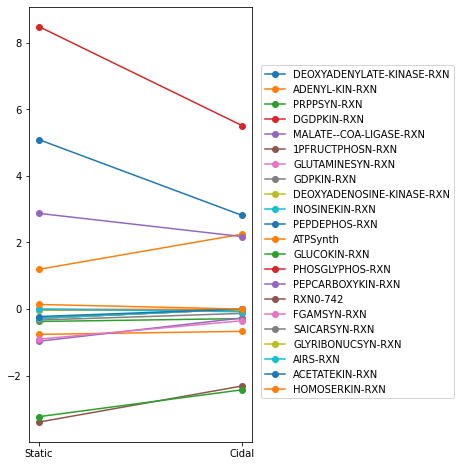

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\biomass_ATP_cidalvstatic.csv', index_col=0)
df = df[df['Static flux'] != df['Cidal flux']]

x = ["Static", "Cidal"]
fig, ax = plt.subplots(figsize=(4,8))
for reac, stat, cid in df.itertuples():
    ax.plot(x, [stat, cid], label=reac, marker='o')
ax.legend(loc=(1.04, 0.1))
plt.show()

In [ ]:
# Increase weighting on folate associated reactions

def folate_weight_scan(model: object, low=1.0, high=200.0, n=100, lp=None, flux_bounds=None, target=folate_reacs) -> (object, dict):
    """
    Performs a weighted LP scan on a set of defined reactions.

        Parameters:
            model (obj) : model
            low (float) : lowest flux point
            high (float): highest flux point
            n (int) : number of points
            lp (obj) : linear programme object
            target (str) : reaction to apply increasing flux
            flux_bounds (dict) : define flux bounds for lp

        Returns:
            rv (Object) : GNU plotting instance
            results (dict) : result of ATP scan [flux, reaction name, value]
    """
    rv = ScanRes()

    if not lp: 
        lp = model.GetLP()
        lp.SetObjective(model.sm.cnames)
    if flux_bounds:
        lp.SetFluxBounds(flux_bounds)

    step = (high - low) / (n-1)
    result = {"Weighting" : None, "reactions" : None, "Flux" : None}

    for weight in np.arange(low, high, step):
        lp.SetObjCoefsFromLists(target, [weight]*len(target))
        lp.Solve(PrintStatus=False) 
        if lp.IsStatusOptimal():
            sol = lp.GetPrimSol()
            rv.UpdateFromDic(sol)
            
            keys, values = zip(*sol.items())
            target_flux = [weight] * len(keys)

            for key, sub, typ in zip(list(result.keys()), (target_flux, keys, values), (float, str, float)):
                master = result[key]
                if master is not None:
                   master = np.concatenate((master, np.array(sub, dtype=np.dtype(typ))), axis=None)
                else:
                    master = np.array(sub, dtype=np.dtype(typ))
                result[key] = master
    rv.SetPlotX(target)
    rv.AddToPlot(rv.changers())
    return rv, result

lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **fd})
rv, result = folate_weight_scan(m, lp=lp, target=folate_reacs, low=0.1, high=4, n=20)
df = pd.DataFrame(result)
sns.lineplot(data=df[(df['reactions'].str.endswith('_tx')) & ~(df['reactions'].str.endswith('_bm_tx'))], x='Weighting', y='Flux', hue='reactions', style='reactions')
plt.show()
ATPScan.plot_metabolite(result, m, lim=0.1)

sns.lineplot(data=df[df['reactions'].isin(folate_reacs)], x='flux', y='values', hue='reactions', style='reactions')
plt.show()

In [ ]:
# weights used for analysis
steps = (15-1) / (100-1)
np.arange(1,15,steps)
array([ 1.        ,  1.14141414,  1.28282828,  1.42424242,  1.56565657,
        1.70707071,  1.84848485,  1.98989899,  2.13131313,  2.27272727,
        2.41414141,  2.55555556,  2.6969697 ,  2.83838384,  2.97979798,
        3.12121212,  3.26262626,  3.4040404 ,  3.54545455,  3.68686869,
        3.82828283,  3.96969697,  4.11111111,  4.25252525,  4.39393939,
        4.53535354,  4.67676768,  4.81818182,  4.95959596,  5.1010101 ,
        5.24242424,  5.38383838,  5.52525253,  5.66666667,  5.80808081,
        5.94949495,  6.09090909,  6.23232323,  6.37373737,  6.51515152,
        6.65656566,  6.7979798 ,  6.93939394,  7.08080808,  7.22222222,
        7.36363636,  7.50505051,  7.64646465,  7.78787879,  7.92929293,
        8.07070707,  8.21212121,  8.35353535,  8.49494949,  8.63636364,
        8.77777778,  8.91919192,  9.06060606,  9.2020202 ,  9.34343434,
        9.48484848,  9.62626263,  9.76767677,  9.90909091, 10.05050505,
       10.19191919, 10.33333333, 10.47474747, 10.61616162, 10.75757576,
       10.8989899 , 11.04040404, 11.18181818, 11.32323232, 11.46464646,
       11.60606061, 11.74747475, 11.88888889, 12.03030303, 12.17171717,
       12.31313131, 12.45454545, 12.5959596 , 12.73737374, 12.87878788,
       13.02020202, 13.16161616, 13.3030303 , 13.44444444, 13.58585859,
       13.72727273, 13.86868687, 14.01010101, 14.15151515, 14.29292929,
       14.43434343, 14.57575758, 14.71717172, 14.85858586])


# bacteriostatic:
weights= [1.707, 2.42, 3.96, 5.1, 13.4]
indexes = [1580, 3155, 6628, 9143, 27672]
# 
# bactericidal:
# 1, 1.36, 2.27, 2.72, 4.18, 5.18, 5.545, 7.36


def to_dict(df, weight):
       d = df[(df['Weighting'] == weight) & (df['reactions'].isin(changed))][['reactions', 'Flux']]
       d = d.set_index('reactions').T.to_dict('list')
       return {k:v[0] for k,v in d.items()}


indexes = [1180, 4155, 5640, 10392, 13659, 14843, 20767]
weights = [1.36, 2.27, 2.72, 4.18, 5.18, 5.545, 7.36]
weight1 = set(df[df['Weighting']==1]['reactions'].values)

for i, weight in zip(indexes, weights):
       weight2 = set(df[df['Weighting']==df.loc[i,'Weighting']]['reactions'].values)
       inweight1 = weight1-weight2
       inweight2 = weight2-weight1
       weight1 = weight2
       print(f"Weight {weight}:\nNew: {', '.join(inweight2)}\nOld:{', '.join(inweight1)}\n")



def to_dict_nochange(df, weight):
       d = df[(df['Weighting'] == weight)][['reactions', 'Flux']]
       d = d.set_index('reactions').T.to_dict('list')
       return {k:v[0] for k,v in d.items()}
#bactericidal
net_production = 0
net_loss = 0
reacs = []
for reac, flux in to_dict_nochange(df, df.loc[14843, 'Weighting']).items():
  if m.smx["ATP", reac].digits() != '0':
    flux = round(flux, 4)
    bal = int(m.smx["ATP", reac].digits())
    adjusted_flux = flux * bal
    reacs.append(f"{reac} {adjusted_flux}")
    if adjusted_flux > 0:
      net_production += adjusted_flux
    else:
      net_loss+= adjusted_flux
print(f"gain {net_production}; loss {net_loss}")
# gain 12.5; loss -12.5


In [ ]:
from scipy.spatial.distance import cosine, euclidean

# bacteriostatic
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **fd})
lp.SetFluxBounds({"Glc_mm_tx" : (0.0, 11.0)})
rv, result = folate_weight_scan(m, lp=lp, target=folate_reacs, low=1, high=15, n=100)

euclidean(rv['row1'], rv['row19'])
6.482250179169588

cosine(rv['row1'], rv['row19'])
0.017698...

# bactericidal
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**pur_bm_fd, **fd})
lp.SetFluxBounds({
    "Glc_mm_tx" : (0.0, 11.0),
    "Gly_aa_mm_tx" : (0.0, 66.0),
    "Met_aa_mm_tx" : (0.0, 33.5),
    "Ade_nt_mm_tx" : (0.0, 37.0)})
rv, result = folate_weight_scan(m, lp=lp, target=folate_reacs, low=1, high=10, n=100)

euclidean(rv['row1'], rv['row19'])
3.515982656108442

cosine(rv['row1'], rv['row19'])
0.010228857619928089

euc_range = []
cos_range = []

for num in range(2,20):
    euc_range.append(euclidean(rv['row1'], rv[f'row{num}']))
    cos_range.append(cosine(rv['row1'], rv[f'row{num}']))

fig, (ax1, ax2) = plt.subplots(2,1)
step = (4 - 1) / (20-1)
x = np.arange(1, 4, step)[1:]
ax1.plot(x, euc_range)
ax1.set(ylabel='Euclidean distance')

ax2.plot(x, cos_range)
ax2.set(xlabel='Weight', ylabel='Cosine distance')

ax1.minorticks_on()
ax2.minorticks_on()

ax1.grid(which='major')
ax1.grid(which='minor', linestyle='--', axis='x')
ax2.grid(which='major')
ax2.grid(which='minor', linestyle='--', axis='x')

plt.show()


changed_reacs = [cname for cname in rv.cnames if np.ptp(rv.GetCol(cname)) > 4.5e-01]
sns.lineplot(data=df[df['reactions'].isin(changed_reacs)], x='Weighting', y='Flux', hue='reactions', style='reactions')
plt.show()

# how many reactions pass the cutoff for a range of cut-off values
np.linspace(1e-7, 1, 20)
array([1.00000000e-07, 5.26316737e-02, 1.05263247e-01, 1.57894821e-01,
       2.10526395e-01, 2.63157968e-01, 3.15789542e-01, 3.68421116e-01,
       4.21052689e-01, 4.73684263e-01, 5.26315837e-01, 5.78947411e-01,
       6.31578984e-01, 6.84210558e-01, 7.36842132e-01, 7.89473705e-01,
       8.42105279e-01, 8.94736853e-01, 9.47368426e-01, 1.00000000e+00])
>>> [num_reac_changed(val) for val in np.linspace(1e-7, 1, 20)]
[56, 52, 45, 45, 45, 45, 45, 31, 29, 22, 17, 12, 11, 10, 7, 7, 6, 6, 5, 5]


## How many units of ATP are needed for 1 unit of folate?

In [ ]:
lp = m.GetLP()
lp.SetFixedFlux({**pur_bm_fd, **AdAA_fd, "MeTHF_bm_tx" : -1})
lp.SetObjective(m.sm.cnames)
lp.Solve()
sol = lp.GetPrimSol()

# Finding source of energy
net_production = 0
net_loss = 0
reacs = []
for reac, flux in sol.items():
  if m.smx["ATP", reac].digits() != '0':
    flux = round(flux, 4)
    bal = int(m.smx["ATP", reac].digits())
    adjusted_flux = flux * bal
    reacs.append(f"{reac} {adjusted_flux}")
    if adjusted_flux > 0:
      net_production += adjusted_flux
    else:
      net_loss+= adjusted_flux
print(f"gain {net_production}; loss {net_loss}")
# gain 20.43; loss -20.43
for s in reacs:
  print("---", s)

# --- GUANYL-KIN-RXN -1.0
# --- ADENYL-KIN-RXN -2.0
# --- RXN0-742 -1.0
# --- SHIKIMATE-KINASE-RXN -1.0
# --- PRPPSYN-RXN -1.0
# --- FGAMSYN-RXN -1.0
# --- SAICARSYN-RXN -1.0
# --- 1PFRUCTPHOSN-RXN -3.43
# --- DIHYDROFOLATESYNTH-RXN -1.0
# --- GLUTAMINESYN-RXN -3.0
# --- GLYRIBONUCSYN-RXN -1.0
# --- GDPKIN-RXN -1.0
# --- AIRS-RXN -1.0
# --- H2PTERIDINEPYROPHOSPHOKIN-RXN -1.0
# --- SUCCCOASYN-RXN 0.86
# --- PEPDEPHOS-RXN 2.86
# --- ATPSynth 8.85
# --- GLUCOKIN-RXN -1.0
# --- MALATE--COA-LIGASE-RXN 1.0
# --- PHOSGLYPHOS-RXN 5.86
# --- PEPCARBOXYKIN-RXN 1.0

## How is the solution synthesising ATP when ATPSynth is flux limited?

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, "MeTHF_bm_tx" : -1, "ATPSynth" : 1})
lp.Solve(PrintStatus=True)
# optimal
sol = lp.GetPrimSol()
# Finding source of energy used in LP solution...
net_production = 0
net_loss = 0
reacs = []
for reac, flux in sol.items():
  if m.smx["ATP", reac].digits() != '0':
    flux = round(flux, 4)
    bal = int(m.smx["ATP", reac].digits())
    adjusted_flux = flux * bal
    reacs.append(f"{reac} {adjusted_flux}")
    if adjusted_flux > 0:
      net_production += adjusted_flux
    else:
      net_loss+= adjusted_flux
print(f"gain {net_production}; loss {net_loss}")
# gain 22.583; loss -22.583
for s in reacs:
  print("---", s)
# --- GUANYL-KIN-RXN -1.0
# --- ADENYL-KIN-RXN -2.0
# --- PROPKIN-RXN 3.25
# --- RXN0-742 -1.0
# --- SHIKIMATE-KINASE-RXN -1.0
# --- PRPPSYN-RXN -1.0
# --- FGAMSYN-RXN -1.0
# --- SAICARSYN-RXN -1.0
# --- 1PFRUCTPHOSN-RXN -5.5833
# --- DIHYDROFOLATESYNTH-RXN -1.0
# --- GLUTAMINESYN-RXN -3.0
# --- GLYRIBONUCSYN-RXN -1.0
# --- GDPKIN-RXN -1.0
# --- AIRS-RXN -1.0
# --- H2PTERIDINEPYROPHOSPHOKIN-RXN -1.0
# --- PEPDEPHOS-RXN 7.1667
# --- ATPSynth 1.0
# --- GLUCOKIN-RXN -1.0
# --- PHOSGLYPHOS-RXN 10.1667
# --- PEPCARBOXYKIN-RXN 1.0

## How does the network respond to increasing ATP demand when ATP synthesis is restricted while synthesising folates?

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd})
lp.SetFluxBounds({"DIHYDROFOLATESYNTH-RXN" : (0.0001, 100)})
lp.SetFluxBounds({"ATPSynth" : {0, 20.43}})
rv, result = ATPScan.scan(m, lp=lp, target="ATPase", high=120)

# De novo folate biosynthesis: bactericidal vs. bacteriostatic trimethoprim conditions

## How can the network respond to increasing folate demand with realistic bactericidal conditions?

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**pur_bm_fd}) # do not block AdAA import
lp.SetFluxBounds({
    "Glc_mm_tx" : (0.0, 11.0),
    "Gly_aa_mm_tx" : (0.0, 66.0),
    "Met_aa_mm_tx" : (0.0, 33.5),
    "Ade_nt_mm_tx" : (0.0, 37.0)})
rv, result = ATPScan.scan(m, lp=lp, target="MeTHF_bm_tx", low=-8, high=-1)

## How can the network respond to increasing folate demand with realistic bactericidal conditions and biomass production?

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**pur_bm_fd}) # do not block AdAA import
lp.SetFluxBounds({
    "Glc_mm_tx" : (0.0, 11.0),
    "Gly_aa_mm_tx" : (0.0, 66.0),
    "Met_aa_mm_tx" : (0.0, 33.5),
    "Ade_nt_mm_tx" : (0.0, 37.0)})
lp.SetFixedFlux(fd)
rv, result = ATPScan.scan(m, lp=lp, target="MeTHF_bm_tx", low=-8, high=-1)

# Counteraction of trimethoprim by thymidine

## Can we model use thymidine to counteract trimethoprim action on thymidylate synthase?

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **{"DIHYDROFOLATEREDUCT-RXN" : 0, "dTTP_bm_tx" : -1}})
lp.Solve()

## Can we model use thymidine to counteract trimethoprim action?

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **{"DIHYDROFOLATEREDUCT-RXN" : 0, "MeTHF_bm_tx" : -1}})
lp.Solve()
# optimal
# dCTP exported from excess dUMP
# Requires 21.2884 units of ATP for 1 unit of folate

## Can thymidine counteract the synthesis of other biomass components affected by trimethoprim

In [ ]:
TMP_biomass = ["Met_AA_bm_tx", "His_AA_bm_tx", "dATP_bm_tx", "dGTP_bm_tx", "dTTP_bm_tx", "GTP_bm_tx", 
                "ATP_bm_tx", "Spermidine_bm_tx", "MeTHF_bm_tx", "AcCoA_bm_tx", "CoA_bm_tx", "SucCoA_bm_tx", 
                "FAD_bm_tx", "NAD_bm_tx", "NADH_bm_tx", "NADP_bm_tx", "NADPH_bm_tx", "Adenine_bm_tx", "Guanine_bm_tx", 
                "Xanthine_bm_tx", "Hypoxanthine_bm_tx"]

bm_folates = {fol_reac : 0 for fol_reac in folate_reacs}

lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **bm_folates})
for biomass_comp in TMP_biomass:
    lp.SetFixedFlux({biomass_comp : -1})
    lp.Solve(PrintStatus=False)
    stat = lp.IsStatusOptimal()
    print(f'{biomass_comp:18} --- {stat:10}')
    lp.ClearFluxConstraint(biomass_comp)

# Met_AA_bm_tx       ---          0
# His_AA_bm_tx       ---          0
# dATP_bm_tx         ---          0
# dGTP_bm_tx         ---          0
# dTTP_bm_tx         ---          1
# GTP_bm_tx          ---          0
# ATP_bm_tx          ---          0
# Spermidine_bm_tx   ---          0
# MeTHF_bm_tx        ---          0
# AcCoA_bm_tx        ---          0
# CoA_bm_tx          ---          0
# SucCoA_bm_tx       ---          0
# FAD_bm_tx          ---          0
# NAD_bm_tx          ---          0
# NADH_bm_tx         ---          0
# NADP_bm_tx         ---          0
# NADPH_bm_tx        ---          0
# Adenine_bm_tx      ---          0
# Guanine_bm_tx      ---          0
# Xanthine_bm_tx     ---          0
# Hypoxanthine_bm_tx ---          0
# Spermidine_bm_tx   ---          0
# MeTHF_bm_tx        ---          0
# AcCoA_bm_tx        ---          0
# CoA_bm_tx          ---          0
# SucCoA_bm_tx       ---          0
# FAD_bm_tx          ---          0
# NAD_bm_tx          ---          0
# NADH_bm_tx         ---          0
# NADP_bm_tx         ---          0
# NADPH_bm_tx        ---          0
# Adenine_bm_tx      ---          0
# Guanine_bm_tx      ---          0
# Xanthine_bm_tx     ---          0
# Hypoxanthine_bm_tx ---          0

## Response to increasing dGTP demand under different conditions

In [ ]:
distance_data = {
    "media" : [],
    "flux" : [],
    "euc_range" : [],
    "cos_range" : []
    }

def add_distances(rv):
    #need to check how the rv is structured

    for num in range(2,20):
        euc_range.append(euclidean(rv['row1'], rv[f'row{num}']))
        cos_range.append(cosine(rv['row1'], rv[f'row{num}']))

#bacteriostatic conditions - limiting purine biosynthesis from folate reactions
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd})
lp.SetFixedFlux({'ATPase' : 0})
lp.SetFluxBounds({'GART-RXN' : (0, 2), 'AICARTRANSFORM-RXN' : (0, 2), 'Glc_mm_tx' : (0.0, 11.0)})
rv, result = ATPScan.scan(m, low=-0.05, high=-3, lp=lp, target='dGTP_bm_tx')

# bacterioctatic with Adenine
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd})
lp.SetFixedFlux({'ATPase' : 0})
lp.SetFluxBounds({'GART-RXN' : (0, 2), 'AICARTRANSFORM-RXN' : (0, 2), 'Glc_mm_tx' : (0.0, 11.0), 'Ade_nt_mm_tx': (0.0, 37.0)})
rv, result = ATPScan.scan(m, low=-0.05, high=-20, lp=lp, target='dGTP_bm_tx')

# bacterioctatic with glycine
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd})
lp.SetFixedFlux({'ATPase' : 0})
lp.SetFluxBounds({'GART-RXN' : (0, 2), 'AICARTRANSFORM-RXN' : (0, 2), 'Glc_mm_tx' : (0.0, 11.0), 'Gly_aa_mm_tx' : (0.0, 66.0)})
rv, result = ATPScan.scan(m, low=-0.05, high=-3, lp=lp, target='dGTP_bm_tx')

#bactericidal conditions - limiting purine biosynthesis from folate reactions
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**pur_bm_fd})
lp.SetFixedFlux({'ATPase' : 0})
lp.SetFluxBounds({'GART-RXN' : (0, 2), 'AICARTRANSFORM-RXN' : (0, 2), **M9_flux_bounds})
rv, result = ATPScan.scan(m, low=-0.05, high=-20, lp=lp, target='dGTP_bm_tx')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.spatial.distance import cosine, euclidean

In [359]:
df = pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\dGTPScan_bacteriostatic_210623.xlsx', index_col=0)
df['condition'] = 'bacteriostatic'
df = pd.concat([df, pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\dGTPScan_bacteriostatic_glycine_210623.xlsx', index_col=0)])
df['condition'] = df['condition'].fillna('glycine')
df = pd.concat([df, pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\dGTPScan_bacteriostatic_adenine_210623.xlsx', index_col=0)])
df['condition'] = df['condition'].fillna('adenine')
df = pd.concat([df, pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\dGTPScan_bactericidal_210623.xlsx', index_col=0)])
df['condition'] = df['condition'].fillna('bactericidal')

df

,flux,reactions,values,condition
0,-0.050000,THREDEHYD-RXN,0.015264,bacteriostatic
1,-0.050000,2-OXOGLUTARATE-SYNTHASE-RXN,0.022236,bacteriostatic
2,-0.050000,RXN-6182,0.033333,bacteriostatic
3,-0.050000,GUANYL-KIN-RXN,0.050000,bacteriostatic
4,-0.050000,RXN0-6373,0.060767,bacteriostatic
...,...,...,...,...
4726,-18.186364,1.5.1.15-RXN,-4.695455,bactericidal
4727,-18.186364,TRIOSEPISOMERIZATION-RXN,-8.354545,bactericidal
4728,-18.186364,AMMONIUM_tx,-66.000000,bactericidal
4729,-18.186364,H2O_tx,-11.440909,bactericidal


In [360]:
df.to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\dGTPScans.xlsx')

In [402]:
pur_set1 = ['DGDPKIN-RXN', 'GDPREDUCT-RXN', 'GUANYL-KIN-RXN', 'GMP-REDUCT-RXN']
pur_set2 = ['INOSINEKIN-RXN', 'ADENODEAMIN-RXN', 'ADENPHOSPHOR-RXN']
pur_set3 = ['GMKALT-RXN', 'DEOXYGUANOSINE-KINASE-RXN', 'DEOXYGUANPHOSPHOR-RXN', 'GUANINE-DEAMINASE-RXN', 'RXN-7682', 'ADENINE-DEAMINASE-RXN', 'ADENPHOSPHOR-RXN']

purine_reacs = ['PRPPAMIDOTRANS-RXN', 'GART-RXN', 'AIRS-RXN', 'SAICARSYN-RXN', 'GLYRIBONUCSYN-RXN', 
    'IMPCYCLOHYDROLASE-RXN', 'AICARTRANSFORM-RXN', 'AICARSYN-RXN', 'RXN0-743', 
    'AIRCARBOXY-RXN', 'RXN0-742', 'GARTRANSFORMYL2-RXN', 'FGAMSYN-RXN']

folate_reacs = ['DIHYDROFOLATESYNTH-RXN', 'RXN-2881', '1.5.1.15-RXN', '1.5.1.20-RXN', 'GLYOHMETRANS-RXN',
 'RXN-5061', 'METHENYLTHFCYCLOHYDRO-RXN', 'RXN0-1862', 'FORMATETHFLIG-RXN', 'RXN-13909', 
 'GCVMULTI-RXN', 'THYMIDYLATESYN-RXN', 'GART-RXN', 'DIHYDROFOLATEREDUCT-RXN', 'AICARTRANSFORM-RXN', 
 'METHYLENETHFDEHYDROG-NADP-RXN', 'HOMOCYSMETB12-RXN', '5-FORMYL-THF-CYCLO-LIGASE-RXN', 
 '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN', 'FORMYLTHFDEFORMYL-RXN']

tca_reacs= ['1.2.1.25-RXN', '1.8.1.4-RXN', '2KETO-3METHYLVALERATE-RXN', '2OXOGLUTDECARB-RXN', '4.2.1.99-RXN', 'ACONITATEDEHYDR-RXN', 'ACONITATEHYDR-RXN',
 'CITSYN-RXN', 'FUMHYDR-RXN', 'ISOCITRATE-DEHYDROGENASE-NAD+-RXN', 'MALATE--COA-LIGASE-RXN', 'MALATE-DEH-RXN', 'RXN-14047', 'RXN-14971', 'RXN-15378',
 'RXN-7716', 'RXN-7719', 'RXN-8629', 'RXN0-1132', 'RXN0-1147', 'SUCCCOASYN-RXN', 'SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN',
 'ISOCITDEH-RXN', '2-OXOGLUTARATE-SYNTHASE-RXN', 'TETHYDPICSUCC-RXN', 'SUCCINYLDIAMINOPIMTRANS-RXN', 'SUCCDIAMINOPIMDESUCC-RXN', 'R601-RXN', 'METHYLISOCITRATE-LYASE-RXN', '2-METHYLCITRATE-DEHYDRATASE-RXN',
 '2-METHYLCITRATE-SYNTHASE-RXN', 'GLUTDEHYD-RXN', 'ASPAMINOTRANS-RXN', 'ISOCIT-CLEAV-RXN', 'MALATE-COA-LIGASE-RXN', 'MALYL-COA-LYASE-RXN'
 ]

etc_reacs = ["NADH_DH_ubi", "NADH_DH_meno", "CYTOCHROME-C-OXIDASE-RXN", "Succ_DH", "1.10.2.2-RXN", "RXN0-5268", "RXN0-5256", "ATPSynth", "RXN0-6369", "RXN-11039"]



In [50]:
# folate_reacs = ['DIHYDROFOLATESYNTH-RXN', 'RXN-2881', '1.5.1.15-RXN', '1.5.1.20-RXN', 'GLYOHMETRANS-RXN',
#  'RXN-5061', 'METHENYLTHFCYCLOHYDRO-RXN', 'RXN0-1862', 'FORMATETHFLIG-RXN', 'RXN-13909', 
#  'GCVMULTI-RXN', 'THYMIDYLATESYN-RXN', 'GART-RXN', 'DIHYDROFOLATEREDUCT-RXN', 'AICARTRANSFORM-RXN', 
#  'METHYLENETHFDEHYDROG-NADP-RXN', 'HOMOCYSMETB12-RXN', '5-FORMYL-THF-CYCLO-LIGASE-RXN', 
#  '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN', 'FORMYLTHFDEFORMYL-RXN']

In [403]:
dGTP_fol_abs = df[df['reactions'].isin(folate_reacs)].groupby(['condition', 'flux'])['values'].apply(lambda c : c.abs().sum()).reset_index()

In [404]:
dGTP_fol_abs[dGTP_fol_abs['condition']=='adenine']

,condition,flux,values
0,adenine,-9.396970,11.939394
1,adenine,-9.296465,9.929293
2,adenine,-9.195960,7.919192
3,adenine,-9.095455,5.909091
4,adenine,-8.994949,3.898990
5,adenine,-8.894444,1.888889


In [405]:
low=-0.05
high=-20
step = (high - low) / (100-1)
a = np.arange(-0.05, -20, step) 
a = a[a > -11.133333]


high=-10
step = (high - low) / (100-1)
b = np.arange(-0.05, -10, step) 
b = b[b > -8.89444]


a, b



(array([ -0.05      ,  -0.25151515,  -0.4530303 ,  -0.65454545,
         -0.85606061,  -1.05757576,  -1.25909091,  -1.46060606,
         -1.66212121,  -1.86363636,  -2.06515152,  -2.26666667,
         -2.46818182,  -2.66969697,  -2.87121212,  -3.07272727,
         -3.27424242,  -3.47575758,  -3.67727273,  -3.87878788,
         -4.08030303,  -4.28181818,  -4.48333333,  -4.68484848,
         -4.88636364,  -5.08787879,  -5.28939394,  -5.49090909,
         -5.69242424,  -5.89393939,  -6.09545455,  -6.2969697 ,
         -6.49848485,  -6.7       ,  -6.90151515,  -7.1030303 ,
         -7.30454545,  -7.50606061,  -7.70757576,  -7.90909091,
         -8.11060606,  -8.31212121,  -8.51363636,  -8.71515152,
         -8.91666667,  -9.11818182,  -9.31969697,  -9.52121212,
         -9.72272727,  -9.92424242, -10.12575758, -10.32727273,
        -10.52878788, -10.73030303, -10.93181818]),
 array([-0.05      , -0.15050505, -0.2510101 , -0.35151515, -0.4520202 ,
        -0.55252525, -0.6530303 , -0.753535

In [407]:
dGTP_fol_abs = pd.concat([dGTP_fol_abs, pd.DataFrame({
    "condition":'bactericidal',
    "flux":a,
    "values":0
}).sort_values('flux')])
dGTP_fol_abs = pd.concat([dGTP_fol_abs, pd.DataFrame({
    "condition":'adenine',
    "flux":b,
    "values":0
}).sort_values('flux')])

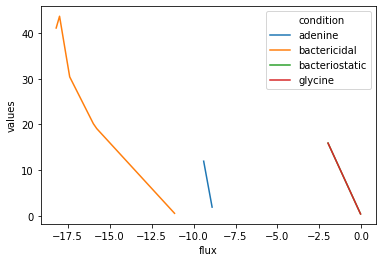

In [406]:
sns.lineplot(data=dGTP_fol_abs, x='flux', y='values', hue='condition')


In [408]:
dGTP_fol_abs['pathway'] = 'folates'

In [409]:
dGTP_fol_abs.to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\dGTPScans_fol_abs.xlsx')

In [ ]:
# Getting purine reactions
# from PRPP to IMP
purine_genes = ['purK', 'purE', 'purC', 'purB', 'purH', 'purM', 'purL', 'purN', 'purD', 'purF', 'purT']

UIDs = [gene['UNIQUE-ID'][0] for gene in db.dbs['GENE'].values()]
purine_reacs = []
for UID in UIDs:
	try:
		gene = db.dbs['GENE'][UID]['COMMON-NAME'][0]
	except KeyError:
		continue
	if gene in purine_genes:
		purine_reacs.append(db.dbs['GENE'][UID].GetReactions())


purine_reacs = [item for sublist in purine_reacs for item in sublist]

purine_reacs = [r['UNIQUE-ID'][0] for r in purine_reacs]


In [16]:
purine_reacs = ['PRPPAMIDOTRANS-RXN', 'GART-RXN', 'AIRS-RXN', 'SAICARSYN-RXN', 'GLYRIBONUCSYN-RXN', 
'IMPCYCLOHYDROLASE-RXN', 'AICARTRANSFORM-RXN', 'AMPSYN-RXN', 'AICARSYN-RXN', 'RXN0-743', 
'AIRCARBOXY-RXN', 'RXN0-742', 'GARTRANSFORMYL2-RXN', 'FGAMSYN-RXN']

In [410]:
dGTP_pur_abs = df[df['reactions'].isin(purine_reacs)].groupby(['condition', 'flux'])['values'].apply(lambda c : c.abs().sum()).reset_index()

In [400]:
dGTP_pur_abs['condition'].value_counts()

bactericidal      199
adenine            99
bacteriostatic     66
glycine            66
Name: condition, dtype: int64

In [413]:
dGTP_pur_abs = pd.concat([dGTP_pur_abs, pd.DataFrame({
    "condition":'bactericidal',
    "flux": np.arange(-0.05, -20, step),
    "values":0
}).sort_values('flux')])
dGTP_pur_abs = pd.concat([dGTP_pur_abs, pd.DataFrame({
    "condition":'adenine',
    "flux": np.arange(-0.05, -10, step),
    "values":0
}).sort_values('flux')])

In [436]:
dGTP_pur_abs['pathway'] = 'purine_biosynth'

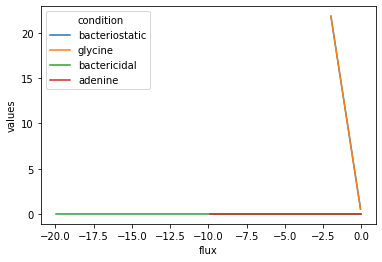

In [414]:
sns.lineplot(data=dGTP_pur_abs, x='flux', y='values', hue='condition')

In [415]:
dGTP_pur_abs.to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\dGTPScans_pur_abs.xlsx')

In [ ]:
# Getting TCA reactions

tca_genes = ['gltA', 'acnB', 'acnA', 'icd', 'icdE', 'icdA', 'sucA', 'sucB', 'lpd', 'lpdA', 'dhl', 'sucC', 'sucD', 'sdhD', 'sdhC', 'sdhB', 'sdhA', 'fumE', 'fumD', 'fumB', 'fumA', 'fumC', 'maeA', 'mdh']

UIDs = [gene['UNIQUE-ID'][0] for gene in db.dbs['GENE'].values()]
tca_reacs = []
for UID in UIDs:
	try:
		gene = db.dbs['GENE'][UID]['COMMON-NAME'][0]
	except KeyError:
		continue
	if gene in tca_genes:
		tca_reacs.append(db.dbs['GENE'][UID].GetReactions())


tca_reacs = [item for sublist in tca_reacs for item in sublist]

tca_reacs = [r['UNIQUE-ID'][0] for r in tca_reacs]

In [23]:
tca_reacs= ['1.2.1.25-RXN', '1.8.1.4-RXN', '2KETO-3METHYLVALERATE-RXN', '2OXOGLUTDECARB-RXN', '4.2.1.99-RXN', 'ACONITATEDEHYDR-RXN', 'ACONITATEHYDR-RXN',
 'CITSYN-RXN', 'FUMHYDR-RXN', 'ISOCITRATE-DEHYDROGENASE-NAD+-RXN', 'MALATE--COA-LIGASE-RXN', 'MALATE-DEH-RXN', 'RXN-14047', 'RXN-14971', 'RXN-15378',
 'RXN-7716', 'RXN-7719', 'RXN-8629', 'RXN0-1132', 'RXN0-1147', 'SUCCCOASYN-RXN', 'SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN']

In [416]:
dGTP_tca_abs = df[df['reactions'].isin(tca_reacs)].groupby(['condition', 'flux'])['values'].apply(lambda c : c.abs().sum()).reset_index()

In [378]:
dGTP_tca_abs[dGTP_tca_abs['condition']=='adenine']

,condition,flux,values,pathway
0,adenine,-9.396970,5.969697,tca
1,adenine,-9.296465,7.446970,tca
2,adenine,-9.195960,5.939394,tca
3,adenine,-9.095455,4.431818,tca
4,adenine,-8.994949,2.924242,tca
5,adenine,-8.894444,0.944444,tca


In [419]:
a = np.arange(-0.05, -20, step) 
a = a[a > -8.71515152]
a

array([-0.05      , -0.15050505, -0.2510101 , -0.35151515, -0.4520202 ,
       -0.55252525, -0.6530303 , -0.75353535, -0.8540404 , -0.95454545,
       -1.05505051, -1.15555556, -1.25606061, -1.35656566, -1.45707071,
       -1.55757576, -1.65808081, -1.75858586, -1.85909091, -1.95959596,
       -2.06010101, -2.16060606, -2.26111111, -2.36161616, -2.46212121,
       -2.56262626, -2.66313131, -2.76363636, -2.86414141, -2.96464646,
       -3.06515152, -3.16565657, -3.26616162, -3.36666667, -3.46717172,
       -3.56767677, -3.66818182, -3.76868687, -3.86919192, -3.96969697,
       -4.07020202, -4.17070707, -4.27121212, -4.37171717, -4.47222222,
       -4.57272727, -4.67323232, -4.77373737, -4.87424242, -4.97474747,
       -5.07525253, -5.17575758, -5.27626263, -5.37676768, -5.47727273,
       -5.57777778, -5.67828283, -5.77878788, -5.87929293, -5.97979798,
       -6.08030303, -6.18080808, -6.28131313, -6.38181818, -6.48232323,
       -6.58282828, -6.68333333, -6.78383838, -6.88434343, -6.98

In [420]:
dGTP_tca_abs = pd.concat([dGTP_tca_abs, 
    pd.DataFrame({
        "condition":'bactericidal',
        "flux": a,
        "values":0
        }).sort_values('flux'),
    pd.DataFrame({
        "condition":'glycine',
        "flux": dGTP_tca_abs[dGTP_tca_abs['condition']=='bacteriostatic']['flux'],
        "values":0
        }),
    pd.DataFrame({
        "condition":'adenine',
        "flux": a,
        "values":0
        }),   ])

In [437]:
dGTP_tca_abs['pathway'] = 'tca'

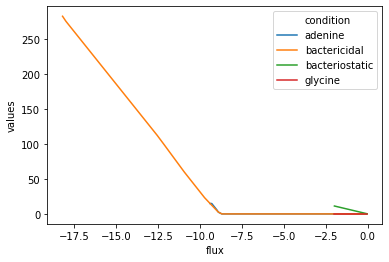

In [434]:
sns.lineplot(data=dGTP_tca_abs, x='flux', y='values', hue='condition')

In [422]:
dGTP_tca_abs.to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\dGTPScans_tca_abs.xlsx')


In [30]:
# ETC+OP reactions
etc_reacs = ["NADH_DH_ubi", "NADH_DH_memo", "CYTOCHROME-C-OXIDASE-RXN", "Succ_DH", "1.10.2.2-RXN", "RXN0-5268", "ATPSynth"]

In [423]:
dGTP_etc_abs = df[df['reactions'].isin(etc_reacs)].groupby(['condition', 'flux'])['values'].apply(lambda c : c.abs().sum()).reset_index()

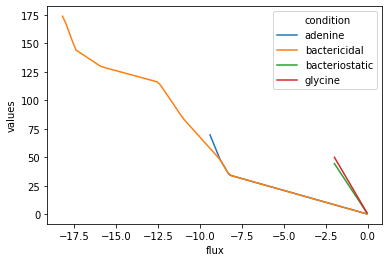

In [424]:
sns.lineplot(data=dGTP_etc_abs, x='flux', y='values', hue='condition')

In [427]:
dGTP_etc_abs.to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\dGTPScans_etc_abs.xlsx')


In [426]:
dGTP_etc_abs['pathway'] = 'etc'

In [69]:
df[df['reactions'].isin([
    'GUANYL-KIN-RXN',
    'DGDPKIN-RXN',
    'DEOXYGUANOSINE-KINASE-RXN',
    'GMKALT-RXN'
])]['condition'].value_counts()

bactericidal      235
adenine           206
glycine           132
bacteriostatic    132
Name: condition, dtype: int64

In [428]:
# pur_set1 = ['DGDPKIN-RXN', 'GDPREDUCT-RXN', 'GUANYL-KIN-RXN', 'GMP-REDUCT-RXN']
# pur_set2 = ['INOSINEKIN-RXN', 'ADENODEAMIN-RXN', 'ADENPHOSPHOR-RXN']
# # pur_set3 = ['ADENPHOSPHOR-RXN', 'ADENINE-DEAMINASE-RXN']
# pur_set3 = ['GMKALT-RXN', 'DEOXYGUANOSINE-KINASE-RXN', 'DEOXYGUANPHOSPHOR-RXN', 'GUANINE-DEAMINASE-RXN', 'RXN-7682', 'ADENINE-DEAMINASE-RXN', 'ADENPHOSPHOR-RXN']

dGTP_pursalv_abs = pd.DataFrame({'flux' : [], 'values' : [], 'condition' : [], 'rset':[]})

for i, rset in enumerate([pur_set1, pur_set2, pur_set3],start=1):
    _df = df[df['reactions'].isin(rset)].groupby(['condition', 'flux'])['values'].apply(lambda c : c.abs().sum()).reset_index()
    _df['rset'] = int(i)
    dGTP_pursalv_abs = pd.concat([dGTP_pursalv_abs, _df])
dGTP_pursalv_abs['pathway'] = 'purine_salvage'

In [429]:
dGTP_abs['rset'].value_counts()

0.0    1740
1.0     317
3.0     185
2.0     132
Name: rset, dtype: int64

In [430]:
dGTP_abs_total = df.groupby(['condition', 'flux'])['values'].apply(lambda c : c.abs().sum()).reset_index()
dGTP_abs_total['pathway'] = 'Total'
# dGTP_abs_total['rset'] = np.NaN

In [392]:
dGTP_pursalv_abs['rset'].value_counts()

1.0    317
3.0    185
2.0    132
Name: rset, dtype: int64

In [432]:
dGTP_pursalv_abs.to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\dGTPScans_pursalv_abs.xlsx')

In [438]:
dGTP_abs = pd.concat([dGTP_abs_total,dGTP_fol_abs, dGTP_pur_abs, dGTP_pursalv_abs, dGTP_etc_abs, dGTP_tca_abs])
dGTP_abs['rset'] = dGTP_abs['rset'].fillna(0)
dGTP_abs.to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\dGTPScans_abs.xlsx')

In [64]:
dGTPScans = pd.read_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\dGTPScans\dGTPScans_abs.xlsx', index_col=0)
dGTPScans.groupby(['condition', 'flux','pathway'])['values'].sum().reset_index().to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\dGTPScans\dGTPScans_abs.csv')

In [435]:
dGTP_abs['pathway'].value_counts()

purine_salvage     634
Total              317
etc                317
folates            317
purine_biosynth    132
tca                119
Name: pathway, dtype: int64

## Modelling methionine synthesis

In [ ]:
met_reac = 'HOMOCYSMETB12-RXN'

lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, met_reac : 0})
for biomass_comp in fd:
    lp.SetFixedFlux({biomass_comp : -1})
    lp.Solve(PrintStatus=False)
    stat = not lp.IsStatusOptimal()
    print(f'{biomass_comp:18} --- {stat:10}')
    lp.ClearFluxConstraint(biomass_comp)
# only Met_AA_bm_tx and spermidine_bm_tx

lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd})
for biomass_comp in fd:
    lp.SetFixedFlux({biomass_comp : -1})
    lp.Solve(PrintStatus=False)
    sol = lp.GetPrimSol()
    stat = 1 if met_reac in sol else 0
    print(f'{biomass_comp:18} --- {stat:10}')
    lp.ClearFluxConstraint(biomass_comp)
# only Met_AA_bm_tx and spermidine_bm_tx

## Thymidine restores the folate pool

In [ ]:
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **fd, 'Thy_mm_tx' : 0})
lp.Solve()
sol = lp.GetPrimSol()
pd.DataFrame.from_dict(sol, orient='index', columns=['Flux']).to_csv(r"../Data/Biomass_M9_LP.csv")

lp.SetFixedFlux({'DIHYDROFOLATEREDUCT-RXN' : 0})
lp.ClearFluxConstraint('Thy_mm_tx')
lp.Solve()
sol = lp.GetPrimSol()
pd.DataFrame.from_dict(sol, orient='index', columns=['Flux']).to_csv(r"../Data/Biomass_M9_+Thy-DHFR_LP.csv")


In [111]:
thy = pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\Biomass_M9_LP.csv')
thy['condition']='M9'

thy = pd.concat([thy, pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\Biomass_M9_+Thy-DHFR_LP.csv')])
thy['condition']= thy['condition'].fillna('Thy')

thy = thy.rename(columns={'Unnamed: 0': 'reactions'})
thy = thy[thy['reactions'].isin(folate_reacs)].reset_index().drop(columns='index')
thy.loc[len(thy)] = ['DIHYDROFOLATEREDUCT-RXN', 0, 'Thy']

thy

,reactions,Flux,condition
0,METHYLENETHFDEHYDROG-NADP-RXN,1.437669,M9
1,1.5.1.20-RXN,-0.138413,M9
2,GART-RXN,0.275933,M9
3,DIHYDROFOLATEREDUCT-RXN,-0.016854,M9
4,AICARTRANSFORM-RXN,0.341248,M9
5,THYMIDYLATESYN-RXN,0.015949,M9
6,METHENYLTHFCYCLOHYDRO-RXN,1.437669,M9
7,3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN,0.000420,M9
8,FORMYLTHFDEFORMYL-RXN,0.820487,M9
9,DIHYDROFOLATESYNTH-RXN,0.000904,M9


In [145]:
thycomp = pd.pivot_table(thy, values=['reactions', 'Flux'], columns='condition', index='reactions')
thycomp.droplevel(0,axis=1).reset_index()
# .to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\thy_folates.csv')

condition,reactions,M9,Thy
0,1.5.1.20-RXN,-0.138413,-0.138413
1,3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN,0.000420,0.000420
2,AICARTRANSFORM-RXN,0.341248,0.341248
3,DIHYDROFOLATEREDUCT-RXN,-0.016854,0.000000
4,DIHYDROFOLATESYNTH-RXN,0.000904,0.000904
5,FORMYLTHFDEFORMYL-RXN,0.820487,0.837341
6,GART-RXN,0.275933,0.275933
7,GLYOHMETRANS-RXN,1.592451,1.592451
8,HOMOCYSMETB12-RXN,0.137509,0.137509
9,METHENYLTHFCYCLOHYDRO-RXN,1.437669,1.454523


In [113]:
thy.to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\thy_folates.csv')

## Introducing in vivo data

In [ ]:
import pandas as pd 
import string
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.font_manager as fm 

from statsmodels.formula.api import ols, logit
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.factorplots import interaction_plot
# import statsmodels as sm
from statsmodels.api import graphics as sm
from statsmodels.stats.api import het_breuschpagan
from statsmodels.compat import lzip

In [ ]:
time = [30, 45, 60, 75, 85, 95, 105, 115, 125, 135, 145, 155]

def read_data(fp, media, alt=True):
    flu_data = {
        "Media" : [],
        "Group" : [],
        "Time (minutes)" : [],
        "Absorbance (OD600)" : []
        }
    
    df = pd.read_excel(fp, skiprows=15, index_col=0)

    for column, t in zip(range(1,13), time):
        sl = df[column]
        flu_data['Media'] += [media]*8
        flu_data["Group"] += ["Control"]*4 + ["Treated"]*4
        flu_data["Time (minutes)"] += [t]*8
        if alt:
            flu_data["Absorbance (OD600)"] += list(sl.values)[::2] + list(sl.values)[1::2]
        else:
            flu_data["Absorbance (OD600)"] += list(sl.values)[:4] + list(sl.values)[4:]
    flu_df = pd.DataFrame(flu_data)
    return flu_df

fp = r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\Data\ATP-assays\\"
assays = {
    "M9" : "08.02.2023\ABS.xlsx",
    "Gly" : "18.05.2023\ABS.xlsx",
    "AdAA" : "28.04.2022\ABS.xlsx"
    }

df = pd.DataFrame()

for assay, f in assays.items():
    alt = True
    data = read_data(fp+f, assay, alt)
    df = pd.concat([df,data])

### Making a singular linear model for all absorbance data (excluding baseline)

In [ ]:
data = df.groupby(["Media", "Group", "Time (minutes)"])['Absorbance (OD600)'].mean().reset_index()
data['CI'] = df.groupby(["Media", "Group", "Time (minutes)"])['Absorbance (OD600)'].sem().mul(1.96).reset_index()['Absorbance (OD600)']
data.to_excel(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\manuscripts\TMP-Rx ATP-bio\FigS1.xlsx")

In [ ]:
lm_df = df[~(df['Time (minutes)']<=60)].rename(columns={'Time (minutes)' : 'Time', 'Absorbance (OD600)' : 'OD'})
lm_df['Cells'] = lm_df.apply(lambda x : (11.1*10**8)*(.08 if x.Time <= 60 else 0.09)*x.OD, axis=1)
sns.lineplot(data=lm_df, x='Time', y='Cells', hue='Media', style='Group')

In [ ]:
lm_abs = ols("Cells~Time * C(Group) * C(Media)", data=lm_df).fit()
lm_abs.summary()

In [ ]:
lm_abs.params

In [ ]:
plt.plot(np.arange(1,160),lm_abs.predict(pd.DataFrame({'Time' : np.arange(1,160), 'Group' : 'Treated', 'Media' : 'M9'})))

In [ ]:
lm_abs.save(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ABS_lm.lm")

In [ ]:
sns.lmplot(data=lm_df, x='Time', y='Cells', hue='Group', col='Media')

In [ ]:
qqplot(lm_abs.resid, line='s')

In [ ]:
plt.scatter(lm_abs.fittedvalues, lm_abs.resid)
plt.axhline(y=0)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

In [ ]:
plt.figure()
cooks = lm_abs.get_influence().cooks_distance[0]
plt.stem(range(len(cooks)), cooks)
plt.xlabel('Observation Number')
plt.ylabel("Cook's Distance")

In [ ]:
# Scale-location plot

# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

lm_fitted_y = lm_abs.fittedvalues
model_norm_residuals = lm_abs.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

# plotting
scl_loc = plt.figure()
plt.scatter(lm_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(lm_fitted_y, model_norm_residuals_abs_sqrt,
    scatter=False,
    ci=False,
    lowess=True,
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
scl_loc.axes[0].set_title('Scale-Location')
scl_loc.axes[0].set_xlabel('Fitted values')
scl_loc.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    scl_loc.axes[0].annotate(i,
        xy=(model_fitted_y[i],
            model_norm_residuals_abs_sqrt[i]))

In [ ]:
lzip(['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value'], het_breuschpagan(lm_abs.resid, lm_abs.model.exog))

### Making a singular linear model for all luminescence data (excluding baseline measurements)

In [ ]:
lm_df = df[~(df['Time (minutes)']<=60)].rename(columns={"ATP (RLU $x10^4$)" : "ATP", "Time (minutes)" : "Time"})
lm_df['ATP'] = lm_df['ATP']*10000
lm_atp = ols("ATP~Time * C(Group) * C(Media)", data=lm_df).fit()
lm_atp.params

In [ ]:
lm_atp.summary().tables[1]

In [ ]:
lm_atp.save(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_lm.lm")

In [ ]:
sns.lmplot(data=lm_df, x='Time', y='ATP', hue='Group', col='Media')

In [ ]:
qqplot(lm_atp.resid, line='s')

In [ ]:
plt.scatter(lm_atp.fittedvalues, lm_atp.resid)
plt.axhline(y=0)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

In [ ]:
plt.figure()
cooks = lm_atp.get_influence().cooks_distance[0]
plt.stem(range(len(cooks)), cooks)
plt.xlabel('Observation Number')
plt.ylabel("Cook's Distance")

In [ ]:
# Scale-location plot

# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

lm_fitted_y = lm_atp.fittedvalues
model_norm_residuals = lm_atp.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

# plotting
scl_loc = plt.figure()
plt.scatter(lm_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(lm_fitted_y, model_norm_residuals_abs_sqrt,
    scatter=False,
    ci=False,
    lowess=True,
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
scl_loc.axes[0].set_title('Scale-Location')
scl_loc.axes[0].set_xlabel('Fitted values')
scl_loc.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    scl_loc.axes[0].annotate(i,
        xy=(model_fitted_y[i],
            model_norm_residuals_abs_sqrt[i]))

In [ ]:
lzip(['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value'], het_breuschpagan(lm_atp.resid, lm_atp.model.exog))

## Incorporating in vivo data

In [23]:
# no longer use these, use the saved linear models instead
lm_eqs = {
    "Media"     : ['M9', 'Gly', 'AdAA', 'M9', 'Gly', 'AdAA', 'M9', 'Gly', 'AdAA', 'M9', 'Gly', 'AdAA'],
    "Group"     : ['Control', 'Control', 'Control', 'TMP', 'TMP', 'TMP', 'Control', 'Control', 'Control', 'TMP', 'TMP', 'TMP'],
    "Measure"   : ['ABS', 'ABS', 'ABS', 'ABS', 'ABS', 'ABS', 'LUM', 'LUM', 'LUM', 'LUM', 'LUM', 'LUM'],
    "Intercept" : [0.0436, 0.0446, 0.0431, 0.0672, 0.0554, 0.0479, -5911.6232, 3729.3723, 5930.2698, 1851.3861, 2107.9812, 2.101e04],
    "Slope"     : [0.0003, 0.0002, 0.0003, 5.833e-06, 8.75e-05, 0.0002, 969.104, 608.2231, 509.6524, 161.8983, 102.5429, 338.4279]
    }

lm_eqs_df = pd.DataFrame(lm_eqs)
lm_eqs_df

,Media,Group,Measure,Intercept,Slope
0,M9,Control,ABS,0.0436,0.000300
1,Gly,Control,ABS,0.0446,0.000200
2,AdAA,Control,ABS,0.0431,0.000300
3,M9,TMP,ABS,0.0672,0.000006
4,Gly,TMP,ABS,0.0554,0.000087
5,AdAA,TMP,ABS,0.0479,0.000200
6,M9,Control,LUM,-5911.6232,969.104000
7,Gly,Control,LUM,3729.3723,608.223100
8,AdAA,Control,LUM,5930.2698,509.652400
9,M9,TMP,LUM,1851.3861,161.898300


In [ ]:
gr_bm_data = {
    "Media" : [],
    "Group" : [],
    'Time' : [],
    'Measure' : [], # accumulated biomass or ATP
    "Value" : []
    }

time = [30, 45, 60, 75, 85, 95, 105, 115, 125, 135, 145, 155]

# control_slopes = {'M9' : 0.0003, 'Gly' : 0.0002, 'AdAA' : 0.0003}

for media,group,measure in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated'], ['ABS']):
        accum_bm = {bmtx : 0 for bmtx in fd}
        prev_time = 29
        slope = lm_eqs['ABS'][media]['Control']['Slope']

        fd = EcoliBiomass.FluxDic(m, gr=slope)

        for t in time:
            dt = t-prev_time
            prev_time = t

            if group == 'Treated' and t == 75:
                slope = lm_eqs['ABS'][media]['Treated']['Slope']
                fd = EcoliBiomass.FluxDic(m, gr=slope)

            for bmtx, v in fd.items():
                accum_bm[bmtx] += abs(v) * dt
            
            total_accum_biomass = sum(accum_bm.values())

            gr_bm_data['Media'] += [media, media]
            gr_bm_data['Group'] += [group, group]
            gr_bm_data['Time'] += [t, t]
            gr_bm_data['Measure'] += ['Biomass', 'ATP']
            gr_bm_data['Value'] += [total_accum_biomass, accum_bm['ATP_bm_tx']]

pd.DataFrame(gr_bm_data).to_csv(r'../Data/growthrate_on_biomass.csv')

## Introducing maintenance ATP
mATP_tx:\
&nbsp;&nbsp;&nbsp;"x_mATP" -> "ATP"\
&nbsp;&nbsp;&nbsp;~


In [ ]:
def scan_mATP_weighting(model: object, low=1.0, high=80, n=80, lp=None, target="mATP_tx") -> dict:
    """
    Perform an mATP weight scan on a Linear Programme.

        Parameters:
            model (obj) : model
            low (float) : lowest flux point
            high (float): highest flux point
            n (int) : number of points
            lp (obj) : linear programme object
            target (str) : reaction to apply increasing flux

        Returns:
            results (dict) : result of mATP scan [flux, reaction name, value]
    """

    step = (high - low) / (n-1)
    mATP_data = {"weight" : [], "value" : []}

    for weight in np.arange(low, high, step):
        lp.SetObjCoef(target, weight)
        lp.Solve(PrintStatus=False) 
        if lp.IsStatusOptimal():
            sol = lp.GetPrimSol()
            mATP_data['weight'].append(weight)
            if target in sol:
                mATP_data['value'].append(sol[target])
            else:
                mATP_data['value'].append(0)
    return mATP_data


M9 Control 5685.656213109432
M9 Treated 1555.259240017667
Gly Control 2852.918520627432
Gly Treated 69.56776693070219
AdAA Control 1338.3258515997231
AdAA Treated 853.522317841672

#bacteriostatic conditions - limiting purine biosynthesis from folate reactions
lp = m.GetLP()
fd = EcoliBiomass.FluxDic(m, gr=36628.8)
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **fd, 'mATP_bm_tx' : -5685.6})
result = scan_mATP_weighting(m, low=1, high=121, n=121, lp=lp)
df = pd.DataFrame(result)
df.to_csv('../Data/mATP_M9_weight.csv')

# bacterioctatic with glycine
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
fd = EcoliBiomass.FluxDic(m, gr=29531.7)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **fd, 'mATP_bm_tx' : -2852.9})
lp.ClearFluxConstraint('Gly_aa_mm_tx')
result = scan_mATP_weighting(m, low=1, high=121, n=121, lp=lp)
df = pd.DataFrame(result)
df.to_csv('../Data/mATP_Gly_weight.csv')

#bactericidal conditions - limiting purine biosynthesis from folate reactions
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
fd = EcoliBiomass.FluxDic(m, gr=34368.3)
lp.SetFixedFlux({**pur_bm_fd, **fd, 'mATP_bm_tx' : -1338.3})
result = scan_mATP_weighting(m, low=1, high=121, n=121, lp=lp)
df = pd.DataFrame(result)
df.to_csv('../Data/mATP_AdAA_weight.csv')

### Checking how increasing weighting of folates enables mATP import

In [ ]:
def folate_weight_scan(model: object, low=1.0, high=200.0, n=100, lp=None, folate_reacs=folate_reacs, target='mATP_tx') -> dict:
    """
    Performs a weighted LP scan on a set of defined reactions.

        Parameters:
            model (obj) : model
            low (float) : lowest flux point
            high (float): highest flux point
            n (int) : number of points
            lp (obj) : linear programme object
            target (str) : reaction to apply increasing flux

        Returns:
            results (dict) : result of ATP scan [flux, reaction name, value]
    """

    step = (high - low) / (n-1)
    mATP_data = {"weight" : [], "value" : []}

    for weight in np.arange(low, high, step):
        lp.SetObjCoefsFromLists(folate_reacs, [weight]*len(folate_reacs))
        lp.Solve(PrintStatus=False) 
        if lp.IsStatusOptimal():
            sol = lp.GetPrimSol()
            mATP_data['weight'].append(weight)
            if target in sol:
                mATP_data['value'].append(sol[target])
            else:
                mATP_data['value'].append(0)
    return mATP_data


#bacteriostatic conditions - limiting purine biosynthesis from folate reactions
lp = m.GetLP()
fd = EcoliBiomass.FluxDic(m, gr=36628.8)
lp.SetObjective(m.sm.cnames)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **fd, 'mATP_bm_tx' : -5685.6})
lp.SetObjCoef('mATP_tx', 98)
result = folate_weight_scan(m, low=1, high=121, n=121, lp=lp)
df = pd.DataFrame(result)
df.to_csv('../Data/mATP-fol_M9_weight.csv')

# bacterioctatic with glycine
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
fd = EcoliBiomass.FluxDic(m, gr=29531.7)
lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **fd, 'mATP_bm_tx' : -2852.9})
lp.ClearFluxConstraint('Gly_aa_mm_tx')
lp.SetObjCoef('mATP_tx', 84)
result = folate_weight_scan(m, low=1, high=121, n=121, lp=lp)
df = pd.DataFrame(result)
df.to_csv('../Data/mATP-fol_Gly_weight.csv')

#bactericidal conditions - limiting purine biosynthesis from folate reactions
lp = m.GetLP()
lp.SetObjective(m.sm.cnames)
fd = EcoliBiomass.FluxDic(m, gr=34368.3)
lp.SetFixedFlux({**pur_bm_fd, **fd, 'mATP_bm_tx' : -1338.3})
lp.SetObjCoef('mATP_tx', 33)
result = folate_weight_scan(m, low=1, high=121, n=121, lp=lp)
df = pd.DataFrame(result)
df.to_csv('../Data/mATP-fol_AdAA_weight.csv')

In [30]:
df = pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\mATP_M9_weight.csv', index_col=0)
df['condition'] = 'M9'
df = pd.concat([df, pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\mATP_Gly_weight.csv', index_col=0)])
df['condition'] = df['condition'].fillna('Gly')
df = pd.concat([df, pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\mATP_AdAA_weight.csv', index_col=0)])
df['condition'] = df['condition'].fillna('AdAA')
df['reaction'] = 'mATP'
df = pd.concat([df, pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\mATP-fol_M9_weight.csv', index_col=0)])
df['condition'] = df['condition'].fillna('M9')
df = pd.concat([df, pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\mATP-fol_Gly_weight.csv', index_col=0)])
df['condition'] = df['condition'].fillna('Gly')
df = pd.concat([df, pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\mATP-fol_AdAA_weight.csv', index_col=0)])
df['condition'] = df['condition'].fillna('AdAA')
df['reaction'] = df['reaction'].fillna('Folates')
df.to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\mATP_weightscan.xlsx')
df

,weight,value,condition,reaction
0,1.0,26151.789405,M9,mATP
1,2.0,26151.789405,M9,mATP
2,3.0,26151.789405,M9,mATP
3,4.0,26151.789405,M9,mATP
4,5.0,26151.789405,M9,mATP
...,...,...,...,...
115,116.0,0.000000,AdAA,Folates
116,117.0,0.000000,AdAA,Folates
117,118.0,0.000000,AdAA,Folates
118,119.0,0.000000,AdAA,Folates


In [29]:
df[(df['condition']=='M9') & (df['reaction']=='Folates')]['weight']

0        1.0
1        2.0
2        3.0
3        4.0
4        5.0
       ...  
155    156.0
156    157.0
157    158.0
158    159.0
159    160.0
Name: weight, Length: 160, dtype: float64

In [37]:
df[df['reaction']=='Folates'].groupby('condition')['value'].max()

condition
AdAA    0.000000
Gly     0.375933
M9      0.375933
Name: value, dtype: float64

In [39]:
df[(df['reaction']=='Folates') & (df['value'] >= 0.375933)]

,weight,value,condition,reaction
9,10.0,0.375933,M9,Folates
10,11.0,0.375933,M9,Folates
11,12.0,0.375933,M9,Folates
12,13.0,0.375933,M9,Folates
13,14.0,0.375933,M9,Folates
...,...,...,...,...
115,116.0,0.375933,Gly,Folates
116,117.0,0.375933,Gly,Folates
117,118.0,0.375933,Gly,Folates
118,119.0,0.375933,Gly,Folates


### Adjusting in vivo ATP to mATP

In [44]:
def LUM_to_ATPperCell(time_point, media, group):
    OD_cell_conc = 11.1 # 10^8 cells per mL per OD (Volkmer & Heinemann, 2011; PLOSone)
    volume = 0.09 #mL
    # adjustment_factor = 1000

    LUM_slope = lm_eqs_df[(lm_eqs_df['Media']==media) & (lm_eqs_df['Group']==group) & (lm_eqs_df['Measure']=='LUM')]['Slope'].values[0]
    _df = lm_eqs_df[(lm_eqs_df['Media']==media) & (lm_eqs_df['Group']==group) & (lm_eqs_df['Measure']=='ABS')]
    intercept = _df['Intercept'].values[0]
    slope = _df['Slope'].values[0]

    OD = (slope * time_point) + intercept # Calculate OD using the linear equation from the OD model
    num_cells = OD_cell_conc * 10**8 * volume * OD # convert OD into number of cells
    LUM_per_cell_per_min = LUM_slope / num_cells # calculate fluorescence per cell

    return LUM_per_cell_per_min

# ATP bm tx
ATP_bm = 0.10935065348045919 * 0.0003

LUM_to_ATPperCell(30, 'M9', 'Control') - ATP_bm


0.00015161953286728318

In [39]:
ATP_bm_data = {
    "Media" : [],
    "Group" : [],
    'Time' : [],
    'Measure' : [], # total, ATP, or mATP
    "Value" : []
    }

time = [30, 45, 60, 75, 85, 95, 105, 115, 125, 135, 145, 155]
ATP_bm = 0.10935065348045919
control_slopes = {'M9' : 0.0003, 'Gly' : 0.0002, 'AdAA' : 0.0003}

for media, group, measure, _, slope in zip(*lm_eqs.values()):
    if measure == 'ABS':
        accum_bm = {'total' : 0, 'ATP' : 0, 'mATP' : 0}
        prev_time = 29

        for t in time:
            dt = t-prev_time
            prev_time = t

            if group == 'TMP' and t <= 60: 
                _slope = control_slopes[media]
                total_ATP_adj = LUM_to_ATPperCell(t, media, 'Control') * dt
            else:
                _slope = slope
                total_ATP_adj = LUM_to_ATPperCell(t, media, group) * dt

            ATP_bm_adj = ATP_bm * _slope * dt            
            mATP = total_ATP_adj - ATP_bm_adj

            accum_bm['total'] += total_ATP_adj
            accum_bm['ATP'] += ATP_bm_adj
            accum_bm['mATP'] += mATP
            
            ATP_bm_data['Media'] += [media, media, media]
            ATP_bm_data['Group'] += [group, group, group]
            ATP_bm_data['Time'] += [t, t, t]
            ATP_bm_data['Measure'] += ['Total', 'ATP', 'mATP']
            ATP_bm_data['Value'] += [accum_bm['total'], accum_bm['ATP'], accum_bm['mATP']]

In [41]:
pd.DataFrame(ATP_bm_data).to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_output.xlsx')

### Experimenting with combined linear models rather than individual model for each media

In [1]:
from statsmodels.formula.api import ols, logit
from statsmodels.regression.linear_model import OLSResults
from itertools import product

In [2]:
atp_lm = OLSResults.load(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_lm.lm")
abs_lm = OLSResults.load(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ABS_lm.lm")

In [10]:
abs_lm.predict(pd.DataFrame({'Time' : [0], 'Group' : 'Control', 'Media' : 'M9'})).to_list(), 11.1 * 10**8 * 0.08 * 0.02 # convert OD into number of cells

([3642534.871244604], 1776000.0)

In [37]:
model_predictions = {
    "Media" : [],
    "Group" : [],
    'Time' : [],
    'Measure' : [], # ABS or ATP
    "Value" : []
    }

models = {
    "ATP" : atp_lm,
    "ABS" : abs_lm
    }

time = [30, 45, 60, 75, 85, 95, 105, 115, 125, 135, 145, 155]
lt = len(time)
# ATP_bm = 0.10935065348045919
# control_slopes = {'M9' : 0.0003, 'Gly' : 0.0002, 'AdAA' : 0.0003}

for media,group,measure in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated'], ['ABS', 'ATP']):

    predictions = models[measure].predict(pd.DataFrame({'Time' : time, 'Group' : group, 'Media' : media})).to_list()
        
    model_predictions['Media'] += [media]*lt
    model_predictions['Group'] += [group]*lt
    model_predictions['Time'] += time
    model_predictions['Measure'] += [measure]*lt
    model_predictions['Value'] += predictions

In [38]:
pd.DataFrame(model_predictions).to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\model_predictions.csv')

### Slopes

In [4]:
lm_eqs = {
    'ATP' : {media : {'Control' : {}, 'Treated' : {}} for media in ['M9', 'Gly', 'AdAA']},
    'ABS' : {media : {'Control' : {}, 'Treated' : {}} for media in ['M9', 'Gly', 'AdAA']}
    }

for media,group,measure in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated'], ['ABS', 'ATP']):
    if measure == 'ABS':
        predictions = abs_lm.predict(pd.DataFrame({'Time' : [0, 30, 155], 'Group' : group, 'Media' : media})).to_list()
    if measure == 'ATP':
        predictions = atp_lm.predict(pd.DataFrame({'Time' : [0, 30, 155], 'Group' : group, 'Media' : media})).to_list()
    slope = (predictions[2] - predictions[1]) / (155-30)
    lm_eqs[measure][media][group] = {'Slope' : slope, 'Intercept' : predictions[0]}
lm_eqs

{'ATP': {'M9': {'Control': {'Slope': 969.1040414878278,
    'Intercept': -5911.623211730586},
   'Treated': {'Slope': 161.89833333333664, 'Intercept': 1851.3861111104688}},
  'Gly': {'Control': {'Slope': 608.2231044349039,
    'Intercept': 3729.3723175968084},
   'Treated': {'Slope': 102.54291666666863, 'Intercept': 2107.981249999273}},
  'AdAA': {'Control': {'Slope': 509.6523605150158,
    'Intercept': 5930.2698497856545},
   'Treated': {'Slope': 338.42791666666983, 'Intercept': 21011.67847222174}}},
 'ABS': {'M9': {'Control': {'Slope': 36628.80901287528,
    'Intercept': 3642534.871244604},
   'Treated': {'Slope': 582.7499999996498, 'Intercept': 6712308.749999978}},
  'Gly': {'Control': {'Slope': 29531.716738196545,
    'Intercept': 3755682.6180257564},
   'Treated': {'Slope': 8741.24999999927, 'Intercept': 5532656.249999992}},
  'AdAA': {'Control': {'Slope': 34368.31545064355,
    'Intercept': 3615495.4935622336},
   'Treated': {'Slope': 23143.50000000017, 'Intercept': 4781047.49999

In [165]:
def LUM_to_ATPperCell(time_point, media, group):
    OD_cell_conc = 11.1 # 10^8 cells per mL per OD (Volkmer & Heinemann, 2011; PLOSone)
    volume = 0.09 #mL
    # adjustment_factor = 1000

    LUM_slope = lm_eqs['ATP'][media][group]['Slope']
    intercept = lm_eqs['ABS'][media][group]['Intercept']
    slope = lm_eqs['ABS'][media][group]['Slope']

    OD = (slope * time_point) + intercept # Calculate OD using the linear equation from the OD model
    num_cells = OD_cell_conc * 10**8 * volume * OD # convert OD into number of cells
    LUM_per_cell_per_min = LUM_slope / num_cells # calculate fluorescence per cell

    return LUM_per_cell_per_min


def LUM_to_ATPperCell(time_point, media, group):
    "For ABs LM that is already adjusted to number of cells"

    LUM_slope = lm_eqs['ATP'][media][group]['Slope']
    intercept = lm_eqs['ABS'][media][group]['Intercept']
    slope = lm_eqs['ABS'][media][group]['Slope']

    num_cells = (slope * time_point) + intercept
    LUM_per_cell_per_min = LUM_slope / num_cells # calculate fluorescence per cell

    return LUM_per_cell_per_min

# ATP bm tx
ATP_bm = 0.10935065348045919 * 0.0003

LUM_to_ATPperCell(30, 'M9', 'Control') - ATP_bm


0.0001505921288705612

In [169]:
ATP_bm_data = {
    "Media" : [],
    "Group" : [],
    'Time' : [],
    'Measure' : [], # total, ATP, or mATP
    "Value" : []
    }

time = [30, 45, 60, 75, 85, 95, 105, 115, 125, 135, 145, 155]
ATP_bm = 0.10935065348045919

for media,group,measure in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated'], ['ABS']):
    accum_bm = {'total' : 0, 'ATP' : 0, 'mATP' : 0}
    prev_time = 29

    for t in time:
        dt = t-prev_time
        prev_time = t

        if group == 'Treated' and t <= 60: 
            _slope = lm_eqs['ABS'][media]['Control']['Slope']
            total_ATP_adj = LUM_to_ATPperCell(t, media, 'Control') * dt
        else:
            _slope = _slope = lm_eqs['ABS'][media][group]['Slope']
            total_ATP_adj = LUM_to_ATPperCell(t, media, group) * dt

        ATP_bm_adj = ATP_bm * _slope * dt            
        mATP = total_ATP_adj - ATP_bm_adj

        accum_bm['total'] += total_ATP_adj
        accum_bm['ATP'] += ATP_bm_adj
        accum_bm['mATP'] += mATP
        
        ATP_bm_data['Media'] += [media, media, media]
        ATP_bm_data['Group'] += [group, group, group]
        ATP_bm_data['Time'] += [t, t, t]
        ATP_bm_data['Measure'] += ['Total', 'ATP', 'mATP']
        ATP_bm_data['Value'] += [accum_bm['total'], accum_bm['ATP'], accum_bm['mATP']]

In [13]:
# version for lm_abs using no. cells
ATP_bm_data = {
    "Media" : [],
    "Group" : [],
    'Time' : [],
    'Measure' : [], # total, ATP, or mATP
    "Value" : []
    }

time = [30, 45, 60, 75, 85, 95, 105, 115, 125, 135, 145, 155]
ATP_bm = 0.10935065348045919

for media,group in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated']):
    accum_bm = {'total' : 0, 'ATP' : 0, 'mATP' : 0}
    prev_time = 29

    for t in time:
        dt = t-prev_time
        prev_time = t

        if group == 'Treated' and t <= 60: 
            _slope = lm_eqs['ABS'][media]['Control']['Slope']
            total_ATP = lm_eqs['ATP'][media]['Control']['Slope'] * dt * 10
        else:
            _slope = lm_eqs['ABS'][media][group]['Slope']
            total_ATP = lm_eqs['ATP'][media][group]['Slope'] * dt * 10

        ATP_bm_adj = ATP_bm * _slope * dt
        mATP = total_ATP - ATP_bm_adj

        accum_bm['total'] += total_ATP
        accum_bm['ATP'] += ATP_bm_adj
        accum_bm['mATP'] += mATP
        
        ATP_bm_data['Media'] += [media, media, media]
        ATP_bm_data['Group'] += [group, group, group]
        ATP_bm_data['Time'] += [t, t, t]
        ATP_bm_data['Measure'] += ['Total', 'ATP', 'mATP']
        ATP_bm_data['Value'] += [accum_bm['total'], accum_bm['ATP'], accum_bm['mATP']]

In [16]:
for media,group in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated']):
    ATP_slope = lm_eqs['ATP'][media][group]['Slope'] * 10
    ABS_slope = lm_eqs['ABS'][media][group]['Slope']

    ATP_bm_adj = ATP_bm * ABS_slope
    mATP = ATP_slope - ATP_bm_adj
    print(media, group, mATP)


M9 Control 5685.656213109432
M9 Treated 1555.259240017667
Gly Control 2852.918520627432
Gly Treated 69.56776693070219
AdAA Control 1338.3258515997231
AdAA Treated 853.5223178416722


In [9]:
lm_eqs['ATP'][media][group]['Slope']

338.42791666666983

In [14]:
pd.DataFrame(ATP_bm_data).to_excel(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_output.xlsx')

In [35]:
# identifying proportions of mATP/bmATP
mATPdf = pd.DataFrame(ATP_bm_data)
mATP_prop = {
    "Media" : [],
    "Group" : [],
    'Time' : [],
    "ATP" : [],
    "Value" : []
    }

for media,group,t in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated'], time):
    _total = mATPdf[(mATPdf['Media'] == media) & (mATPdf['Group'] == group) & (mATPdf['Time'] == t) & (mATPdf['Measure'] == 'Total')]['Value'].values[0]
    _ATP = mATPdf[(mATPdf['Media'] == media) & (mATPdf['Group'] == group) & (mATPdf['Time'] == t) & (mATPdf['Measure'] == 'ATP')]['Value'].values[0]
    _mATP = mATPdf[(mATPdf['Media'] == media) & (mATPdf['Group'] == group) & (mATPdf['Time'] == t) & (mATPdf['Measure'] == 'mATP')]['Value'].values[0]

    _ATPprop = _ATP / _total
    _mATPprop = _mATP / _total

    mATP_prop['Media'] += [media, media]
    mATP_prop['Group'] += [group, group]
    mATP_prop['Time'] += [t, t]
    mATP_prop['ATP'] += ['ATP', 'mATP']
    mATP_prop['Value'] += [_ATPprop, _mATPprop]


In [37]:
pd.DataFrame(mATP_prop).to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_proportions.csv')

In [129]:
ATPprop = pd.read_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_proportions.csv', index_col=0)
ATPprop

,Media,Group,Time,ATP,Value
0,M9,Control,30,ATP,0.413308
1,M9,Control,30,mATP,0.586692
2,M9,Control,45,ATP,0.413308
3,M9,Control,45,mATP,0.586692
4,M9,Control,60,ATP,0.413308
...,...,...,...,...,...
139,AdAA,Treated,135,mATP,0.256190
140,AdAA,Treated,145,ATP,0.744113
141,AdAA,Treated,145,mATP,0.255887
142,AdAA,Treated,155,ATP,0.744373


In [134]:
ATPprop_pivot = pd.pivot_table(ATPprop, values='Value', columns=['ATP'], index=['Media', 'Group', 'Time']).reset_index()
ATPprop_pivot['Change'] = ATPprop_pivot.apply(lambda row : (row.mATP / (row.ATP+row.mATP)), axis=1)
ATPprop_pivot.to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_proportions.csv')

In [167]:
pd.DataFrame(ATP_bm_data)

,Media,Group,Time,Measure,Value
0,M9,Control,30,Total,0.000183
1,M9,Control,30,ATP,0.000034
2,M9,Control,30,mATP,0.000150
3,M9,Control,45,Total,0.002712
4,M9,Control,45,ATP,0.000542
...,...,...,...,...,...
211,AdAA,Treated,145,ATP,0.002939
212,AdAA,Treated,145,mATP,0.002792
213,AdAA,Treated,155,Total,0.006135
214,AdAA,Treated,155,ATP,0.003192


### Bringing it all together

In [12]:
lm_eqs = {
    "Media"     : ['M9', 'Gly', 'AdAA', 'M9', 'Gly', 'AdAA', 'M9', 'Gly', 'AdAA', 'M9', 'Gly', 'AdAA'],
    "Group"     : ['Control', 'Control', 'Control', 'TMP', 'TMP', 'TMP', 'Control', 'Control', 'Control', 'TMP', 'TMP', 'TMP'],
    "Measure"   : ['ABS', 'ABS', 'ABS', 'ABS', 'ABS', 'ABS', 'LUM', 'LUM', 'LUM', 'LUM', 'LUM', 'LUM'],
    "Intercept" : [0.0436, 0.0446, 0.0431, 0.0672, 0.0554, 0.0479, -5911.6232, 3729.3723, 5930.2698, 1851.3861, 2107.9812, 2.101e04],
    "Slope"     : [0.0003, 0.0002, 0.0003, 5.833e-06, 8.75e-05, 0.0002, 969.104, 608.2231, 509.6524, 161.8983, 102.5429, 338.4279]
    }

lm_eqs_df = pd.DataFrame(lm_eqs)
lm_eqs_df

,Media,Group,Measure,Intercept,Slope
0,M9,Control,ABS,0.0436,0.000300
1,Gly,Control,ABS,0.0446,0.000200
2,AdAA,Control,ABS,0.0431,0.000300
3,M9,TMP,ABS,0.0672,0.000006
4,Gly,TMP,ABS,0.0554,0.000087
5,AdAA,TMP,ABS,0.0479,0.000200
6,M9,Control,LUM,-5911.6232,969.104000
7,Gly,Control,LUM,3729.3723,608.223100
8,AdAA,Control,LUM,5930.2698,509.652400
9,M9,TMP,LUM,1851.3861,161.898300


In [ ]:
ATP_bm_data = {
    "Media" : [],
    "Group" : [],
    'Time' : [],
    'Measure' : [], # total, ATP, or mATP
    "Value" : []
    }

all_data = {
    "Media" : [],
    "Group" : [],
    'Time' : [],
    'Reaction' : [],
    "Flux" : []
    }

mATP_weightings = {
    "M9"    : 98,
    "Gly"   : 84,
    "AdAA"  : 33
    }

control_mATP = {'M9' : {}, 'Gly' : {}, 'AdAA' : {}} # "M9" : {30 : 1000...}
folate_weight = 10
time = [30, 45, 60, 75, 85, 95, 105, 115, 125, 135, 145, 155]

for media,group in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated']):

    accum_bm = {'total' : 0, 'ATP' : 0, 'mATP' : 0}
    prev_time = 29

    _slope = lm_eqs['ABS'][media]['Control']['Slope']
    fd = EcoliBiomass.FluxDic(m, gr=_slope)
    
    lp = m.GetLP()
    lp.SetObjective(m.sm.cnames)
    lp.SetFixedFlux({**AdAA_fd, **pur_bm_fd, **fd})
    lp.SetObjCoef('mATP_tx', mATP_weightings[media])
    # lp.SetObjCoefsFromLists(folate_reacs, [1]*len(folate_reacs))

    if media == 'Gly':
        lp.ClearFluxConstraint('Gly_aa_mm_tx')
    elif media == 'AdAA':
        lp.ClearFluxConstraints(list(AdAA_fd.keys()))

    state='Control'

    total_ATP = lm_eqs['ATP'][media]['Control']['Intercept'] + lm_eqs['ATP'][media]['Control']['Slope'] * 10 * 29
    bmATP_flux = abs(fd['ATP_bm_tx']) * 29
    mATP_flux = total_ATP - bmATP_flux
    accum_bm['total'] = total_ATP
    accum_bm['ATP'] = bmATP_flux
    accum_bm['mATP'] = mATP_flux

    for t in time:
        dt = t-prev_time
        prev_time = t

        total_ATP_adj = lm_eqs['ATP'][media][state]['Slope'] * 10 # rate at which system produces all ATP
        mATP_flux = total_ATP_adj - abs(fd['ATP_bm_tx']) # rate at which system produces mATP (total - biomass ATP)

        # if accum_bm['mATP'] <= accum_bm['total'] * .2: # how to handle trimethoprim condition
        # if group == 'Treated' and accum_bm['total'] <= control_mATP[media][t] * .3: # how to handle trimethoprim condition
        if group == 'Treated' and t == 85: # how to handle trimethoprim condition
            # print(media, group, t)
            _slope = lm_eqs['ABS'][media][group]['Slope']
            fd = EcoliBiomass.FluxDic(m, gr=_slope)
            lp.SetFixedFlux(fd)
            total_ATP_adj = lm_eqs['ATP'][media][state]['Slope'] * 10
            mATP_flux = total_ATP_adj - abs(fd['ATP_bm_tx'])
            state='Treated'

        lp.SetFixedFlux({'mATP_bm_tx' : min(0, -mATP_flux)}) # 
        lp.SetFluxBounds({'mATP_tx' : (0, max(0, accum_bm['mATP']/(10 if t >=75 else 15)))}) # limit import of mATP so that it cannot import all mATP in 1 minute

        if group == 'Treated' and t == 75:
            lp.SetObjCoefsFromLists(folate_reacs, [folate_weight]*len(folate_reacs)) # set weighting to folate reactions

        lp.Solve(PrintStatus=False)

        if lp.IsStatusOptimal():
            sol = lp.GetPrimSol()

            accum_bm['ATP'] += abs(sol['ATP_bm_tx']) * dt
            dt_mATP = 0
            if 'mATP_bm_tx' in sol:
                dt_mATP = abs(sol['mATP_bm_tx'])
            if 'mATP_tx' in sol: # if system imported mATP, remove from total mATP pool
                dt_mATP -= abs(sol['mATP_tx'])
            accum_bm['mATP'] += dt_mATP * dt
            accum_bm['total'] = accum_bm['ATP'] + accum_bm['mATP']

            if group=='Control':
                control_mATP[media][t] = accum_bm['total']

            ATP_bm_data['Media'] += [media, media, media]
            ATP_bm_data['Group'] += [group, group, group]
            ATP_bm_data['Time'] += [t, t, t]
            ATP_bm_data['Measure'] += ['Total', 'ATP', 'mATP']
            ATP_bm_data['Value'] += [accum_bm['total'], accum_bm['ATP'], accum_bm['mATP']]

            sol_len = len(sol)
            all_data['Media'] += [media]*sol_len
            all_data['Group'] += [group]*sol_len
            all_data['Time'] += [t]*sol_len
            all_data['Reaction'] += list(sol.keys())
            all_data['Flux'] += list(sol.values())


pd.DataFrame(ATP_bm_data).to_csv('../Data/ATP_expdata_290623.csv')
pd.DataFrame(all_data).to_csv('../Data/ATP_expdata_all_290623.csv')

In [43]:
df_mATP = pd.read_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_expdata_290623.csv", index_col=0)
df_mATP

,Media,Group,Time,Measure,Value
0,M9,Control,30,Total,284819.589235
1,M9,Control,30,ATP,120161.526053
2,M9,Control,30,mATP,164658.063182
3,M9,Control,45,Total,430185.195458
4,M9,Control,45,ATP,180242.289080
...,...,...,...,...,...
211,AdAA,Treated,145,ATP,459017.810934
212,AdAA,Treated,145,mATP,183173.715354
213,AdAA,Treated,155,Total,676034.317954
214,AdAA,Treated,155,ATP,484325.379422


In [2]:
from itertools import product

In [8]:
# identifying proportions of mATP/bmATP
mATPdf = pd.read_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_expdata_290623.csv', index_col=0)
mATP_prop = {
    "Media" : [],
    "Group" : [],
    'Time' : [],
    "ATP" : [],
    "Value" : []
    }
time = [30, 45, 60, 75, 85, 95, 105, 115, 125, 135, 145, 155]

for media,group,t in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated'], time):
    _total = mATPdf[(mATPdf['Media'] == media) & (mATPdf['Group'] == group) & (mATPdf['Time'] == t) & (mATPdf['Measure'] == 'Total')]['Value'].values[0]
    _ATP = mATPdf[(mATPdf['Media'] == media) & (mATPdf['Group'] == group) & (mATPdf['Time'] == t) & (mATPdf['Measure'] == 'ATP')]['Value'].values[0]
    _mATP = mATPdf[(mATPdf['Media'] == media) & (mATPdf['Group'] == group) & (mATPdf['Time'] == t) & (mATPdf['Measure'] == 'mATP')]['Value'].values[0]

    _ATPprop = _ATP / _total
    _mATPprop = _mATP / _total

    mATP_prop['Media'] += [media, media]
    mATP_prop['Group'] += [group, group]
    mATP_prop['Time'] += [t, t]
    mATP_prop['ATP'] += ['ATP', 'mATP']
    mATP_prop['Value'] += [_ATPprop, _mATPprop]
pd.DataFrame(mATP_prop).to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_exp_proportions.csv')


In [13]:
ATPprop_pivot = pd.pivot_table(pd.DataFrame(mATP_prop), values='Value', columns=['ATP'], index=['Media', 'Group', 'Time']).reset_index()
ATPprop_pivot['Change'] = ATPprop_pivot.apply(lambda row : (row.mATP / (row.ATP+row.mATP)), axis=1)
ATPprop_pivot
# .to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_exp_proportions.csv')

ATP,Media,Group,Time,ATP,mATP,Change
0,AdAA,Control,30,0.709871,0.290129,0.290129
1,AdAA,Control,45,0.718817,0.281183,0.281183
2,AdAA,Control,60,0.723376,0.276624,0.276624
3,AdAA,Control,75,0.726138,0.273862,0.273862
4,AdAA,Control,85,0.727446,0.272554,0.272554
...,...,...,...,...,...,...
67,M9,Treated,115,0.630965,0.369035,0.369035
68,M9,Treated,125,0.633573,0.366427,0.366427
69,M9,Treated,135,0.636192,0.363808,0.363808
70,M9,Treated,145,0.638822,0.361178,0.361178


In [14]:
ATPprop_pivot[ATPprop_pivot['Media']=='Gly']

ATP,Media,Group,Time,ATP,mATP,Change
24,Gly,Control,30,0.520308,0.479692,0.479692
25,Gly,Control,45,0.523805,0.476195,0.476195
26,Gly,Control,60,0.525571,0.474429,0.474429
27,Gly,Control,75,0.526637,0.473363,0.473363
28,Gly,Control,85,0.527140,0.472860,0.472860
29,Gly,Control,95,0.527537,0.472463,0.472463
30,Gly,Control,105,0.527860,0.472140,0.472140
31,Gly,Control,115,0.528126,0.471874,0.471874
32,Gly,Control,125,0.528350,0.471650,0.471650
33,Gly,Control,135,0.528542,0.471458,0.471458


In [41]:
d = pd.pivot_table(df_mATP[df_mATP['Measure']!='Total'], values='Value', index=['Media', 'Group', 'Time'], columns=['Measure']).reset_index()
d['Total'] = d['ATP'] + d['mATP']
d

Measure,Media,Group,Time,ATP,mATP,Total
0,AdAA,Control,30,0.000033,0.000065,0.000098
1,AdAA,Control,45,0.000525,0.000925,0.001450
2,AdAA,Control,60,0.001017,0.001685,0.002702
3,AdAA,Control,75,0.001509,0.002360,0.003869
4,AdAA,Control,85,0.001837,0.002776,0.004613
...,...,...,...,...,...,...
60,M9,TMP,115,0.001052,0.003191,0.004243
61,M9,TMP,125,0.001058,0.003175,0.004233
62,M9,TMP,135,0.001065,0.003159,0.004224
63,M9,TMP,145,0.001071,0.003143,0.004214


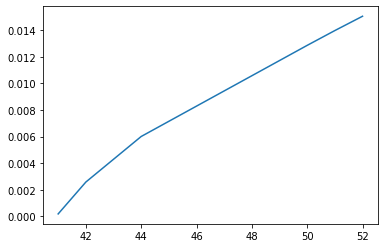

In [42]:
d[(d['Media']=='M9') & (d['Group'] == 'Control')]['Total'].plot.line(x='Time', y='Flux')

In [2]:
df = pd.read_csv(r'\\wsl$\Ubuntu\home\carterc\Model\Work\Ecoli_UTI89_QIB\Data\ATP_expdata_all_290623.csv', index_col=0)
df

,Media,Group,Time,Reaction,Flux
0,M9,Control,30,GLU6PDEHYDROG-RXN,221756.663772
1,M9,Control,30,MALYL-COA-LYASE-RXN,4523.561561
2,M9,Control,30,THREDEHYD-RXN,8489.403781
3,M9,Control,30,ORNDECARBOX-RXN,9373.232824
4,M9,Control,30,ACETOOHBUTSYN-RXN,8489.403781
...,...,...,...,...,...
22553,AdAA,Treated,155,PEPCARBOXYKIN-RXN,-44160.233837
22554,AdAA,Treated,155,1.5.1.15-RXN,-10206.477269
22555,AdAA,Treated,155,RIB5PISOM-RXN,-13350.351577
22556,AdAA,Treated,155,H2O_tx,-398783.275049


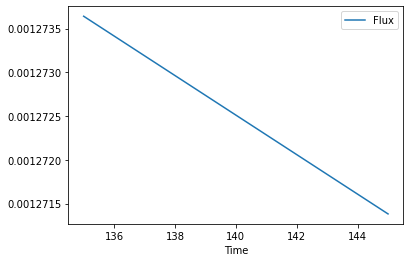

In [175]:
df[(df['Media']=='Gly') & (df['Group'] == 'Control') & (df['Reaction'] == 'Glc_mm_tx')].plot.line(x='Time', y='Flux')

In [57]:
reactions = []
rows = {} # metabolite : [stoic]

with open(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\SM.txt", 'r') as f:
    reactions = f.readline().strip().split(' ')
    while (line := f.readline()) !='':
        row = " ".join(line.lstrip().split()).split(" ")
        rows[row[0]] = row[1:]

In [58]:
sm = pd.DataFrame.from_dict(data=rows, columns=reactions, orient='index')
sm = sm.astype('int')

In [2]:
ATPdf = pd.read_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\ATP_expdata_all_290623.csv", index_col=0)
ATPdf = ATPdf[ATPdf['Time'] == 75]

In [5]:
# ATPdf[ATPdf['Reaction']=='GLYOHMETRANS-RXN']
ATPdf[ATPdf['Reaction']=='FORMYLTHFDEFORMYL-RXN']

,Media,Group,Time,Reaction,Flux
1094,M9,Control,75,FORMYLTHFDEFORMYL-RXN,24367.810015
5086,M9,Treated,75,FORMYLTHFDEFORMYL-RXN,-2392.407323
8798,Gly,Control,75,FORMYLTHFDEFORMYL-RXN,-23932.277225
12574,Gly,Treated,75,FORMYLTHFDEFORMYL-RXN,-17777.874810
16407,AdAA,Control,75,FORMYLTHFDEFORMYL-RXN,-2244.763392
20058,AdAA,Treated,75,FORMYLTHFDEFORMYL-RXN,-17324.569324


In [16]:
# Investigating changes to media import
ATPtx = ATPdf[(ATPdf['Reaction'].str.endswith('_tx')) & (~ATPdf['Reaction'].str.endswith('_bm_tx'))]

ATPtx_pivot = pd.pivot_table(ATPtx, columns='Group', values='Flux', index=['Media', 'Reaction']).reset_index().dropna()
ATPtx_pivot['Changed'] = ATPtx_pivot.apply(lambda x : round(x.Treated/x.Control*100-100, 2), axis=1)
ATPtx_pivot
# .to_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\mATP_transporters_usage.csv")

In [101]:
M9ATP = ATPdf[(ATPdf['Media'] == 'M9') & (ATPdf['Group']=='Control') & (ATPdf['Time']==75)]
M9ATP

,Media,Group,Time,Reaction,Flux
976,M9,Control,75,GLU6PDEHYDROG-RXN,2.217567e+05
977,M9,Control,75,MALYL-COA-LYASE-RXN,4.523562e+03
978,M9,Control,75,THREDEHYD-RXN,8.489404e+03
979,M9,Control,75,DLACTDEHYDROGFAD-RXN,-1.918702e-11
980,M9,Control,75,ORNDECARBOX-RXN,9.373233e+03
...,...,...,...,...,...
1300,M9,Control,75,H2O_tx,-8.772854e+05
1301,M9,Control,75,DARAB5PISOM-RXN,-6.129705e+02
1302,M9,Control,75,RXN-15125,-7.800362e+04
1303,M9,Control,75,RXN-8899,-7.800362e+04


In [60]:
M9conSM = sm[sm.columns & ATPdf[(ATPdf['Media'] == 'M9') & (ATPdf['Group']=='Control') & (ATPdf['Time']==75)]['Reaction']]

In [311]:
sm.loc['ATP', 'ATP_bm_tx']

'1'

In [111]:
for _, r, v in M9ATP[['Reaction', 'Flux']].itertuples():
    M9conSM.loc[:,r] = M9conSM.loc[:,r].astype('float').mul(v)

c:\Users\carterc\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
c:\Users\carterc\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [56]:
with open(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\Rev_reacs.txt", 'r') as f:
    rev_reacs = f.readline().split(',')
rev_reacs

['MANDELATE-RACEMASE-RXN',
 'RXN-12718',
 'PNKIN-RXN',
 'RXN-12715',
 'GLU6PDEHYDROG-RXN',
 'MALYL-COA-LYASE-RXN',
 'DLACTDEHYDROGFAD-RXN',
 'RXN-8654',
 'ORNDECARBOX-RXN',
 'ACETOOHBUTSYN-RXN',
 'ADENINE-DEAMINASE-RXN',
 'DIOHBUTANONEPSYN-RXN',
 'GALACTURIDYLYLTRANS-RXN',
 'UDPGLCNACEPIM-RXN',
 'SORB6PDEHYDROG-RXN',
 'RXN-8784',
 'RXN-10639',
 'RXN-11662',
 'DTDPGLUCOSEPP-RXN',
 'HOMSUCTRAN-RXN',
 'GLUTAMIDOTRANS-RXN',
 'GLUCUROISOM-RXN',
 'SPONTPRO-RXN',
 'CYTIDEAM2-RXN',
 'LIPIDADISACCHARIDESYNTH-RXN',
 'SERINE--GLYOXYLATE-AMINOTRANSFERASE-RXN',
 'ADPREDUCT-RXN',
 'RIBOSYLNICOTINAMIDE-KINASE-RXN',
 'NAG1P-URIDYLTRANS-RXN',
 'R344-RXN',
 'RXN-7931',
 'PSERTRANSAMPYR-RXN',
 'THREONINE-ALDOLASE-RXN',
 'LIPIDXSYNTHESIS-RXN',
 'DEOXYRIBOSE-P-ALD-RXN',
 '4-NITROPHENYLPHOSPHATASE-RXN',
 'INOPHOSPHOR-RXN',
 '2-OXOGLUTARATE-SYNTHASE-RXN',
 'THIAMIN-PYROPHOSPHOKINASE-RXN',
 'TETHYDPICSUCC-RXN',
 '3.5.1.80-RXN',
 '2.7.9.3-RXN',
 'RXN-7682',
 'RXN0-6369',
 'RXN0-1861',
 'RXN0-1862',
 'RXN-12870

In [ ]:
with open("../Data/Rev_reacs.txt", 'w') as f:
    f.write(",".join(m.sm.GetRevs()))

In [187]:
M9conSM

,GLU6PDEHYDROG-RXN,MALYL-COA-LYASE-RXN,THREDEHYD-RXN,DLACTDEHYDROGFAD-RXN,ORNDECARBOX-RXN,ACETOOHBUTSYN-RXN,ADENINE-DEAMINASE-RXN,DIOHBUTANONEPSYN-RXN,GLUTAMIDOTRANS-RXN,SPONTPRO-RXN,...,RXN0-4301,GLYCOLATEDEHYDRO-RXN,CLPN_synth,RXN0-5256,RXN-15125,RXN-8899,RXN0-2001,AKBLIG-RXN,GLUCOKIN-RXN,L-ARA4N-MODIFIED-KDO2-LIPID-A_sink_tx
CPD-501,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
Reduced-NapC-proteins,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
CPD-11523,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
CPD-14828,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
4-HYDROXYBENZALDEHYDE,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2-OXOBUTANOATE,0.0,0.0,8489.403781,-0.0,0.0,-8489.403781,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
DIHYDROXYNAPHTHOATE,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
GLUTATHIONE,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
PRISTANATE,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0


In [51]:
from itertools import product
import array

In [52]:
    pd.options.mode.chained_assignment = None

In [53]:
def pagerank(M, num_iterations: int = 100, d: float = 0.85):
    """PageRank algorithm with explicit number of iterations. Returns ranking of nodes (pages) in the adjacency matrix.

    Parameters
    ----------
    M : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i', such that for all 'j'
        sum(i, M_i,j) = 1
    num_iterations : int, optional
        number of iterations, by default 100
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        a vector of ranks such that v_i is the i-th rank from [0, 1],
        v sums to 1

    """
    N = M.shape[1]
    v = np.ones(N) / N
    M_hat = (d * M + (1 - d) / N)
    for _ in range(num_iterations):
        n_v = M_hat @ v
        if np.allclose(v, n_v):
            break
        v = n_v
    return v


def get_edges(sm : pd.DataFrame, revs : list) -> np.array:

    """
    Finds edges/connections between reactions from a stoichiometry matrix.

    Parameters
    ----------
    sm : pandas DataFrame
        Stoichiometry matrix where SM_i,j represents the stoichiometry of reactions in the network with 'j' as reaction names and 'i' as metabolites.
    revs : list
        List of reactions that are reversable in the form of reaction name as strings

    Returns
    -------
    numpy array
        a vector of connections such that v_i is the i-th rank from [0, 1],

    """

    edges = []

    for i, r1 in enumerate(sm.columns):

        reversable = r1 in revs 

        _df = sm.loc[sm[r1]!=0, r1:] # filter for metabolites involved in this reaction
        _df = _df.loc[:, (_df != 0).any(axis=0)] # filter for reacs on right-hand-side that also involve these metabolites
        _df = _df.applymap(lambda S: (str(S)[0]=='-') if S != 0 else np.NaN) # convert to binary: True if metabolite is consumed else False for produced, NaN for not involved

        for met_i, met_name in enumerate(_df.index):
            met_consumed = _df.loc[met_name,r1]

            for r2, r2_consumes in _df.iloc[met_i,1:].dropna().to_dict().items():
                r2_rev = r2 in revs 
                r2_i = sm.columns.get_loc(r2)

                comb1 = array.array('I', [i, r2_i])
                comb2 = array.array('I', [r2_i, i])
                
                if reversable and r2_rev:
                    edges += [comb1, comb2]

                elif reversable: #if first reaction is reversible
                    if r2_consumes: # if metabolite is consumed by other reaction
                        edges += [comb1]
                    else: # if metabolite is produced by other reaction
                        edges += [comb2]

                elif r2_rev: # if other reaction is reversible
                    if met_consumed: # if metabolite is consumed by this reaction
                        edges += [comb2]
                    else: # if metabolite is produced by this reactuin
                        edges += [comb1]

                elif met_consumed == True and r2_consumes == False:
                    edges += [comb2]

                elif met_consumed == False and r2_consumes == True:
                    edges += [comb1]

    return np.array(edges)

In [23]:


# get transporters that are sinks (exporters) and make links to rest of network to spread their PageRank
rev_tx = [r for r in rev_reacs if r.endswith('_tx')] # ignore reversable transporters

PRdata = {
    "Media" : [],
    "Group" : [],
    "Reaction" : [],
    "PageRank" : []
    }

for media, group in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated']):

    _subdf = ATPdf[(ATPdf['Media'] == media) & (ATPdf['Group']==group)]
    _SM = sm[sm.columns & _subdf['Reaction']]

    for _, r, v in _subdf[['Reaction', 'Flux']].itertuples():
        _SM.loc[:,r] = _SM.loc[:,r].astype('float').mul(v)

    transporter_index = []
    for i, r in enumerate(_SM.columns):
        if r.endswith('_tx') and (r not in rev_tx) and (_SM[r].apply(lambda S: (str(S)[0]=='-') if S != 0 else np.NaN).dropna().any()):
            transporter_index.append(i)

    tx_edges = np.array([[i1, i2] for i1, i2 in product(transporter_index, range(len(_SM.columns))) if i1 != i2])

    edges = get_edges(_SM, rev_reacs)
    matrix = np.zeros((edges.max()+1, edges.max()+1))
    matrix[edges[:,0], edges[:,1]] = 1
    matrix[tx_edges[:,0], tx_edges[:,1]] = 1
    matrix = matrix/matrix.sum(axis=0, keepdims=True)
    pr = pagerank(matrix)

    rlen = len(_subdf)
    PRdata['Media'] += [media]*rlen
    PRdata['Group'] += [group]*rlen
    PRdata['Reaction'] += list(_subdf['Reaction'])
    PRdata['PageRank'] += list(pr)
    


In [24]:
PRdf = pd.DataFrame(PRdata)
PRdf

,Media,Group,Reaction,PageRank
0,M9,Control,GLU6PDEHYDROG-RXN,0.001637
1,M9,Control,MALYL-COA-LYASE-RXN,0.000789
2,M9,Control,THREDEHYD-RXN,0.000637
3,M9,Control,DLACTDEHYDROGFAD-RXN,0.000602
4,M9,Control,ORNDECARBOX-RXN,0.001633
...,...,...,...,...
1855,AdAA,Treated,PEPCARBOXYKIN-RXN,0.000987
1856,AdAA,Treated,1.5.1.15-RXN,0.000503
1857,AdAA,Treated,RIB5PISOM-RXN,0.000817
1858,AdAA,Treated,H2O_tx,0.001304


In [25]:
PRdf.to_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\PageRank.csv")

In [26]:
pd.read_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\PageRank.csv", index_col=0).to_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\PageRank.tsv", sep='\t')

In [270]:
np.argwhere(np.sum(matrix, axis=1) == 0)

array([], shape=(0, 1), dtype=int32)

In [302]:
pr.sum()

1.000000000000001

(array([263.,  16.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  50.]),
 array([0.0004625 , 0.00179879, 0.00313508, 0.00447137, 0.00580767,
        0.00714396, 0.00848025, 0.00981654, 0.01115283, 0.01248912,
        0.01382541]),
 <a list of 10 Patch objects>)

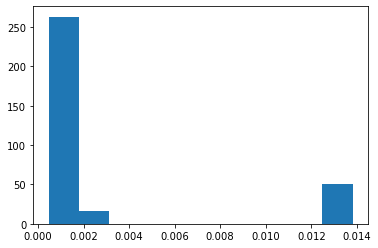

In [301]:
plt.hist(pr)

### Mass Flow Graph

In [34]:
M9conSM = sm[sm.columns & ATPdf[(ATPdf['Media'] == 'M9') & (ATPdf['Group']=='Control') & (ATPdf['Time']==75)]['Reaction']]

for _, r, v in ATPdf[(ATPdf['Media'] == 'M9') & (ATPdf['Group']=='Control')][['Reaction', 'Flux']].itertuples():
    M9conSM.loc[:,r] = M9conSM.loc[:,r].astype('float').mul(v)

M9conSM

,GLU6PDEHYDROG-RXN,MALYL-COA-LYASE-RXN,THREDEHYD-RXN,DLACTDEHYDROGFAD-RXN,ORNDECARBOX-RXN,ACETOOHBUTSYN-RXN,DIOHBUTANONEPSYN-RXN,GLUTAMIDOTRANS-RXN,SPONTPRO-RXN,CYTIDEAM2-RXN,...,METHYLTHIOADENOSINE-NUCLEOSIDASE-RXN,RXN0-4341,DARAB5PISOM-RXN,RXN0-4301,GLYCOLATEDEHYDRO-RXN,CLPN_synth,RXN0-5256,RXN-15125,RXN-8899,GLUCOKIN-RXN
CPD-501,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
Reduced-NapC-proteins,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
CPD-11523,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
CPD-14828,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
4-HYDROXYBENZALDEHYDE,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2-OXOBUTANOATE,0.0,0.0,8489.403781,-0.0,0.0,-8489.403781,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
DIHYDROXYNAPHTHOATE,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
GLUTATHIONE,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
PRISTANATE,0.0,0.0,0.000000,-0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0


In [480]:
def MassFlowGraph(sm, master_reacs:list):
    weights = []
    for r in sm.columns:
        r_index = master_reacs.get_loc(r)
        produced = sm.loc[sm[r]>0, r].to_dict() # get metabolites produced by reaction
        _sm = sm.loc[produced, [i for i in sm if i != r]]
        total_consumed = _sm.apply(lambda x : abs(sum([i for i in x if i<0])),axis=1).to_dict()
        _weights = _sm.loc[:, (_sm < 0).any(axis=0)].apply(
            lambda x : sum([
                produced[x.index[i]]*(abs(v)/total_consumed[x.index[i]]) for i, v in enumerate(x) if v < 0
            ]), axis=0).to_dict()
        weights += [[r_index, master_reacs.get_loc(r2), v] for r2, v in _weights.items()]

    return np.array(weights)

Leiden algorithm

In [1]:
import leidenalg as la
import igraph as ig
from collections import Counter

In [64]:
# Get reactions and metabolites only present in LP solutions
reactions = []
metabolites = []

for values in SMs.values():
    for v in values.values():
        reactions += list(v.columns)
        metabolites += list(v.index)
reactions = set(reactions)
metabolites = set(metabolites)

In [65]:
M = sm.loc[metabolites, reactions]

In [86]:

graphs = []

for media, group in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated']):

    _subdf = ATPdf[(ATPdf['Media'] == media) & (ATPdf['Group']==group)]
    _SM = M[M.columns & _subdf['Reaction']]

    for _, r, v in _subdf[['Reaction', 'Flux']].itertuples():
        _SM.loc[:,r] = _SM.loc[:,r].astype('float').mul(v)

    MFG = MassFlowGraph(_SM, M.columns)
    G = ig.Graph(n=len(M.columns), edges=MFG[:,:2])
    G.es['Weight'] = MFG[:,2]
    graphs.append(G.copy())

membership, improvement = la.find_partition_multiplex(graphs, la.ModularityVertexPartition, n_iterations=-1, weights="Weight", seed=1)


In [87]:
communities = {r : c for r,c in zip(M.columns, membership)}
# communities

In [88]:
Counter(membership).most_common()

[(0, 64),
 (1, 62),
 (2, 62),
 (4, 48),
 (3, 48),
 (5, 20),
 (6, 16),
 (7, 11),
 (8, 10),
 (9, 9),
 (10, 5),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1)]

In [ ]:
with open(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\MFG_reactions.txt",'w') as f:
    f.write('\n'.join(communities.keys()))

In [72]:
MFGpathways = pd.read_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\MFG_pathways.txt", index_col=0, delimiter='\t')
MFGpathways

,Pathways of a reaction,Super-Pathways,Ontology - direct parents of entity
column 1,,,
5.1.3.20-RXN,PWY0-1241,NaN,NaN
RXN-14014,DAPLYSINESYN-PWY,P4-PWY,Amino-Acid-Biosynthesis // Super-Pathways
FESO3OXI-RXN,NaN,NaN,NaN
GMP-REDUCT-RXN,NaN,NaN,NaN
RXN-8999,PWY-5785,POLYISOPRENSYN-PWY,Polyprenyl-Biosynthesis // Super-Pathways
...,...,...,...
RXN-5061,NaN,NaN,NaN
ADCLY-RXN,PWY-6543,PWY-6612,Folate-Biosynthesis // Super-Pathways
1.5.1.20-RXN,NaN,NaN,NaN


In [73]:
MFGpathways['Super-Pathways'] = MFGpathways.apply(lambda row : row[1] if isinstance(row[1], str) else row[0], axis=1)
MFGpathways['Ontology - direct parents of entity'] = MFGpathways.apply(lambda row : row[2] if (isinstance(row[2], str) and not row[2] == 'Super-Pathways') else row[1], axis=1)
MFGpathways = MFGpathways.rename(columns={'Ontology - direct parents of entity' : 'Pathway'})
MFGpathways = MFGpathways['Pathway']

def unpack_pathway(item):
    rv = np.NaN
    if isinstance(item, str):
        items = item.split(' // ')
        items = [i for i in items if i != 'Super-Pathways']
        if items:
            rv = items[0]
    return rv

MFGpathways = MFGpathways.apply(unpack_pathway)
MFGpathways

column 1
5.1.3.20-RXN                    PWY0-1241
RXN-14014         Amino-Acid-Biosynthesis
FESO3OXI-RXN                          NaN
GMP-REDUCT-RXN                        NaN
RXN-8999          Polyprenyl-Biosynthesis
                           ...           
RXN-5061                              NaN
ADCLY-RXN             Folate-Biosynthesis
1.5.1.20-RXN                          NaN
His_AA_bm_tx                          NaN
2.7.1.148-RXN               NONMEVIPP-PWY
Name: Pathway, Length: 370, dtype: object

In [582]:
reassign = {
    'MALYL-COA-LYASE-RXN': "TCA Cycle",
    'MALATE--COA-LIGASE-RXN': "CARBOXYLATES-DEG",
    'ADENINE-DEAMINASE-RXN': 'Purine Salvage',
    'GLUTAMIDOTRANS-RXN': 'Purine Biosynthesis',
    '2-OXOGLUTARATE-SYNTHASE-RXN': 'TCA Cycle',
    'RXN-8001': 'L-Histidine Biosynthesis',
    'PRIBFAICARPISOM-RXN' : 'Purine Biosynthesis',
    'SULFITE-OXIDASE-RXN' : "Sulfur-Metabolism",
    'DIHYDROURACIL-DEHYDROGENASE-NAD+-RXN' : "Pyrimid-Deoxyribonucleot-De-Novo-Biosyn",
    'RXN-14175' : "CoA-Biosynthesis",
    'PYFLAVOXRE-RXN' : "Energy-Metabolism" ,
    'RXN66-555' : "CoA-Biosynthesis" ,
    'L-ASPARTATE-OXID-RXN' : "Cofactor-Biosynthesis",
    'HISTPRATPHYD-RXN' : "Purine Biosynthesis",
    'RXN-13482' : "Purine Biosynthesis",
    '1.5.1.20-RXN' : "Folate Pool",
    'DEOXYADENYLATE-KINASE-RXN' : "Purine Salvage",
    'HISTAMINOTRANS-RXN' : "L-Histidine Biosynthesis",
    'PRPPSYN-RXN' : "Carbohydrates-Biosynthesis",
    'RXN-15348' : "Sulfur-Metabolism",
    'GMP-REDUCT-RXN' : "Purine Salvage",
    'RXN0-313' : "Carbohydrates-Degradation" ,
    'RXN-13202' : "CARBOXYLATES-DEG",
    'PYRUFLAVREDUCT-RXN' : "Energy-Metabolism" ,
    'HISTIDPHOS-RXN' : "L-Histidine Biosynthesis",
    'QUINOPRIBOTRANS-RXN' : "Cofactor-Biosynthesis",
    'RXN0-882' : "SECONDARY-METABOLITE-BIOSYNTHESIS",
    'IMIDPHOSDEHYD-RXN' : "Purine Biosynthesis",
    'QUINOLINATE-SYNTHA-RXN' : "Cofactor-Biosynthesis",
    'FORMYLTHFDEFORMYL-RXN' : "Folate Pool",
    'RXN-14047' : "TCA Cycle",
    'SULFFEOXIDO-RXN' : "Sulfur-Metabolism",
    'CITSYN-RXN' : "TCA Cycle",
    '1.1.1.8-RXN' : "Lipid-Biosynthesis",
    'ACETYLHOMOSER-CYS-RXN' : "Amino-Acid-Biosynthesis",
    'HISTCYCLOHYD-RXN' : "Purine Biosynthesis",
    'DEOXYADENOSINE-KINASE-RXN' : "Purine Salvage",
    'HOMOSERINE-O-ACETYLTRANSFERASE-RXN' : "Amino-Acid-Biosynthesis",
    'RXN-14192' : "Carbohydrates-Degradation" ,
    'ISOCITDEH-RXN' : "TCA Cycle",
    'ISPH2-RXN-(NAD)' : "SECONDARY-METABOLITE-BIOSYNTHESIS",
    'PYRROLINECARBREDUCT-RXN-(NADP)' : "Amino-Acid-Biosynthesis",
    'HOMOSERDEHYDROG-RXN-(NAD)' : "Amino-Acid-Biosynthesis",
    'RXN0-884-(NADP)' : "SECONDARY-METABOLITE-BIOSYNTHESIS",
    'NADH_DH_ubi' : "Energy-Metabolism" ,
    'Succ_DH' : "Energy-Metabolism" ,
    'RXN0-5268' : "Energy-Metabolism" ,
    'ATPSynth' : "Energy-Metabolism" ,
    'FA_Synth' : "Lipid-Biosynthesis" ,
    'Pep_synth' : "Lipid-Biosynthesis" ,
    'LPS_synth' : "Lipid-Biosynthesis" ,
    'PA_synth_NADPH' : "Lipid-Biosynthesis" ,
    'CDPdag_synth' : "Lipid-Biosynthesis" ,
    'PS_synth' : "Lipid-Biosynthesis" ,
    'PE_synth' : "Lipid-Biosynthesis" ,
    "PG_synth" : "Lipid-Biosynthesis",
    'GLYCOLATEDEHYDRO-RXN' : "Energy-Metabolism",
    'CLPN_synth' : "Lipid-Biosynthesis",
    'RXN0-5256' : "Energy-Metabolism",
    'ISOCIT-CLEAV-RXN' : "TCA Cycle",
    'GLUTAMATE-DEHYDROGENASE-RXN' : "Amino-Acid-Degradation",
    'FESO3OXI-RXN' : "Sulfur-Metabolism",
    'DIHYDROPYRIMIDINASE-RXN' : "Pyrimidine-Degradation",
    'RXN-9025' : "Lipid-Biosynthesis",
    'BETA-UREIDOPROPIONASE-RXN' : "Pyrimidine-Degradation",
    'ARGININE-DEIMINASE-RXN' : "Amino-Acid-Degradation",
    'MALATE-DEH-RXN' : "TCA Cycle",
    '1.18.1.2-RXN' : 'Energy-Metabolism' ,
    '1.6.99.5-RXN' : 'Energy-Metabolism' ,
    'GLUCISOM-RXN' : 'Carbohydrates-Degradation' ,
    'RXN-14515' : 'Carbohydrates-Degradation' ,
    '2OXOGLUTARATEDEH-RXN' : 'TCA Cycle' ,
    'PYRROLINECARBREDUCT-RXN-(NAD)' : 'Amino-Acid-Biosynthesis' ,
    'RXN0-884-(NAD)' : "SECONDARY-METABOLITE-BIOSYNTHESIS",
    'RXN0-5186' : "Carbohydrates-Degradation",
    '1.10.2.2-RXN' : "Energy-Metabolism" ,
    'RXN-14903' : "Amino-Acid-Degradation",
    '1.5.1.15-RXN' : "Folate Pool",
    'RXN-12193' : "Carbohydrates-Degradation",
    'MALTOSE-PHOSPHORYLASE-RXN' : "Carbohydrates-Degradation",
    'BETA-PHOSPHOGLUCOMUTASE-RXN' : "Carbohydrates-Degradation",
    "R601-RXN" : "Energy-Metabolism",
    "METHYLTHIOADENOSINE-NUCLEOSIDASE-RXN" : "Nucleotide Degradation",
    "CYTOCHROME-C-OXIDASE-RXN" : "Energy-Metabolism",
    "SUCCDIAMINOPIMDESUCC-RXN" : "TCA Cycle" 
}
relabel = {
    "Purine-Nucleotide-De-Novo-Biosynthesis" : "Purine Biosynthesis",
    "Carbohydrates-Degradation" : "Glycolysis / Gluconeogenesis",
    "Folate-Biosynthesis" : "Folates",
    # "Carbohydrates-Biosynthesis" : "Glycolysis / Gluconeogenesis",
    "Pyrimid-Deoxyribonucleot-De-Novo-Biosyn" : "Pyrimidine Biosynthesis",
    "Amino-Acid-Degradation" : "Amino acids",
    "NUCLEO-DEG" : "Nucleotide Biosynthesis/Degradation",
    "THREONINE-DEG" : "Amino acids",
    "TRYPTOPHAN-BIOSYNTHESIS" : "Amino acids",
    "Pyrimidine-Nucleotide-Salvage" : "Pyrimidines",
    "AIR-Biosynthesis" : "Purine Biosynthesis",
    "Pyrimidine-Degradation" : "Pyrimidines",
    "Nucleotide-Biosynthesis" : "Nucleotide Biosynthesis/Degradation",
    "L-Histidine Biosynthesis" : "Amino acids",
    "Cell-Structure-Biosynthesis" : "Cell Wall",
    "Lipid-Biosynthesis" : "Cell Wall",
    "ALANINE-SYN" : "Amino acids",
    "THREONINE-BIOSYNTHESIS" : "Amino acids",
    # "GLYCEROL-DEG" : "Glycolysis / Gluconeogenesis",
    "S-adenosyl-L-methionine-Biosynthesis" : "Amino acids",
    "ARGININE-DEG" : "Amino acids",
    "Peptidoglycan-Biosynthesis" : "Cell Wall",
    "Amino-Acid-Biosynthesis" : "Amino acids",
    "CoA-Biosynthesis" : 'Cofactor-Biosynthesis',
    "Pyrimidine Salvage" : "Pyrimidines",
    "Pyrimidine Biosynthesis" : "Pyrimidines",
    "Folate Pool" : "Folates",
    # "Alcohol-Degradation" : "Glycolysis / Gluconeogenesis",
    "Thiamine-Biosynthesis" : "Cofactor-Biosynthesis",
    "Aldonate-Degradation" : "Glycolysis / Gluconeogenesis",
    "PWY0-1241" : "Carbohydrates-Biosynthesis",
    "RIBOSYN2-PWY" : 'Cofactor-Biosynthesis',
    "PWY0-42" : "CARBOXYLATES-DEG",
    "PWY0-1296" : "Purine Salvage",
    "1CMET2-PWY" : "Folates",
    "PWY-7805" : "SECONDARY-METABOLITE-BIOSYNTHESIS", #??? inorganic metabolics
    "PWY0-1338" : "Cell Wall",
    "SERDEG-PWY" : "Amino acids",
    "PROSYN-PWY" : "Amino acids",
    "CYANCAT-PWY" : "SECONDARY-METABOLITE-BIOSYNTHESIS", #??? inorganic metabolites
    "PYRUVDEHYD-PWY" : "Cofactor-Biosynthesis",
    "PROUT-PWY-I" : "Amino acids",
    "PWY-6611" : "Purine Salvage",
    "PWY-7761" : "Cofactor-Biosynthesis",
    "GLUTSYNIII-PWY" : "Amino acids",
    "PWY0-163" : "Pyrimidines",
    "PRPP-PWY" : "", #??? PRPP
    "SALVADEHYPOX-PWY" : "Purine Salvage",
    "PWY0-181" : "Pyrimidines",
    "DETOX1-PWY" : "ROS",
    "AMMASSIM-PWY" : "SECONDARY-METABOLITE-BIOSYNTHESIS", #?? Ammonia assimilation
    "GLYCEROLMETAB-PWY" : "Alcohol-Degradation", #?? Glycerol Degradation
    "GLUCONEO-PWY" : "Glycolysis / Gluconeogenesis",
    "NADPHOS-DEPHOS-PWY" : "Cofactor-Biosynthesis",
    "GLYCLEAV-PWY" : "Folates",
    "GLYCOCAT-PWY" : "Cell Wall",
    "PWY3O-4106" : "Cofactor-Biosynthesis",
    "PWY0-1391" : "Nucleotide Degradation",
    "NONMEVIPP-PWY" : "SECONDARY-METABOLITE-BIOSYNTHESIS",
    
    }


In [75]:
for k,v in reassign.items():
    MFGpathways.loc[k] = v

In [76]:
MFGpathways = MFGpathways.replace(relabel)

In [77]:
MFGpathways.value_counts()

Amino acids                            63
Purine Biosynthesis                    27
Cofactor-Biosynthesis                  26
Energy-Metabolism                      21
Cell Wall                              19
Folates                                16
SECONDARY-METABOLITE-BIOSYNTHESIS      12
Pyrimidines                            12
Glycolysis / Gluconeogenesis           10
Sulfur-Metabolism                       9
Purine Salvage                          9
Pentose-Phosphate-Cycle                 8
Carbohydrates-Biosynthesis              8
Pyrimidine Biosynthesis                 8
TCA Cycle                               8
Chorismate-Biosynthesis                 7
Fermentation-to-Acids                   5
CARBOXYLATES-DEG                        5
Metabolic-Clusters                      4
Aldehyde-Degradation                    3
Nucleotide Biosynthesis/Degradation     3
Alcohol-Degradation                     3
Polyamine-Biosynthesis                  2
Ubiquinone-Biosynthesis           

In [81]:
MFGpathways[(MFGpathways.isna()) & (~MFGpathways.index.str.endswith('_tx'))]

column 1
R621-RXN-(NAD)                             NaN
SERINE--GLYOXYLATE-AMINOTRANSFERASE-RXN    NaN
mATPSynth-RXN                              NaN
HYDROXYPYRUVATE-REDUCTASE-RXN-(NADP)       NaN
ORNITHINE-GLU-AMINOTRANSFORASE-RXN         NaN
mATPase-RXN                                NaN
RXN0-5289                                  NaN
RXN-12721                                  NaN
RXN66-532                                  NaN
RXN-8899                                   NaN
RXN-12541                                  NaN
RXN0-305                                   NaN
RXN-7968-(NAD)                             NaN
PHEAMINOTRANS-RXN                          NaN
RXN-12720                                  NaN
RXN-12864                                  NaN
GLUTATHIONE-PEROXIDASE-RXN                 NaN
RXN0-6369                                  NaN
RXN-6182                                   NaN
RXN-5061                                   NaN
Name: Pathway, dtype: object

In [257]:
MFGpathways.loc['ATPSynth']

'Energy-Metabolism'

In [601]:
comdf = pd.DataFrame().from_dict(communities, orient='Index')
comdf = comdf.rename(columns={0:'Community'})
comdf = comdf[~comdf['Community'].isin(range(11, 28))]
comdf['Pathway'] = comdf.index.map(lambda x : MFGpathways.loc[x])
comdf.loc[comdf.index.str.endswith('_tx'), 'Pathway'] = 'Transporter'
comdf

,Community,Pathway
DIAMINOPIMEPIM-RXN,7,Amino acids
ADENPRIBOSYLTRAN-RXN,0,SECONDARY-METABOLITE-BIOSYNTHESIS
ISOCITDEH-RXN,4,TCA Cycle
IGPSYN-RXN,0,Amino acids
2.3.1.157-RXN,4,Metabolic-Clusters
...,...,...
PRAISOM-RXN,0,Amino acids
MALATE--COA-LIGASE-RXN,3,CARBOXYLATES-DEG
dGTP_bm_tx,4,Transporter
RXN-15348,5,Sulfur-Metabolism


In [49]:
ATPdf[ATPdf['Reaction']=='AKBLIG-RXN']

,Media,Group,Time,Reaction,Flux
8768,Gly,Control,75,AKBLIG-RXN,3141.721300
12537,Gly,Treated,75,AKBLIG-RXN,3141.721300
16377,AdAA,Control,75,AKBLIG-RXN,1293.288811
20026,AdAA,Treated,75,AKBLIG-RXN,1293.288811


In [4]:
ATPdf[ATPdf['Flux'].between(-1, 1)]['Reaction'].drop_duplicates()

965                       DLACTDEHYDROGFAD-RXN
999                                GLYOXII-RXN
1043                               DGDPKIN-RXN
1044                       ADENYLYLSULFKIN-RXN
1074                               1.8.4.8-RXN
1100                             GDPREDUCT-RXN
1108                                GLYOXI-RXN
1120                            AMACETOXID-RXN
1164                              1.10.2.2-RXN
1260                                 RXN-14903
4828                                 RXN-12721
4962                                 RXN-12864
5070                                 RXN-12720
8788                       PHOSACETYLTRANS-RXN
12287           UNDECAPRENYL-DIPHOSPHATASE-RXN
12309          2-METHYLCITRATE-DEHYDRATASE-RXN
12326               METHYLISOCITRATE-LYASE-RXN
12333             2-METHYLCITRATE-SYNTHASE-RXN
12359                                RXN0-5409
12455                           R621-RXN-(NAD)
12536                                RXN0-2001
12539    L-AR

In [57]:
_df = pd.pivot_table(ATPdf[ATPdf['Reaction'].isin(comdf[comdf['Community']==1].index)], values='Flux', columns=['Group'], index=['Media', 'Reaction']).reset_index()
_df['Changed'] = _df.apply(lambda x : round(x.Treated/x.Control*100-100, 2), axis=1)
_df[_df['Changed']!=0]

Group,Media,Reaction,Control,Treated,Changed
0,AdAA,2.7.1.121-RXN,NaN,5470.484045,NaN
3,AdAA,2PGADEHYDRAT-RXN,109359.468300,154848.770623,41.60
20,AdAA,GLUCOKIN-RXN,163565.864205,203584.682483,24.47
24,AdAA,Glc_mm_tx,163565.864205,203584.682483,24.47
34,AdAA,PEPDEPHOS-RXN,-25874.600023,-65893.418301,154.66
37,AdAA,PHOSGLYPHOS-RXN,-109359.468300,-154848.770623,41.60
47,AdAA,RXN-15513,-109359.468300,-154848.770623,41.60
48,AdAA,RXN-6182,10225.976644,19916.621717,94.76
51,AdAA,RXN0-313,NaN,5470.484045,NaN
61,Gly,2PGADEHYDRAT-RXN,103649.823826,132216.266493,27.56


In [50]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(comdf[comdf['Community']==3].index)

Index(['HOMOCYSMETB12-RXN', 'Gly_AA_bm_tx', 'RXN-8899', 'ISOCIT-CLEAV-RXN',
       '1.5.1.20-RXN', 'ACETYLHOMOSER-CYS-RXN', 'Met_aa_mm_tx',
       'THREDEHYD-RXN', 'SERINE--GLYOXYLATE-AMINOTRANSFERASE-RXN',
       'ACET_bp_tx', 'FORMYLTHFDEFORMYL-RXN', 'DTDPKIN-RXN',
       'METHYLENETHFDEHYDROG-NADP-RXN', 'SERINE-O-ACETTRAN-RXN', 'THRESYN-RXN',
       '4.3.1.17-RXN', 'GMP-REDUCT-RXN', 'IMPCYCLOHYDROLASE-RXN',
       'DIHYDROFOLATEREDUCT-RXN', 'METHENYLTHFCYCLOHYDRO-RXN', 'dTTP_bm_tx',
       'GLYRIBONUCSYN-RXN', 'Gly_aa_mm_tx', 'RXN-15125', 'ACSERLY-RXN',
       'AICARTRANSFORM-RXN', 'HOMOSERKIN-RXN', 'PHOSACETYLTRANS-RXN',
       'HOMOSERINE-O-ACETYLTRANSFERASE-RXN', 'GART-RXN', 'Cys_AA_bm_tx',
       'Ser_AA_bm_tx', 'MeTHF_bm_tx', 'HYDROXYPYRUVATE-REDUCTASE-RXN-(NADP)',
       'GLYOHMETRANS-RXN', 'GCVMULTI-RXN', 'ACETATEKIN-RXN',
       '2-DEHYDROPANTOATE-REDUCT-RXN', 'Met_AA_bm_tx', '1.5.1.15-RXN',
       'THYMIDYLATESYN-RXN', 'Thr_AA_bm_tx',
       '3-CH3-2-OXOBUTANOATE-OH-CH3-XFE

In [43]:
comdf[comdf.index == 'Gly_aa_mm_tx']

,Community
Gly_aa_mm_tx,3


In [577]:
comdf['Community'].to_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\CommunityReactions.csv")

In [30]:
comdf = pd.read_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\CommunityReactions.csv", names=["Reaction", "Community"], skiprows=1)
# comdf[comdf['Community']==10]
comdf = comdf[~comdf['Reaction'].isin(ATPdf[ATPdf['Flux'].between(-1, 1)]['Reaction'].drop_duplicates())]
comdf

,Reaction,Community
0,DIAMINOPIMEPIM-RXN,7
1,ADENPRIBOSYLTRAN-RXN,0
2,ISOCITDEH-RXN,4
3,IGPSYN-RXN,0
4,2.3.1.157-RXN,4
...,...,...
350,PRAISOM-RXN,0
351,MALATE--COA-LIGASE-RXN,3
352,dGTP_bm_tx,4
353,RXN-15348,5


In [32]:
comdf.groupby('Community')['Reaction'].count()

Community
0     64
1     62
2     62
3     47
4     47
5     15
6     15
7     11
8     10
9      8
10     4
Name: Reaction, dtype: int64

In [29]:
_comdf = comdf.groupby('Community').agg({'Reaction':', '.join, 'Community' : 'first'})
_comdf['Transporters'] = _comdf['Reaction'].apply(lambda x : ', '.join([i for i in x.split(', ') if i.endswith('_tx')]))
_comdf['Reaction'] = _comdf['Reaction'].apply(lambda x : ', '.join([i for i in x.split(', ') if not i.endswith('_tx')]))
_comdf[['Reaction', 'Transporters']].to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\CommunityContents.csv')

In [497]:
ATPdf['Community'] = ATPdf['Reaction'].apply(lambda x : comdf.loc[x, 'Community'])

In [525]:
ATPdf_abs = ATPdf.dropna().groupby(['Media', 'Group', 'Community']).Flux.apply(lambda c : c.abs().sum()).reset_index()
ATPdf_pivot = pd.pivot_table(ATPdf_abs, values='Flux', columns=['Community'], index=['Media', 'Group']).reset_index()
ATPdf_pivot = ATPdf_pivot.fillna(0)
ATPdf_pivot = ATPdf_pivot.iloc[:, :13]
# ATPdf_pivot.iloc[:, 2:] = ATPdf_pivot.iloc[:, 2:].apply(np.log10)
# ATPdf_pivot.loc[6] = ['Max', 'Max'] + [0.04]*5
# ATPdf_pivot.loc[7] = ['Min', 'Min'] + [0.0]*5
# ATPdf_pivot = ATPdf_pivot.reindex(index=[6,7,0,1,2,3,4,5])
ATPdf_pivot

Community,Media,Group,0,1,2,3,4,5,6,7,8,9,10
0,AdAA,Control,226449.835215,9.429265e+05,5.926142e+05,625583.635200,1.424249e+06,18963.434467,1.107023e+06,53818.208244,72.671558,248.635416,2676.651703
1,AdAA,Treated,232589.589620,1.220082e+06,8.185901e+05,227702.160495,1.462482e+06,18963.434467,1.122056e+06,234907.414992,72.671558,248.635416,2676.651703
2,Gly,Control,174566.746001,8.974630e+05,6.111944e+05,624068.428691,1.284871e+06,44720.830014,1.319150e+06,98841.257162,62.444605,213.645347,5705.837041
3,Gly,Treated,164307.933570,1.005219e+06,6.996590e+05,239401.838537,1.313111e+06,44720.830014,8.077249e+05,216271.585546,62.444605,213.645347,22003.415838
4,M9,Control,246438.003073,1.598932e+06,1.151394e+06,568079.712851,1.761834e+06,55468.185476,1.773788e+06,512955.631013,77.451356,264.988814,11371.312426
5,M9,Treated,203794.583681,1.456706e+06,1.006144e+06,333494.398776,1.775997e+06,55468.185476,1.161271e+06,407442.146699,77.451356,264.988814,31585.541975


In [520]:
ATPdf_pivot.iloc[:, 2:].to_numpy().max(), ATPdf_pivot.iloc[:, 2:].to_numpy().min()

(6.249442344147452, 1.7954949196329817)

In [543]:
ATPdf_abs[ATPdf_abs['Community'].isin(range(0, 11))].to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\CommunityFlux.csv')

In [8]:
ATPdf_abs = pd.read_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\CommunityFlux.csv', index_col=0)
ATPdf_abs_pivot = pd.pivot_table(ATPdf_abs, values='Flux', columns=['Group'], index=['Media', 'Community']).reset_index()
ATPdf_abs_pivot['Change']  = ATPdf_abs_pivot.apply(lambda row : row.Treated/row.Control*100-100, axis=1)
ATPdf_abs_pivot.to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\CommunityFlux.csv')
ATPdf_abs_pivot

Group,Media,Community,Control,Treated,Change
0,AdAA,0,2.264498e+05,2.325896e+05,2.711309e+00
1,AdAA,1,9.429265e+05,1.220082e+06,2.939317e+01
2,AdAA,2,5.926142e+05,8.185901e+05,3.813204e+01
3,AdAA,3,6.255836e+05,2.277022e+05,-6.360164e+01
4,AdAA,4,1.424249e+06,1.462482e+06,2.684432e+00
5,AdAA,5,1.896343e+04,1.896343e+04,2.842171e-14
6,AdAA,6,1.107023e+06,1.122056e+06,1.357949e+00
7,AdAA,7,5.381821e+04,2.349074e+05,3.364832e+02
8,AdAA,8,7.267156e+01,7.267156e+01,0.000000e+00
9,AdAA,9,2.486354e+02,2.486354e+02,0.000000e+00


In [312]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(comdf[comdf['Community']==0])

                                      Community  \
ADENPRIBOSYLTRAN-RXN                          0   
IGPSYN-RXN                                    0   
RXN0-4361                                     0   
5.1.3.20-RXN                                  0   
BETA-UREIDOPROPIONASE-RXN                     0   
INOSINEKIN-RXN                                0   
ASPDECARBOX-RXN                               0   
RXN-7968-(NAD)                                0   
RXN0-745                                      0   
RIB5PISOM-RXN                                 0   
TRANSALDOL-RXN                                0   
SHIKIMATE-KINASE-RXN                          0   
DCTP-DEAM-RXN                                 0   
INOPHOSPHOR-RXN                               0   
RXN0-4342                                     0   
DEOXYADENOSINE-KINASE-RXN                     0   
DURIDKI-RXN                                   0   
PHEAMINOTRANS-RXN                             0   
Phe_AA_bm_tx                   

In [592]:
m = "SULFATE"
M.loc[m, M.loc[m] != 0]

SO4_tx                 1
SULFITE-OXIDASE-RXN    1
FESO3OXI-RXN           1
Name: SULFATE, dtype: int32

In [80]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(comdf[['Community', 'Pathway']].value_counts(sort=False))

Community  Pathway                            
0          Amino acids                             8
           Carbohydrates-Biosynthesis              6
           Chorismate-Biosynthesis                 7
           Cofactor-Biosynthesis                   1
           Glycolysis / Gluconeogenesis            1
           Nucleotide Biosynthesis/Degradation     3
           Nucleotide Degradation                  1
           Pentose-Phosphate-Cycle                 5
           Polyamine-Biosynthesis                  2
           Purine Biosynthesis                     2
           Purine Salvage                          8
           Pyrimidine Biosynthesis                 3
           Pyrimidines                             7
           SECONDARY-METABOLITE-BIOSYNTHESIS       1
           Transporter                             7
1          Alcohol-Degradation                     2
           Amino acids                             2
           Carbohydrates-Biosynthesis              2

In [609]:
comdf['OwnPathways'] = comdf.index.map(lambda x : [i for i,v in pathwaymap.items() if x in v])
comdf['OwnPathways'] = comdf.apply(lambda x : x.OwnPathways[0] if x.OwnPathways else x.Pathway, axis=1)
comdf['OwnPathways'] = comdf['OwnPathways'].replace({'etc_reacs' : 'ETC', 'tca_reacs' : 'TCA Cycle', 'folate_reacs' : 'Folates', 'purine_reacs' : 'Purine Biosynthesis', 'pur_salvages' : 'Purine Salvage'})
comdf

,Community,Pathway,OwnPathways
DIAMINOPIMEPIM-RXN,7,Amino acids,Amino acids
ADENPRIBOSYLTRAN-RXN,0,SECONDARY-METABOLITE-BIOSYNTHESIS,Purine Salvage
ISOCITDEH-RXN,4,TCA Cycle,TCA Cycle
IGPSYN-RXN,0,Amino acids,Amino acids
2.3.1.157-RXN,4,Metabolic-Clusters,Metabolic-Clusters
...,...,...,...
PRAISOM-RXN,0,Amino acids,Amino acids
MALATE--COA-LIGASE-RXN,3,CARBOXYLATES-DEG,TCA Cycle
dGTP_bm_tx,4,Transporter,Transporter
RXN-15348,5,Sulfur-Metabolism,Sulfur-Metabolism


In [616]:
linksdf = comdf[['Community', 'OwnPathways']].value_counts(sort=False).reset_index()
linksdf = linksdf.rename(columns={0:"Freq"})
linksdf = linksdf[linksdf['Freq']>1]
linksdf = linksdf[~linksdf['OwnPathways'].isin(linksdf.groupby('OwnPathways')['Freq'].sum()[linksdf.groupby('OwnPathways')['Freq'].sum()<4].index)]

pathways_to_drop = ['SECONDARY-METABOLITE-BIOSYNTHESIS', 'Fermentation-to-Acids']
linksdf = linksdf[~linksdf['OwnPathways'].isin(pathways_to_drop)]

relabel_pathways = {"Pentose-Phosphate-Cycle" : "PPP", "Energy-Metabolism" : "Energy", "Transporter" : "Transporters", "Carbohydrates-Biosynthesis" : "Sugar_Biosynthesis", " " : "_", "-" : "_"}
linksdf['OwnPathways'] = linksdf['OwnPathways'].replace(relabel_pathways, regex=True)
linksdf['Community'] = linksdf['Community'].apply(lambda x : f'C{x}')
linksdf.to_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\community_pathway_links.csv", index=False)

In [614]:
comdf[comdf['OwnPathways']=='Energy-Metabolism']

,Community,Pathway,OwnPathways
PYRUFLAVREDUCT-RXN,4,Energy-Metabolism,Energy-Metabolism
KDPGALDOL-RXN,4,Energy-Metabolism,Energy-Metabolism
RXN-15513,1,Energy-Metabolism,Energy-Metabolism
TRIOSEPISOMERIZATION-RXN,4,Energy-Metabolism,Energy-Metabolism
1.18.1.2-RXN,4,Energy-Metabolism,Energy-Metabolism
GAPOXNPHOSPHN-RXN,2,Energy-Metabolism,Energy-Metabolism
PEPDEPHOS-RXN,1,Energy-Metabolism,Energy-Metabolism
PYFLAVOXRE-RXN,4,Energy-Metabolism,Energy-Metabolism
PGLUCONDEHYDRAT-RXN,4,Energy-Metabolism,Energy-Metabolism
GLYCOLATEDEHYDRO-RXN,2,Energy-Metabolism,Energy-Metabolism


In [546]:
# All metabolites present in each community
community_metabolites = {}
folates = ["10-FORMYL-THF", "THF", "METHYLENE-THF", "5-10-METHENYL-THF", "5-METHYL-THF", "DIHYDROFOLATE"]

for r, com, p in comdf.itertuples():

    if com not in community_metabolites:
        community_metabolites[com] = Counter()

    mets = M.loc[M[r] !=0, r].index

    mets = [m if (m not in folates) else "Folate" for m in mets]

    community_metabolites[com].update(mets)

In [598]:
community_metabolites_long = {"Community" : [], "word" : [], "freq" : []}

for com, count in dict(sorted(community_metabolites.items())).items():
    community_metabolites_long['Community'] += [com]*len(count)
    for k,v in count.items():
        community_metabolites_long['word'] += [k]
        community_metabolites_long['freq'] += [v]

pd.DataFrame(community_metabolites_long).to_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\metabolites_prop_communities.csv", index=False)

In [597]:
pd.DataFrame(community_metabolites_long)

,Community,word,freq
0,0,AMP,3
1,0,PRPP,3
2,0,PPI,5
3,0,ADENINE,5
4,0,CARBOXYPHENYLAMINO-DEOXYRIBULOSE-P,2
...,...,...,...
558,24,WATER,1
559,24,OXALACETIC_ACID,1
560,25,CPD-622,1
561,25,CPD-1136,1


In [594]:
for c, m in dict(sorted(community_metabolites.items())).items():
    print(c, m.most_common(8))

0 [('PROTON', 25), ('WATER', 18), ('Pi', 12), ('ATP', 11), ('ADP', 7), ('AMMONIUM', 6), ('PPI', 5), ('ADENINE', 5)]
1 [('ATP', 26), ('ADP', 22), ('PROTON', 18), ('PPI', 8), ('Pi', 7), ('CMP', 6), ('PHOSPHO-ENOL-PYRUVATE', 6), ('CTP', 5)]
2 [('PROTON', 20), ('GLT', 20), ('NAD', 15), ('NADH', 15), ('WATER', 14), ('2-KETOGLUTARATE', 11), ('GLN', 7), ('Pi', 6)]
3 [('Folate', 27), ('PROTON', 12), ('WATER', 8), ('GLY', 7), ('SER', 6), ('ADP', 6), ('ATP', 6), ('AMMONIUM', 5)]
4 [('PROTON', 25), ('NADP', 14), ('NADPH', 14), ('WATER', 13), ('CO-A', 12), ('CARBON-DIOXIDE', 11), ('ACETYL-COA', 10), ('PYRUVATE', 9)]
5 [('PROTON', 9), ('WATER', 8), ('GLUTATHIONE', 5), ('HYDROGEN-PEROXIDE', 5), ('OXYGEN-MOLECULE', 5), ('SO3', 3), ('FE+3', 3), ('FE+2', 3)]
6 [('PROTON', 13), ('WATER', 7), ('ATP', 6), ('Pi', 6), ('ADP', 5), ('PROTON_pumped', 5), ('PPI', 3), ('Ubiquinones', 3)]
7 [('FUM', 4), ('SUC', 3), ('PROTON', 3), ('LL-DIAMINOPIMELATE', 2), ('MESO-DIAMINOPIMELATE', 2), ('LYS', 2), ('PHOSPHORIBOSYL

In [302]:
M.loc[M['ATPSynth'] !=0, 'ATPSynth'].index

Index(['WATER', 'PROTON_pumped', 'PROTON', 'ADP', 'Pi', 'ATP'], dtype='object')

In [176]:
prpath = pd.read_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\PageRank_pathways.tsv", index_col=0, delimiter='\t')
prpath[:5]

,Media,Group,Reaction,PageRank,Pathways of a reaction,Ontology - pathway type,Super-Pathways,Ontology - direct parents of entity
Index,,,,,,,,
0,M9,Control,GLU6PDEHYDROG-RXN,0.001617,OXIDATIVEPENT-PWY // GLYCOLYSIS-E-D,Energy-Metabolism // Super-Pathways,PENTOSE-P-PWY,Pentose-Phosphate-Cycle // Super-Pathways
1,M9,Control,MALYL-COA-LYASE-RXN,0.000780,NaN,NaN,NaN,NaN
2,M9,Control,THREDEHYD-RXN,0.000636,ILEUSYN-PWY // PWY-5437,Amino-Acid-Biosynthesis // Energy-Metabolism /...,BRANCHED-CHAIN-AA-SYN-PWY // THREOCAT-PWY,Amino-Acid-Biosynthesis // Super-Pathways // T...
3,M9,Control,DLACTDEHYDROGFAD-RXN,0.000592,PWY0-1565 // PWY-5386,Energy-Metabolism // Methylglyoxal-Detoxificat...,METHGLYUT-PWY,Aldehyde-Degradation // Super-Pathways
4,M9,Control,ORNDECARBOX-RXN,0.001612,ORNDEG-PWY // PWY-46,Super-Pathways // AMINE-DEG // Polyamine-Biosy...,ORNARGDEG-PWY // POLYAMSYN-PWY,ARGININE-DEG // Super-Pathways // Polyamine-Bi...


In [118]:
len(prpath['Ontology - direct parents of entity'].value_counts())

41

In [43]:
prpath[~prpath['Reaction'].str.endswith('_tx')]['Reaction'].drop_duplicates()

Index
0                 GLU6PDEHYDROG-RXN
1               MALYL-COA-LYASE-RXN
2                     THREDEHYD-RXN
3              DLACTDEHYDROGFAD-RXN
4                   ORNDECARBOX-RXN
                   ...             
947                       RXN-14903
1274                   1.5.1.15-RXN
1443                      RXN-12193
1569      MALTOSE-PHOSPHORYLASE-RXN
1574    BETA-PHOSPHOGLUCOMUTASE-RXN
Name: Reaction, Length: 308, dtype: object

In [133]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
for r in prpath[(prpath['Ontology - direct parents of entity'].isna()) & (~prpath['Reaction'].str.endswith('_tx'))][['Reaction','Ontology - direct parents of entity']].drop_duplicates()['Reaction'].to_list():
    print(r)

MALYL-COA-LYASE-RXN
ADENINE-DEAMINASE-RXN
GLUTAMIDOTRANS-RXN
2-OXOGLUTARATE-SYNTHASE-RXN
RXN-8001
PRIBFAICARPISOM-RXN
RXN-6182
SULFITE-OXIDASE-RXN
DIHYDROURACIL-DEHYDROGENASE-NAD+-RXN
RXN-14175
PYFLAVOXRE-RXN
RXN66-555
L-ASPARTATE-OXID-RXN
HISTPRATPHYD-RXN
RXN-13482
1.5.1.20-RXN
DEOXYADENYLATE-KINASE-RXN
HISTAMINOTRANS-RXN
PRPPSYN-RXN
RXN-15348
GMP-REDUCT-RXN
MALATE--COA-LIGASE-RXN
RXN0-313
RXN-13202
PYRUFLAVREDUCT-RXN
HISTIDPHOS-RXN
QUINOPRIBOTRANS-RXN
RXN0-882
IMIDPHOSDEHYD-RXN
ATPPHOSPHORIBOSYLTRANS-RXN
QUINOLINATE-SYNTHA-RXN
FORMYLTHFDEFORMYL-RXN
RXN-14047
GLUTATHIONE-PEROXIDASE-RXN
SULFFEOXIDO-RXN
PHEAMINOTRANS-RXN
CITSYN-RXN
1.1.1.8-RXN
ACETYLHOMOSER-CYS-RXN
HISTCYCLOHYD-RXN
DEOXYADENOSINE-KINASE-RXN
HOMOSERINE-O-ACETYLTRANSFERASE-RXN
RXN-14192
ISOCITDEH-RXN
ISPH2-RXN-(NAD)
PYRROLINECARBREDUCT-RXN-(NADP)
HOMOSERDEHYDROG-RXN-(NAD)
RXN-7968-(NAD)
RXN0-884-(NADP)
NADH_DH_ubi
Succ_DH
RXN0-5268
ATPSynth
mATPSynth-RXN
FA_Synth
Pep_synth
LPS_synth
PA_synth_NADPH
CDPdag_synth
PS_synth
PE

In [124]:
len(prpath[(prpath['Ontology - direct parents of entity'].isna()) & (~prpath['Reaction'].str.endswith('_tx'))][['Reaction','Ontology - direct parents of entity']].drop_duplicates())

93

In [128]:
prannots = prpath[['Media', 'Group', 'Reaction', 'PageRank', 'Ontology - direct parents of entity']]
prannots = prannots.rename(columns={'Ontology - direct parents of entity' : 'Pathway'})
prannots

,Media,Group,Reaction,PageRank,Pathway
Index,,,,,
0,M9,Control,GLU6PDEHYDROG-RXN,0.001617,Pentose-Phosphate-Cycle
1,M9,Control,MALYL-COA-LYASE-RXN,0.000780,NaN
2,M9,Control,THREDEHYD-RXN,0.000636,Amino-Acid-Biosynthesis
3,M9,Control,DLACTDEHYDROGFAD-RXN,0.000592,Aldehyde-Degradation
4,M9,Control,ORNDECARBOX-RXN,0.001612,ARGININE-DEG
...,...,...,...,...,...
1888,AdAA,Treated,1.5.1.15-RXN,0.001068,NaN
1889,AdAA,Treated,RIB5PISOM-RXN,0.000494,Pentose-Phosphate-Cycle
1890,AdAA,Treated,H2O_tx,0.000803,NaN


In [148]:
prannots.loc[prannots['Reaction'] == 'MALYL-COA-LYASE-RXN','Pathway'] = "TCA Cycle"
prannots.loc[prannots['Reaction'] == 'MALATE--COA-LIGASE-RXN','Pathway'] = "CARBOXYLATES-DEG"
prannots.loc[prannots['Reaction'] == 'ADENINE-DEAMINASE-RXN','Pathway'] = 'Purine Salvage'
prannots.loc[prannots['Reaction'] == 'GLUTAMIDOTRANS-RXN','Pathway'] = 'Purine Biosynthesis'
prannots.loc[prannots['Reaction'] == '2-OXOGLUTARATE-SYNTHASE-RXN','Pathway'] = 'TCA Cycle'
prannots.loc[prannots['Reaction'] == 'RXN-8001','Pathway'] = 'L-Histidine Biosynthesis'
prannots.loc[prannots['Reaction'] == 'PRIBFAICARPISOM-RXN','Pathway'] = 'Purine Biosynthesis'
# prannots.loc[prannots['Reaction'] == 'RXN-6182','Pathway'] = ?
prannots.loc[prannots['Reaction'] == 'SULFITE-OXIDASE-RXN','Pathway'] = "Sulfur-Metabolism"
prannots.loc[prannots['Reaction'] == 'DIHYDROURACIL-DEHYDROGENASE-NAD+-RXN','Pathway'] = "Pyrimid-Deoxyribonucleot-De-Novo-Biosyn"
prannots.loc[prannots['Reaction'] == 'RXN-14175','Pathway'] = "CoA-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'PYFLAVOXRE-RXN','Pathway'] = "Energy-Metabolism" #ETC
prannots.loc[prannots['Reaction'] == 'RXN66-555','Pathway'] = "CoA-Biosynthesis" 
prannots.loc[prannots['Reaction'] == 'L-ASPARTATE-OXID-RXN','Pathway'] = "Cofactor-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'HISTPRATPHYD-RXN','Pathway'] = "Purine Biosynthesis"
prannots.loc[prannots['Reaction'] == 'RXN-13482','Pathway'] = "Purine Biosynthesis"
prannots.loc[prannots['Reaction'] == '1.5.1.20-RXN','Pathway'] = "Folate Pool"
prannots.loc[prannots['Reaction'] == 'DEOXYADENYLATE-KINASE-RXN','Pathway'] = "Purine Salvage"
prannots.loc[prannots['Reaction'] == 'HISTAMINOTRANS-RXN','Pathway'] = "L-Histidine Biosynthesis"
prannots.loc[prannots['Reaction'] == 'PRPPSYN-RXN','Pathway'] = "Carbohydrates-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'RXN-15348','Pathway'] = "Sulfur-Metabolism"
prannots.loc[prannots['Reaction'] == 'GMP-REDUCT-RXN','Pathway'] = "Purine Salvage"
prannots.loc[prannots['Reaction'] == 'RXN0-313','Pathway'] = "Carbohydrates-Degradation" # Glycolysis
prannots.loc[prannots['Reaction'] == 'RXN-13202','Pathway'] = "CARBOXYLATES-DEG"
prannots.loc[prannots['Reaction'] == 'PYRUFLAVREDUCT-RXN','Pathway'] = "Energy-Metabolism" # ??
prannots.loc[prannots['Reaction'] == 'HISTIDPHOS-RXN','Pathway'] = "L-Histidine Biosynthesis"
prannots.loc[prannots['Reaction'] == 'QUINOPRIBOTRANS-RXN','Pathway'] = "Cofactor-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'RXN0-882','Pathway'] = "SECONDARY-METABOLITE-BIOSYNTHESIS"
prannots.loc[prannots['Reaction'] == 'IMIDPHOSDEHYD-RXN','Pathway'] = "Purine Biosynthesis"
prannots.loc[prannots['Reaction'] == 'QUINOLINATE-SYNTHA-RXN','Pathway'] = "Cofactor-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'FORMYLTHFDEFORMYL-RXN','Pathway'] = "Folate Pool"
prannots.loc[prannots['Reaction'] == 'RXN-14047','Pathway'] = "TCA Cycle"
# prannots.loc[prannots['Reaction'] == 'GLUTATHIONE-PEROXIDASE-RXN','Pathway'] = ?
prannots.loc[prannots['Reaction'] == 'SULFFEOXIDO-RXN','Pathway'] = "Sulfur-Metabolism"
# prannots.loc[prannots['Reaction'] == 'PHEAMINOTRANS-RXN','Pathway'] = ?
prannots.loc[prannots['Reaction'] == 'CITSYN-RXN','Pathway'] = "TCA Cycle"
prannots.loc[prannots['Reaction'] == '1.1.1.8-RXN','Pathway'] = "Lipid-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'ACETYLHOMOSER-CYS-RXN','Pathway'] = "Amino-Acid-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'HISTCYCLOHYD-RXN','Pathway'] = "Purine Biosynthesis"
prannots.loc[prannots['Reaction'] == 'DEOXYADENOSINE-KINASE-RXN','Pathway'] = "Purine Salvage"
prannots.loc[prannots['Reaction'] == 'HOMOSERINE-O-ACETYLTRANSFERASE-RXN','Pathway'] = "Amino-Acid-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'RXN-14192','Pathway'] = "Carbohydrates-Degradation" # Glycolysis
prannots.loc[prannots['Reaction'] == 'ISOCITDEH-RXN','Pathway'] = "TCA Cycle"
prannots.loc[prannots['Reaction'] == 'ISPH2-RXN-(NAD)','Pathway'] = "SECONDARY-METABOLITE-BIOSYNTHESIS"
prannots.loc[prannots['Reaction'] == 'PYRROLINECARBREDUCT-RXN-(NADP)','Pathway'] = "Amino-Acid-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'HOMOSERDEHYDROG-RXN-(NAD)','Pathway'] = "Amino-Acid-Biosynthesis"
# prannots.loc[prannots['Reaction'] == 'RXN-7968-(NAD)','Pathway'] = ?
prannots.loc[prannots['Reaction'] == 'RXN0-884-(NADP)','Pathway'] = "SECONDARY-METABOLITE-BIOSYNTHESIS"
prannots.loc[prannots['Reaction'] == 'NADH_DH_ubi','Pathway'] = "Energy-Metabolism" # ETC
prannots.loc[prannots['Reaction'] == 'Succ_DH','Pathway'] = "Energy-Metabolism" # ETC
prannots.loc[prannots['Reaction'] == 'RXN0-5268','Pathway'] = "Energy-Metabolism" # ETC
prannots.loc[prannots['Reaction'] == 'ATPSynth','Pathway'] = "Energy-Metabolism" # OP
prannots.loc[prannots['Reaction'] == 'FA_Synth','Pathway'] = "Lipid-Biosynthesis" 
prannots.loc[prannots['Reaction'] == 'Pep_synth','Pathway'] = "Lipid-Biosynthesis" 
prannots.loc[prannots['Reaction'] == 'LPS_synth','Pathway'] = "Lipid-Biosynthesis" 
prannots.loc[prannots['Reaction'] == 'PA_synth_NADPH','Pathway'] = "Lipid-Biosynthesis" 
prannots.loc[prannots['Reaction'] == 'CDPdag_synth','Pathway'] = "Lipid-Biosynthesis" 
prannots.loc[prannots['Reaction'] == 'PS_synth','Pathway'] = "Lipid-Biosynthesis" 
prannots.loc[prannots['Reaction'] == 'PE_synth','Pathway'] = "Lipid-Biosynthesis" 
prannots.loc[prannots['Reaction'] == 'GLYCOLATEDEHYDRO-RXN','Pathway'] = "Energy-Metabolism"
prannots.loc[prannots['Reaction'] == 'CLPN_synth','Pathway'] = "Lipid-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'RXN0-5256','Pathway'] = "Energy-Metabolism"
prannots.loc[prannots['Reaction'] == 'ISOCIT-CLEAV-RXN','Pathway'] = "TCA Cycle"
# prannots.loc[prannots['Reaction'] == 'ORNITHINE-GLU-AMINOTRANSFORASE-RXN','Pathway'] = ?
prannots.loc[prannots['Reaction'] == 'GLUTAMATE-DEHYDROGENASE-RXN','Pathway'] = "Amino-Acid-Degradation"
# prannots.loc[prannots['Reaction'] == 'RXN66-532','Pathway'] = ?
prannots.loc[prannots['Reaction'] == 'FESO3OXI-RXN','Pathway'] = "Sulfur-Metabolism"
prannots.loc[prannots['Reaction'] == 'DIHYDROPYRIMIDINASE-RXN','Pathway'] = "Pyrimidine-Degradation"
prannots.loc[prannots['Reaction'] == 'RXN-9025','Pathway'] = "Lipid-Biosynthesis"
prannots.loc[prannots['Reaction'] == 'BETA-UREIDOPROPIONASE-RXN','Pathway'] = "Pyrimidine-Degradation"
prannots.loc[prannots['Reaction'] == 'ARGININE-DEIMINASE-RXN','Pathway'] = "Amino-Acid-Degradation"
prannots.loc[prannots['Reaction'] == 'MALATE-DEH-RXN','Pathway'] = "TCA Cycle"
# prannots.loc[prannots['Reaction'] == 'RXN-8899','Pathway'] = ?
# prannots.loc[prannots['Reaction'] == 'SERINE--GLYOXYLATE-AMINOTRANSFERASE-RXN','Pathway'] = ?
prannots.loc[prannots['Reaction'] == '1.18.1.2-RXN','Pathway'] = 'Energy-Metabolism' # TCA
prannots.loc[prannots['Reaction'] == '1.6.99.5-RXN','Pathway'] = 'Energy-Metabolism' # TCA
prannots.loc[prannots['Reaction'] == 'GLUCISOM-RXN','Pathway'] = 'Carbohydrates-Degradation' 
prannots.loc[prannots['Reaction'] == 'RXN-14515','Pathway'] = 'Carbohydrates-Degradation' 
prannots.loc[prannots['Reaction'] == '2OXOGLUTARATEDEH-RXN','Pathway'] = 'TCA Cycle' 
prannots.loc[prannots['Reaction'] == 'PYRROLINECARBREDUCT-RXN-(NAD)','Pathway'] = 'Amino-Acid-Biosynthesis' 
# prannots.loc[prannots['Reaction'] == 'HYDROXYPYRUVATE-REDUCTASE-RXN-(NADP)','Pathway'] = ?
prannots.loc[prannots['Reaction'] == 'RXN0-884-(NAD)','Pathway'] = "SECONDARY-METABOLITE-BIOSYNTHESIS"
prannots.loc[prannots['Reaction'] == 'RXN0-5186','Pathway'] = "Carbohydrates-Degradation"
prannots.loc[prannots['Reaction'] == '1.10.2.2-RXN','Pathway'] = "Energy-Metabolism" # ETC
prannots.loc[prannots['Reaction'] == 'RXN-14903','Pathway'] = "Amino-Acid-Degradation"
prannots.loc[prannots['Reaction'] == '1.5.1.15-RXN','Pathway'] = "Folate Pool"
prannots.loc[prannots['Reaction'] == 'RXN-12193','Pathway'] = "Carbohydrates-Degradation"
prannots.loc[prannots['Reaction'] == 'MALTOSE-PHOSPHORYLASE-RXN','Pathway'] = "Carbohydrates-Degradation"
prannots.loc[prannots['Reaction'] == 'BETA-PHOSPHOGLUCOMUTASE-RXN','Pathway'] = "Carbohydrates-Degradation"



In [526]:
pathwaymap = dict(

purine_reacs = ['PRPPAMIDOTRANS-RXN', 'GART-RXN', 'AIRS-RXN', 'SAICARSYN-RXN', 'GLYRIBONUCSYN-RXN', 
    'IMPCYCLOHYDROLASE-RXN', 'AICARTRANSFORM-RXN', 'AICARSYN-RXN', 'RXN0-743', 
    'RXN0-742', 'GARTRANSFORMYL2-RXN', 'FGAMSYN-RXN'],

folate_reacs = ['DIHYDROFOLATESYNTH-RXN', 'RXN-2881', '1.5.1.15-RXN', '1.5.1.20-RXN', 'GLYOHMETRANS-RXN',
 'RXN-5061', 'METHENYLTHFCYCLOHYDRO-RXN', 'RXN0-1862', 'FORMATETHFLIG-RXN', 'RXN-13909', 
 'GCVMULTI-RXN', 'THYMIDYLATESYN-RXN', 'GART-RXN', 'DIHYDROFOLATEREDUCT-RXN', 'AICARTRANSFORM-RXN', 
 'METHYLENETHFDEHYDROG-NADP-RXN', 'HOMOCYSMETB12-RXN', '5-FORMYL-THF-CYCLO-LIGASE-RXN', 
 '3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-RXN', 'FORMYLTHFDEFORMYL-RXN'],

tca_reacs= ['1.2.1.25-RXN', '1.8.1.4-RXN', '2KETO-3METHYLVALERATE-RXN', '2OXOGLUTDECARB-RXN', '4.2.1.99-RXN', 'ACONITATEDEHYDR-RXN', 'ACONITATEHYDR-RXN',
 'CITSYN-RXN', 'FUMHYDR-RXN', 'ISOCITRATE-DEHYDROGENASE-NAD+-RXN', 'MALATE--COA-LIGASE-RXN', 'MALATE-DEH-RXN', 'RXN-14047', 'RXN-14971', 'RXN-15378',
 'RXN-7716', 'RXN-7719', 'RXN-8629', 'RXN0-1132', 'RXN0-1147', 'SUCCCOASYN-RXN', 'SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN',
 'ISOCITDEH-RXN', '2-OXOGLUTARATE-SYNTHASE-RXN', 'TETHYDPICSUCC-RXN', 'SUCCINYLDIAMINOPIMTRANS-RXN', 'SUCCDIAMINOPIMDESUCC-RXN', 'R601-RXN', 'METHYLISOCITRATE-LYASE-RXN', '2-METHYLCITRATE-DEHYDRATASE-RXN',
 '2-METHYLCITRATE-SYNTHASE-RXN', 'GLUTDEHYD-RXN', 'ASPAMINOTRANS-RXN', 'ISOCIT-CLEAV-RXN', 'MALATE-COA-LIGASE-RXN', 'MALYL-COA-LYASE-RXN'
 ],

etc_reacs = ["NADH_DH_ubi", "NADH_DH_meno", "CYTOCHROME-C-OXIDASE-RXN", "Succ_DH", "1.10.2.2-RXN", "RXN0-5268", "RXN0-5256", "ATPSynth", "RXN0-6369", "RXN-11039"],

pur_salvages = ['GUANYL-KIN-RXN', 'DGDPKIN-RXN', 'DEOXYGUANOSINE-KINASE-RXN', 'DEOXYGUANPHOSPHOR-RXN', 'GUANINE-DEAMINASE-RXN', 'RXN-7682', 'GMKALT-RXN', 'GDPREDUCT-RXN', 'GMP-REDUCT-RXN', 'RXN0-746', 'GDPKIN-RXN', 'INOSINEKIN-RXN', 'ADENODEAMIN-RXN', 'ADENPHOSPHOR-RXN', 'INOPHOSPHOR-RXN', 'ADENINE-DEAMINASE-RXN', 'DADPKIN-RXN', 'DEOXYADENYLATE-KINASE-RXN', 'DGTPTRIPHYDRO-RXN', 'RXN0-385', 'GUANPRIBOSYLTRAN-RXN', 'ADENPRIBOSYLTRAN-RXN', 'ADENYLOSUCCINATE-SYNTHASE-RXN', 'ADENOSINE-NUCLEOSIDASE-RXN', 'ADENYL-KIN-RXN', 'AMP-DEPHOSPHORYLATION-RXN', 'DEOXYADENPHOSPHOR-RXN', 'DEOXYADENOSINE-KINASE-RXN', 'AMPSYN-RXN']

# mATP = ['mATPase-RXN']
)

# _pathwaymap = {}

In [527]:
prannots = pd.read_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\PageRank.tsv', delimiter='\t', index_col=0)
prannots

,Media,Group,Reaction,PageRank
0,M9,Control,GLU6PDEHYDROG-RXN,0.001637
1,M9,Control,MALYL-COA-LYASE-RXN,0.000789
2,M9,Control,THREDEHYD-RXN,0.000637
3,M9,Control,DLACTDEHYDROGFAD-RXN,0.000602
4,M9,Control,ORNDECARBOX-RXN,0.001633
...,...,...,...,...
1855,AdAA,Treated,PEPCARBOXYKIN-RXN,0.000987
1856,AdAA,Treated,1.5.1.15-RXN,0.000503
1857,AdAA,Treated,RIB5PISOM-RXN,0.000817
1858,AdAA,Treated,H2O_tx,0.001304


In [470]:
pr_comp = pd.pivot_table(prannots, values='PageRank', columns=['Group'], index=['Media', 'Reaction']).reset_index()
pr_comp['pct_change'] = pr_comp.apply(lambda x : (x.Treated/x.Control)*100, axis=1)
pr_comp

Group,Media,Reaction,Control,Treated,pct_change
0,AdAA,1.1.1.8-RXN,0.000539,0.000982,182.232143
1,AdAA,1.18.1.2-RXN,0.001170,NaN,NaN
2,AdAA,1.5.1.15-RXN,NaN,0.000503,NaN
3,AdAA,1.5.1.20-RXN,0.001721,0.001763,102.454758
4,AdAA,1TRANSKETO-RXN,0.000958,0.001107,115.496452
...,...,...,...,...,...
992,M9,dTTP_bm_tx,0.000511,0.000979,191.627427
993,M9,mATPSynth-RXN,0.013868,NaN,NaN
994,M9,mATP_bm_tx,0.013873,0.013919,100.332349
995,M9,mATP_tx,NaN,0.013914,NaN


In [38]:
prannots[(prannots['Media'] == 'M9') & (prannots['Group'] == 'Treated') & (prannots['PageRank'] > 0.01)][~prannots['Reaction'].isin(prannots[(prannots['Media'] == 'M9') & (prannots['Group'] == 'Control') & (prannots['PageRank'] > 0.01)]['Reaction'])],\
prannots[(prannots['Media'] == 'Gly') & (prannots['Group'] == 'Treated') & (prannots['PageRank'] > 0.01)][~prannots['Reaction'].isin(prannots[(prannots['Media'] == 'Gly') & (prannots['Group'] == 'Control') & (prannots['PageRank'] > 0.01)]['Reaction'])],\
prannots[(prannots['Media'] == 'AdAA') & (prannots['Group'] == 'Treated') & (prannots['PageRank'] > 0.01)][~prannots['Reaction'].isin(prannots[(prannots['Media'] == 'AdAA') & (prannots['Group'] == 'Control') & (prannots['PageRank'] > 0.01)]['Reaction'])]

<ipython-input-38-b5ed91983fd1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prannots[(prannots['Media'] == 'M9') & (prannots['Group'] == 'Treated') & (prannots['PageRank'] > 0.01)][~prannots['Reaction'].isin(prannots[(prannots['Media'] == 'M9') & (prannots['Group'] == 'Control') & (prannots['PageRank'] > 0.01)]['Reaction'])],\
<ipython-input-38-b5ed91983fd1>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prannots[(prannots['Media'] == 'Gly') & (prannots['Group'] == 'Treated') & (prannots['PageRank'] > 0.01)][~prannots['Reaction'].isin(prannots[(prannots['Media'] == 'Gly') & (prannots['Group'] == 'Control') & (prannots['PageRank'] > 0.01)]['Reaction'])],\
<ipython-input-38-b5ed91983fd1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prannots[(prannots['Media'] == 'AdAA') & (prannots['Group'] == 'Treated') & (prannots['PageRank'] > 0.01)][~prannots['Reaction'].isin(prannots[(prannots[

(    Media    Group                   Reaction  PageRank
 555    M9  Treated                MeTHF_bm_tx  0.013983
 558    M9  Treated                 CLPN_bm_tx  0.013914
 559    M9  Treated               SucCoA_bm_tx  0.013914
 568    M9  Treated                    mATP_tx  0.013914
 569    M9  Treated                mATPase-RXN  0.013931
 588    M9  Treated            INOPHOSPHOR-RXN  0.013919
 589    M9  Treated                DADPKIN-RXN  0.013914
 594    M9  Treated                  RXN-12720  0.013950
 600    M9  Treated  DEOXYADENYLATE-KINASE-RXN  0.013962,
      Media    Group                               Reaction  PageRank
 1184   Gly  Treated                                mATP_tx  0.013616
 1185   Gly  Treated                            mATPase-RXN  0.013616
 1200   Gly  Treated                              RXN0-5256  0.013625
 1202   Gly  Treated                              RXN0-2001  0.013621
 1205   Gly  Treated  L-ARA4N-MODIFIED-KDO2-LIPID-A_sink_tx  0.013621
 1209   G

In [528]:
prannots['Pathway'] =  prannots['Reaction'].apply(lambda x : [i for i,v in pathwaymap.items() if x in v])
prannots['Pathway'] =  prannots['Pathway'].apply(lambda x : x[0] if x else np.NaN)
prannots

,Media,Group,Reaction,PageRank,Pathway
0,M9,Control,GLU6PDEHYDROG-RXN,0.001637,NaN
1,M9,Control,MALYL-COA-LYASE-RXN,0.000789,tca_reacs
2,M9,Control,THREDEHYD-RXN,0.000637,NaN
3,M9,Control,DLACTDEHYDROGFAD-RXN,0.000602,NaN
4,M9,Control,ORNDECARBOX-RXN,0.001633,NaN
...,...,...,...,...,...
1855,AdAA,Treated,PEPCARBOXYKIN-RXN,0.000987,NaN
1856,AdAA,Treated,1.5.1.15-RXN,0.000503,folate_reacs
1857,AdAA,Treated,RIB5PISOM-RXN,0.000817,NaN
1858,AdAA,Treated,H2O_tx,0.001304,NaN


In [531]:
prannots = prannots.dropna().groupby(['Media', 'Group', 'Pathway']).sum().reset_index()
prout_pivot = pd.pivot_table(prannots, values='PageRank', columns=['Pathway'], index=['Media', 'Group']).reset_index()
prout_pivot.loc[6] = ['Max', 'Max'] + [0.05]*5
prout_pivot.loc[7] = ['Min', 'Min'] + [0.0]*5
prout_pivot = prout_pivot.reindex(index=[6,7,0,1,2,3,4,5])

prout_pivot.to_csv(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\PageRanks_sumpathways.csv')
# prout_pivot

In [530]:
prout_pivot

Pathway,Media,Group,etc_reacs,folate_reacs,pur_salvages,purine_reacs,tca_reacs
6,Max,Max,0.040000,0.040000,0.040000,0.040000,0.040000
7,Min,Min,0.000000,0.000000,0.000000,0.000000,0.000000
0,AdAA,Control,0.005281,0.009550,0.029391,0.001978,0.034715
1,AdAA,Treated,0.019485,0.011104,0.029567,0.001989,0.037299
2,Gly,Control,0.005063,0.010137,0.013407,0.011704,0.034717
3,Gly,Treated,0.033401,0.024579,0.052193,0.002713,0.042449
4,M9,Control,0.020068,0.012083,0.014801,0.009891,0.039074
5,M9,Treated,0.020556,0.010161,0.052875,0.002243,0.026637


In [162]:
prannots[['Reaction', 'Pathway']].drop_duplicates()['Pathway'].value_counts()

Amino acids                          65
Cofactor-Biosynthesis                27
Purine Biosynthesis                  26
Glycolysis / Gluconeogenesis         26
Pyrimidines                          22
Energy-Metabolism                    22
Cell Wall                            17
Folates                              13
Purine Salvage                       11
SECONDARY-METABOLITE-BIOSYNTHESIS     8
TCA Cycle                             8
Pentose-Phosphate-Cycle               8
Sulfur-Metabolism                     7
Chorismate-Biosynthesis               6
Fermentation-to-Acids                 6
CARBOXYLATES-DEG                      5
Noncarbon-Nutrients                   4
Metabolic-Clusters                    4
Aldehyde-Degradation                  3
Polyprenyl-Biosynthesis               2
Polyamine-Biosynthesis                2
Ubiquinone-Biosynthesis               2
Metabolic-Regulators                  1
Name: Pathway, dtype: int64

In [ ]:
prannots[prannots['Pathway'] == 'Fermentation-to-Acids']

### Bar plot for absolute flux of relevant pathways from final ATP scan

In [533]:
ATPdf['Pathway'] =  ATPdf['Reaction'].apply(lambda x : [i for i,v in pathwaymap.items() if x in v])
ATPdf['Pathway'] =  ATPdf['Pathway'].apply(lambda x : x[0] if x else np.NaN)
ATPdf['Flux'] = ATPdf['Flux'].apply(abs)
ATPdf = ATPdf.drop(columns='Time')
ATPdf = pd.concat([ATPdf.dropna().groupby(['Media', 'Group', 'Pathway']).sum().reset_index(), ATPdf.dropna().groupby(['Media', 'Group']).sum().reset_index()])
ATPdf = ATPdf.fillna('Total')
ATPdf

,Media,Group,Pathway,Flux,Community
0,AdAA,Control,etc_reacs,4.467333e+05,25
1,AdAA,Control,folate_reacs,1.984215e+05,30
2,AdAA,Control,pur_salvages,6.104728e+04,31
3,AdAA,Control,purine_reacs,4.489527e+03,6
4,AdAA,Control,tca_reacs,1.924718e+05,34
5,AdAA,Treated,etc_reacs,4.624530e+05,32
6,AdAA,Treated,folate_reacs,6.317430e+04,33
7,AdAA,Treated,pur_salvages,6.104728e+04,10
8,AdAA,Treated,purine_reacs,4.489527e+03,6
9,AdAA,Treated,tca_reacs,2.528348e+05,41


In [534]:
ATPdf_pivot = pd.pivot_table(ATPdf, values='Flux', columns=['Group'], index=['Media', 'Pathway']).reset_index().fillna(0)
# ATPdf_pivot.loc[17] = ['AdAA', 'mATP', 0.0, 0.0]
ATPdf_pivot

Group,Media,Pathway,Control,Treated
0,AdAA,Total,9.031633e+05,8.439990e+05
1,AdAA,etc_reacs,4.467333e+05,4.624530e+05
2,AdAA,folate_reacs,1.984215e+05,6.317430e+04
3,AdAA,pur_salvages,6.104728e+04,6.104728e+04
4,AdAA,purine_reacs,4.489527e+03,4.489527e+03
5,AdAA,tca_reacs,1.924718e+05,2.528348e+05
6,Gly,Total,1.086147e+06,6.519582e+05
7,Gly,etc_reacs,5.336849e+05,3.254851e+05
8,Gly,folate_reacs,1.922784e+05,6.991021e+04
9,Gly,pur_salvages,6.992145e+04,3.064395e+04


In [535]:
# df1['Change'] = 
ATPdf_pivot['Change'] = ATPdf_pivot['Treated'].div(ATPdf_pivot['Control'])*100-100


In [536]:
ATPdf_pivot[ATPdf_pivot['Pathway']!='mATP'].to_csv(r"C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\sum_ATPdata.csv")

In [537]:
ATPdf['Pathway'].value_counts()

etc_reacs       6
pur_salvages    6
tca_reacs       6
Total           6
purine_reacs    6
folate_reacs    6
Name: Pathway, dtype: int64

### mATP Euclidean and Cosine distances

In [1]:
from scipy.spatial.distance import cosine, euclidean

In [4]:
# ATPdf = ATPdf.drop(columns='Time')
ATPdf_pivot = pd.pivot_table(ATPdf, values='Flux', columns=['Group'], index=['Media', 'Reaction']).reset_index().fillna(0)
ATPdf_pivot

Group,Media,Reaction,Control,Treated
0,AdAA,1.1.1.8-RXN,-1091.906728,-1091.906728
1,AdAA,1.18.1.2-RXN,23997.931664,0.000000
2,AdAA,1.5.1.15-RXN,0.000000,-15079.805933
3,AdAA,1.5.1.20-RXN,-31.079427,-31.079427
4,AdAA,1TRANSKETO-RXN,-1150.283825,959.796689
...,...,...,...,...
992,M9,dTTP_bm_tx,-584.205215,-584.205215
993,M9,mATPSynth-RXN,5685.656213,0.000000
994,M9,mATP_bm_tx,-5685.656213,-5685.656213
995,M9,mATP_tx,0.000000,15792.770987


In [5]:
ATPdf_pivot.groupby(by='Media', dropna=False)[['Control', 'Treated']].apply(lambda row : [euclidean(row.Control, row.Treated), cosine(row.Control, row.Treated)])

Media
AdAA     [387533.31133171497, 0.09100311654780158]
Gly       [373507.6677232497, 0.09256676984359447]
M9      [411949.32277281245, 0.036443652898269896]
dtype: object

### Absolute total flux by community

In [539]:
ATPdf

,Media,Group,Pathway,Flux,Community
0,AdAA,Control,etc_reacs,4.467333e+05,25
1,AdAA,Control,folate_reacs,1.984215e+05,30
2,AdAA,Control,pur_salvages,6.104728e+04,31
3,AdAA,Control,purine_reacs,4.489527e+03,6
4,AdAA,Control,tca_reacs,1.924718e+05,34
5,AdAA,Treated,etc_reacs,4.624530e+05,32
6,AdAA,Treated,folate_reacs,6.317430e+04,33
7,AdAA,Treated,pur_salvages,6.104728e+04,10
8,AdAA,Treated,purine_reacs,4.489527e+03,6
9,AdAA,Treated,tca_reacs,2.528348e+05,41


### Why does glycine condition lead to further depletion of mATP?

In [8]:
ATPdf

,Media,Group,Time,Reaction,Flux
962,M9,Control,75,GLU6PDEHYDROG-RXN,2.217567e+05
963,M9,Control,75,MALYL-COA-LYASE-RXN,4.523562e+03
964,M9,Control,75,THREDEHYD-RXN,8.489404e+03
965,M9,Control,75,DLACTDEHYDROGFAD-RXN,-5.453360e-12
966,M9,Control,75,ORNDECARBOX-RXN,9.373233e+03
...,...,...,...,...,...
20068,AdAA,Treated,75,PEPCARBOXYKIN-RXN,-6.557836e+04
20069,AdAA,Treated,75,1.5.1.15-RXN,-1.507981e+04
20070,AdAA,Treated,75,RIB5PISOM-RXN,-1.986348e+04
20071,AdAA,Treated,75,H2O_tx,-5.926067e+05


In [13]:
_SM = sm[sm.columns & ATPdf[(ATPdf['Media']=='Gly')&(ATPdf['Group']=='Treated')]['Reaction']]
_SM

,GLU6PDEHYDROG-RXN,THREDEHYD-RXN,DLACTDEHYDROGFAD-RXN,ORNDECARBOX-RXN,ACETOOHBUTSYN-RXN,ADENINE-DEAMINASE-RXN,DIOHBUTANONEPSYN-RXN,GLUTAMIDOTRANS-RXN,SPONTPRO-RXN,CYTIDEAM2-RXN,...,DARAB5PISOM-RXN,RXN0-4301,GLYCOLATEDEHYDRO-RXN,CLPN_synth,RXN0-5256,THREOSPON-RXN,RXN0-2001,AKBLIG-RXN,GLUCOKIN-RXN,L-ARA4N-MODIFIED-KDO2-LIPID-A_sink_tx
CPD-501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Reduced-NapC-proteins,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPD-11523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPD-14828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4-HYDROXYBENZALDEHYDE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2-OXOBUTANOATE,0,1,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DIHYDROXYNAPHTHOATE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GLUTATHIONE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PRISTANATE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
_SM.loc['ATP']

GLU6PDEHYDROG-RXN                         0
THREDEHYD-RXN                             0
DLACTDEHYDROGFAD-RXN                      0
ORNDECARBOX-RXN                           0
ACETOOHBUTSYN-RXN                         0
                                         ..
THREOSPON-RXN                             0
RXN0-2001                                 0
AKBLIG-RXN                                0
GLUCOKIN-RXN                             -1
L-ARA4N-MODIFIED-KDO2-LIPID-A_sink_tx     0
Name: ATP, Length: 320, dtype: object

In [63]:
rev_tx = [r for r in rev_reacs if r.endswith('_tx')] # ignore reversable transporters

SMs = {'M9' : {}, 'Gly' : {}, 'AdAA' : {}}

for media, group in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated']):

    _subdf = ATPdf[(ATPdf['Media'] == media) & (ATPdf['Group']==group)]
    _SM = sm[sm.columns & _subdf['Reaction']]

    for _, r, v in _subdf[['Reaction', 'Flux']].itertuples():
        _SM.loc[:,r] = _SM.loc[:,r].astype('float').mul(v)

    SMs[media][group] = _SM


In [34]:
for media, group in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated']):
    _sm = SMs[media][group]
    print(media, group, _sm[[i for i in _sm.columns if i not in ('mATP_tx', 'mATPase-RXN')]].loc['ATP', ].apply(abs).sum())

M9 Control 1420124.093197182
M9 Treated 1136523.0511225262
Gly Control 961193.2473436613
Gly Treated 765958.655143077
AdAA Control 876330.488614108
AdAA Treated 957479.4728157526


In [16]:
is_consumed = lambda S: str(S)[0]=='-'

for media, group in product(['M9', 'Gly', 'AdAA'], ['Control', 'Treated']):
    _sm = SMs[media][group]
    produced = consumed = 0
    for v in _sm[[i for i in _sm.columns if i not in ('mATP_tx', 'mATPase-RXN')]].loc['ATP', :].values:
        if is_consumed(v):
            consumed += abs(v)
        else:
            produced += abs(v)
    print(media, group, round(produced, 2), round(consumed, 2), round(produced/consumed*100, 2), round(consumed-produced,2))

M9 Control 710062.05 710062.05 100.0 0.0
M9 Treated 563207.97 573315.08 98.24 10107.11
Gly Control 480596.62 480596.62 100.0 0.0
Gly Treated 378904.93 387053.72 97.89 8148.79
AdAA Control 438165.24 438165.24 100.0 0.0
AdAA Treated 478739.74 478739.74 100.0 0.0


In [61]:
SMs['Gly']['Control'].loc['ATP',SMs['Gly']['Control'].loc['ATP',:].apply(lambda x : is_consumed(x) and x!=0)]

2.7.1.148-RXN                     -8040.670664
GUANYL-KIN-RXN                    -4340.600680
RXN-14175                           -12.396118
ASPARTATEKIN-RXN                  -7959.968053
URIDINEKIN-RXN                    -2790.096209
GLYCEROL-KIN-RXN                    -94.446702
RXN66-555                           -12.396118
DEOXYADENYLATE-KINASE-RXN          -499.882041
ADENYL-KIN-RXN                   -28838.473336
PANTEPADENYLYLTRAN-RXN              -12.396118
RXN0-742                         -11001.707919
SHIKIMATE-KINASE-RXN              -6830.747893
FADSYN-RXN                           -5.203717
RXN0-4342                          -988.406200
PRPPSYN-RXN                      -14216.957032
CDPKIN-RXN                       -13865.204023
RIBOFLAVINKIN-RXN                    -5.203717
RXN-13202                        -10498.726866
S-ADENMETSYN-RXN                   -829.357099
DTMPKI-RXN                         -471.011300
RXN-11832                        -13865.204023
FGAMSYN-RXN  

In [42]:
ATPdf[ATPdf['Reaction']=='mATP_tx']

,Media,Group,Time,Reaction,Flux
5044,M9,Treated,75,mATP_tx,15792.770987
12518,Gly,Treated,75,mATP_tx,11001.707919


In [49]:
ATPdf[ATPdf['Reaction']=='mATP_bm_tx']

,Media,Group,Time,Reaction,Flux
1222,M9,Control,75,mATP_bm_tx,-5685.656213
5046,M9,Treated,75,mATP_bm_tx,-5685.656213
8753,Gly,Control,75,mATP_bm_tx,-2852.918521
12520,Gly,Treated,75,mATP_bm_tx,-2852.918521
16362,AdAA,Control,75,mATP_bm_tx,-1338.325852
20010,AdAA,Treated,75,mATP_bm_tx,-1338.325852


In [47]:
df_mATP[(df_mATP['Time']==60) & (df_mATP['Measure']=='mATP')]

,Media,Group,Time,Measure,Value
8,M9,Control,60,mATP,335227.749575
44,M9,Treated,60,mATP,335227.749575
80,Gly,Control,60,mATP,174904.483555
116,Gly,Treated,60,mATP,174904.483555
152,AdAA,Control,60,mATP,86229.820946
188,AdAA,Treated,60,mATP,86229.820946


In [48]:
15792.770987 / 335227.749575 * 100,\
11001.707919 / 174904.483555 * 100

(4.711057186352261, 6.290123440740976)

In [67]:
pathwaymap['tca_reacs']

['1.2.1.25-RXN',
 '1.8.1.4-RXN',
 '2KETO-3METHYLVALERATE-RXN',
 '2OXOGLUTDECARB-RXN',
 '4.2.1.99-RXN',
 'ACONITATEDEHYDR-RXN',
 'ACONITATEHYDR-RXN',
 'CITSYN-RXN',
 'FUMHYDR-RXN',
 'ISOCITRATE-DEHYDROGENASE-NAD+-RXN',
 'MALATE--COA-LIGASE-RXN',
 'MALATE-DEH-RXN',
 'RXN-14047',
 'RXN-14971',
 'RXN-15378',
 'RXN-7716',
 'RXN-7719',
 'RXN-8629',
 'RXN0-1132',
 'RXN0-1147',
 'SUCCCOASYN-RXN',
 'SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN']

In [69]:
ATPdf[ATPdf['Reaction'].isin(pathwaymap['tca_reacs'])]

,Media,Group,Time,Reaction,Flux
1050,M9,Control,75,MALATE--COA-LIGASE-RXN,4523.561561
1098,M9,Control,75,RXN-14047,43315.950275
1118,M9,Control,75,CITSYN-RXN,43315.950275
1273,M9,Control,75,MALATE-DEH-RXN,-4523.561561
4877,M9,Treated,75,MALATE--COA-LIGASE-RXN,9683.028136
4922,M9,Treated,75,RXN-14047,64079.204838
4940,M9,Treated,75,CITSYN-RXN,64079.204838
5095,M9,Treated,75,MALATE-DEH-RXN,-9683.028136
8631,Gly,Control,75,RXN-14047,38570.266151
8649,Gly,Control,75,CITSYN-RXN,38570.266151


In [70]:
ATPdf[ATPdf['Reaction']=='ATPSynth']

,Media,Group,Time,Reaction,Flux
1166,M9,Control,75,ATPSynth,329712.383560
4989,M9,Treated,75,ATPSynth,185465.083044
8694,Gly,Control,75,ATPSynth,284622.657049
12462,Gly,Treated,75,ATPSynth,122378.886541
16302,AdAA,Control,75,ATPSynth,237352.812862
19951,AdAA,Treated,75,ATPSynth,192419.184362


In [74]:
pd.pivot_table(ATPdf[ATPdf['Reaction']=='ATPSynth'], values='Flux', columns=['Group'], index=['Media', 'Reaction']).reset_index().fillna(0).apply(lambda x : x.Treated/x.Control*100, axis=1)

0    81.068845
1    42.996889
2    56.250566
dtype: float64

In [79]:
# SMs['Gly']['Control'].loc['PROTON_pumped',:]
SMs['Gly']['Treated'].loc['PROTON_pumped',SMs['Gly']['Treated'].loc['PROTON_pumped',:].apply(lambda x : x!=0)]


NADH_DH_ubi     9.903414e+04
1.10.2.2-RXN   -1.958912e-10
RXN0-5268       3.904814e+05
ATPSynth       -4.895155e+05
Name: PROTON_pumped, dtype: float64

Correcting the E. coli json file

In [39]:
import json, copy

In [98]:
with open(r"C:\Users\carterc\Downloads\Ecoli.json") as f:
    ecoli = json.load(f)
# ecoli

In [43]:
ecoli['metabolites']

[{'id': 'met_0',
  'name': '1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE',
  'compartment': 'DefaultCompartment'},
 {'id': 'met_1',
  'name': '1-AMINO-PROPAN-2-ONE-3-PHOSPHATE',
  'compartment': 'DefaultCompartment'},
 {'id': 'met_2',
  'name': '1-CHLORO-24-DINITROBENZENE',
  'compartment': 'DefaultCompartment'},
 {'id': 'met_3',
  'name': '1-KETO-2-METHYLVALERATE',
  'compartment': 'DefaultCompartment'},
 {'id': 'met_4',
  'name': '1-L-MYO-INOSITOL-1-P',
  'compartment': 'DefaultCompartment'},
 {'id': 'met_5', 'name': '10-FORMYL-THF', 'compartment': 'DefaultCompartment'},
 {'id': 'met_6',
  'name': '13-HYDROXY-MAGNESIUM-PROTOPORP',
  'compartment': 'DefaultCompartment'},
 {'id': 'met_7',
  'name': '131-OXO-MAGNESIUM-PROTOPORPHYRIN-IX-13-M',
  'compartment': 'DefaultCompartment'},
 {'id': 'met_8',
  'name': '2-3-DIHYDROXYBENZOATE',
  'compartment': 'DefaultCompartment'},
 {'id': 'met_9',
  'name': '2-5-TRIPHOSPHORIBOSYL-3-DEPHOSPHO-',
  'compartment': 'DefaultCompartment'},
 {'id': 'met_10',
  '

In [99]:
M

,DIAMINOPIMEPIM-RXN,ADENPRIBOSYLTRAN-RXN,ISOCITDEH-RXN,IGPSYN-RXN,METHYLISOCITRATE-LYASE-RXN,2.3.1.157-RXN,ATPSynth,HOMOCYSMETB12-RXN,RXN0-4361,5.1.3.20-RXN,...,RXN0-305,AcCoA_bm_tx,DIHYDROURACIL-DEHYDROGENASE-NAD+-RXN,DEOXYADENYLATE-KINASE-RXN,2-METHYLCITRATE-DEHYDRATASE-RXN,PRAISOM-RXN,MALATE--COA-LIGASE-RXN,dGTP_bm_tx,RXN-15348,DARAB5PISOM-RXN
CPD-12258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DIHYDROPTERIN-CH2OH-PP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPD-6972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPD-9612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PAPS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CPD-1105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C55-PP-GLCNAC-MANNACA-FUC4NAC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RIBOSE-15-BISPHOSPHATE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRIMETHYLAMINE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
_ecoli = {"metabolites" : [], "reactions" : []}

prefix = {'metabolites' : 'met_', 'reactions' : 'reac_'}

def what_metabolite(x):
    for i in ecoli["metabolites"]:
        if i['id']==x:
            return i['name']

for k, v in ecoli.items():

    if k in ['metabolites', 'reactions']:
        for values in v:

            if k == 'metabolites' and values['name'] not in M.index:
                continue

            _v = copy.deepcopy(values)
            
            if values['id'].startswith(prefix[k]):
                _v['id'] = values['name'].replace("-", "_")
            else:
                _v['id'] = values['id'].replace("-", "_")

            if k == 'reactions' and (values['name'] in M.columns and not values['id'].startswith('EX_')):
                _v['metabolites'] = {}
                for met, stoi in values['metabolites'].items():
                    if met.startswith('met_'):
                        _v['metabolites'][what_metabolite(met).replace("-", "_")] = stoi
                    else:
                        _v['metabolites'][met] = stoi
            
            _ecoli[k].append(_v)

    else:
        _ecoli[k] = v


In [135]:

with open(r'C:\Users\carterc\OneDrive - Norwich BioScience Institutes\modelling_labbook\Ecoli.json', 'w') as f:
    json.dump(_ecoli, f)